## Set up & fit models

In [1]:
import datetime                                               # for timestamp 
import time                                                   # for timers

import h2o                                                    # base h2o package for python
from h2o.estimators.gbm import H2OGradientBoostingEstimator   # h2o GBM
from h2o.grid.grid_search import H2OGridSearch                # h2o grid search
from h2o.automl import H2OAutoML                              # h2o auto machine learning models
import math                                                   # math functions

import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation

import xgboost as xgb                                         # base xgboost package for python


# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.25-b02, mixed mode)
  Starting server from C:\Users\minhyekim\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\MINHYE~1\AppData\Local\Temp\tmpxtqvowp8
  JVM stdout: C:\Users\MINHYE~1\AppData\Local\Temp\tmpxtqvowp8\h2o_minhyekim_started_from_python.out
  JVM stderr: C:\Users\MINHYE~1\AppData\Local\Temp\tmpxtqvowp8\h2o_minhyekim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.3
H2O_cluster_version_age:    1 month and 6 days
H2O_cluster_name:           H2O_from_python_minhyekim_3rpqqr
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5.333 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.5 final
--------------------------  ---------------------------------------------------------

In [2]:
# start global timer
tic = time.time()

In [3]:
# load datasets
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [4]:
# define features to use
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [5]:
# 70%/30% train/test split
split_ratio = 0.7 

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112520, columns = 23
Validation data rows = 47818, columns = 23


In [6]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train, column_types={'high_priced':'enum'})
hvalid = h2o.H2OFrame(valid, column_types={'high_priced':'enum'})

In [7]:
# set monotonic constraints for numerical columns
numeric_x_names = ['loan_amount_std', 'loan_to_value_ratio_std', 'intro_rate_period_std',
                   'property_value_std', 'income_std', 'debt_to_income_ratio_std']
mono = tuple([int(i) for i in np.sign(train[numeric_x_names + [y_name]].corr()[y_name].values[:-1])])
numeric_dict = dict(zip(numeric_x_names,mono))

binary_dict = {'conforming': 0, 'debt_to_income_ratio_missing': 0, 'no_intro_rate_period_std': 0, 'term_360': 0}

monotone_constraints = {**numeric_dict, **binary_dict}
monotone_constraints

{'loan_amount_std': -1,
 'loan_to_value_ratio_std': 1,
 'intro_rate_period_std': -1,
 'property_value_std': -1,
 'income_std': -1,
 'debt_to_income_ratio_std': 1,
 'conforming': 0,
 'debt_to_income_ratio_missing': 0,
 'no_intro_rate_period_std': 0,
 'term_360': 0}

### MGBM _ H2O Gradient Boosting Estimator

In [8]:
# preserve exact reproducibility
np.random.seed(SEED)

# start local timer
gbm_tic = time.time()

# train a mgbm model
best_gbm = H2OGradientBoostingEstimator(
    
    ntrees = 10000,                                                            

    ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
    learn_rate = 0.01,                                                         

    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC",                                                  

    ## sample 80% of columns per split
    col_sample_rate = 0.8,                                                   

    ## fix the seed for reproducibility
    seed = SEED,                                                             

    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10,
                                  
    ## monotonic constraints
    monotone_constraints=monotone_constraints)

best_gbm.train(x=x_names, y=y_name, training_frame=htrain, validation_frame=hvalid)

# end local timer
gbm_toc = time.time() - gbm_tic

print('GBM training completed in %.2f s.' % (gbm_toc))

GBM training completed in 75.45 s.


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1624663172558_1


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1472333198496162: 


0.0      1.0   Error                 Rate
0    0.0  77954.0  23714.0  0.2332   (23714.0/101668.0)
1    1.0   3685.0   7167.0  0.3396     (3685.0/10852.0)
2  Total  81639.0  30881.0  0.2435   (27399.0/112520.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

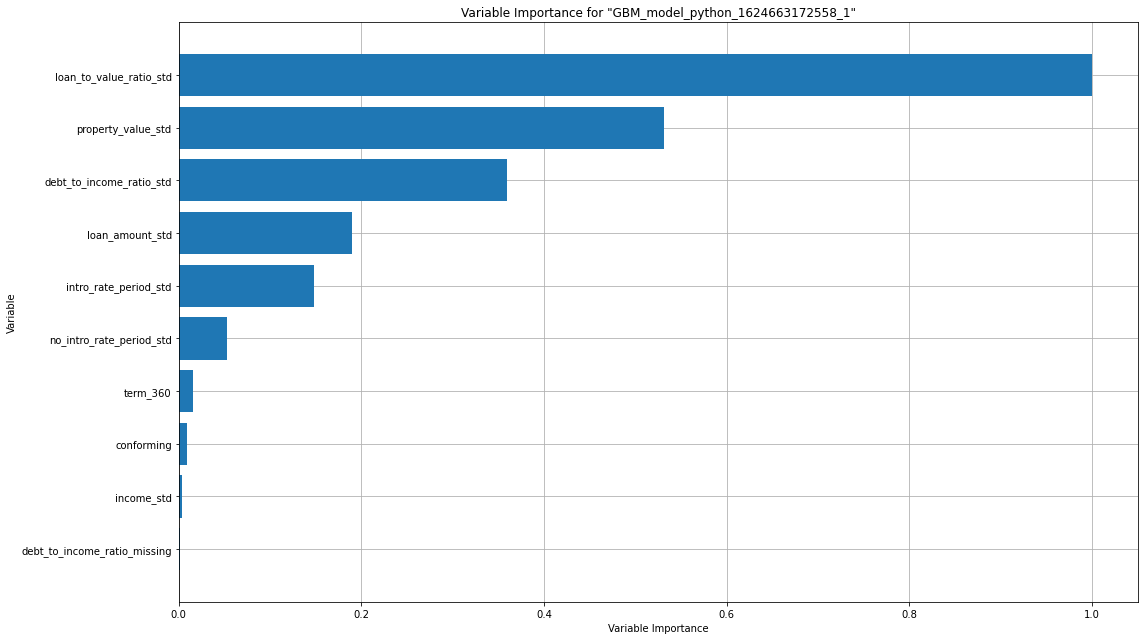

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\Users\minhyekim\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


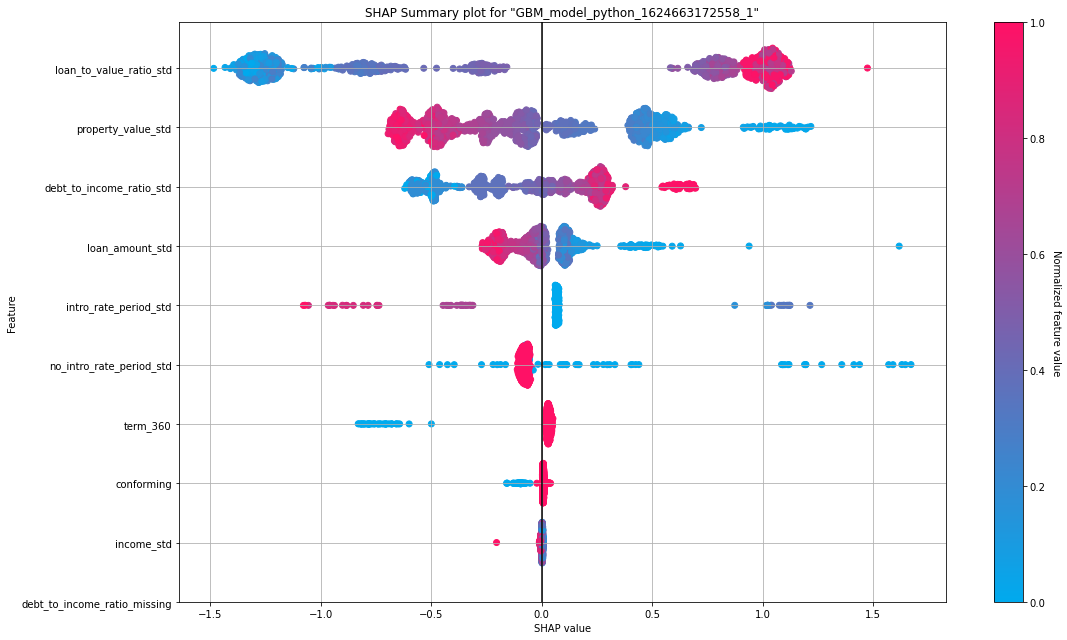

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

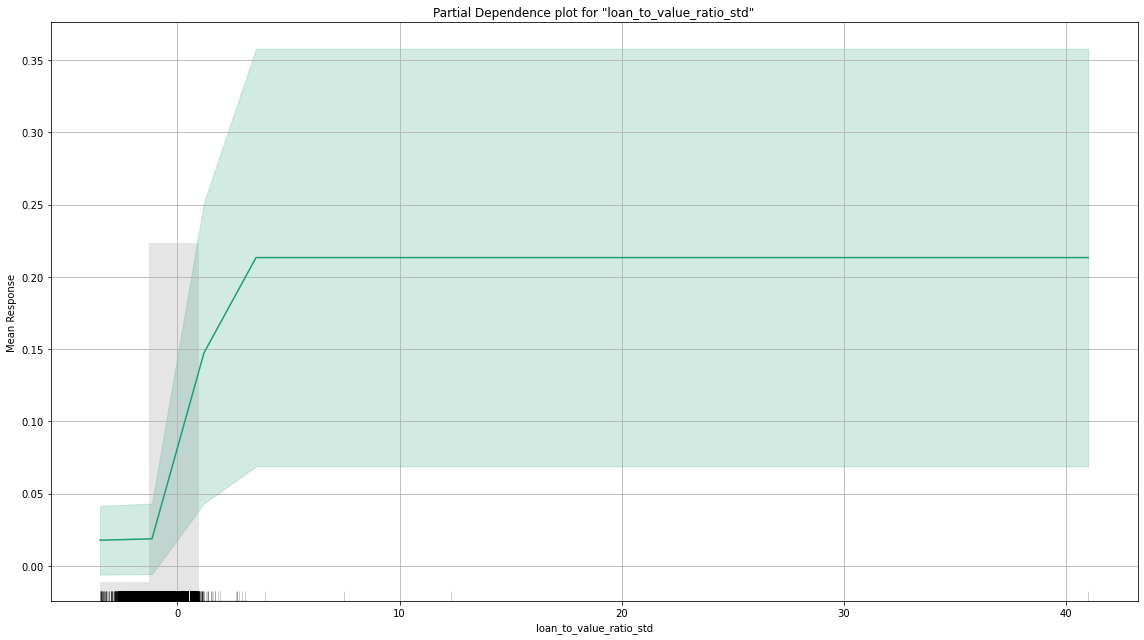

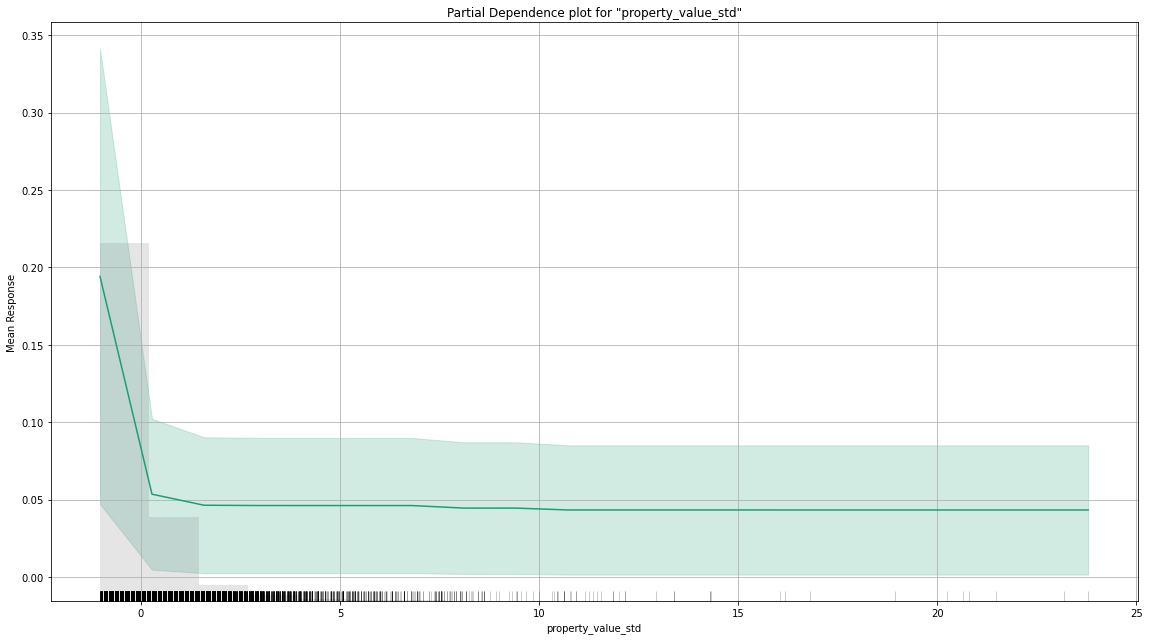

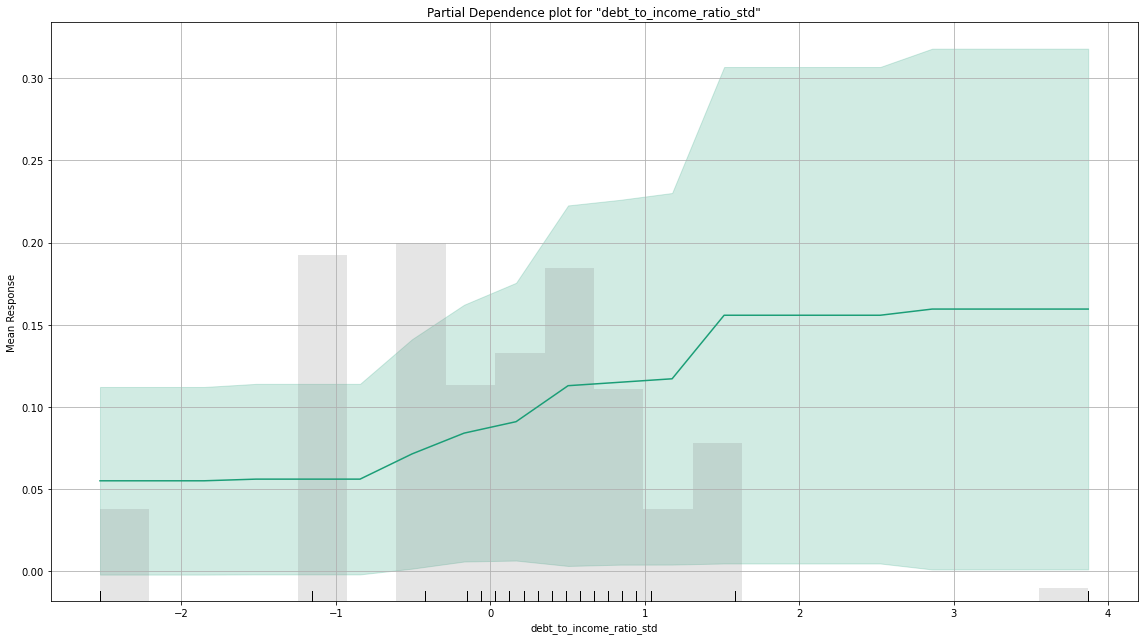

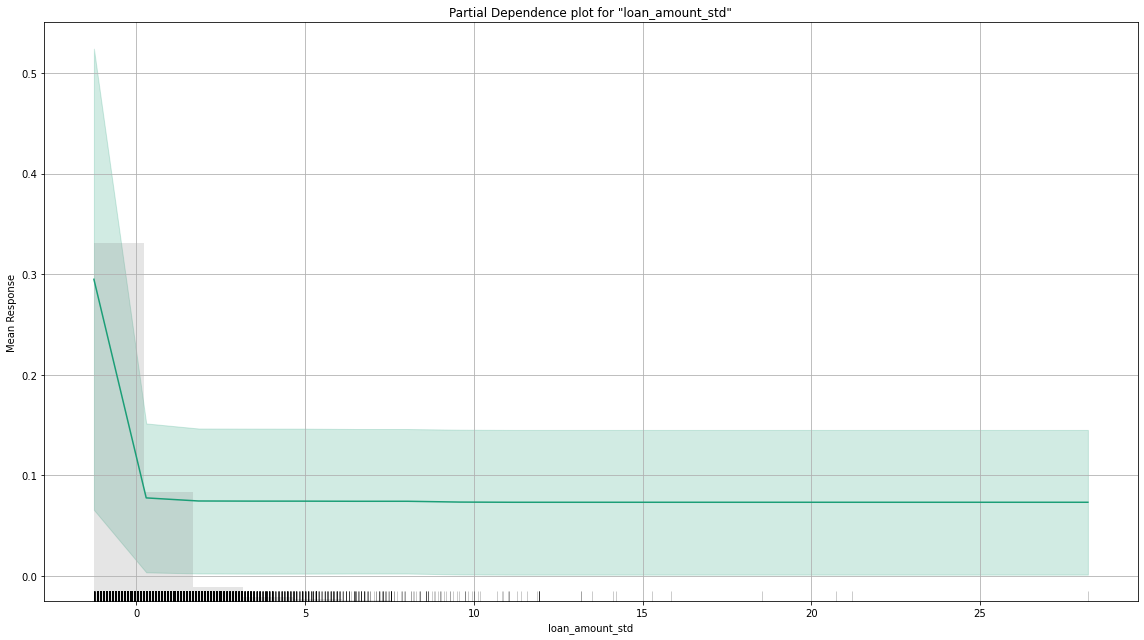

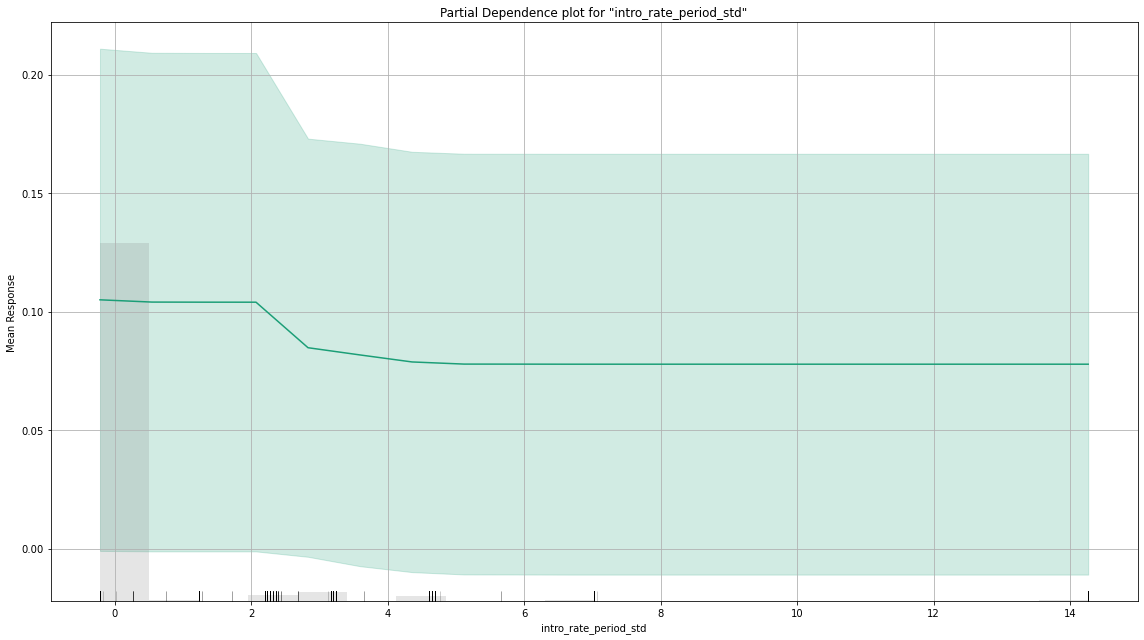

In [9]:
exa_mgbm = best_gbm.explain(hvalid)

In [22]:
best_gbm.auc()

0.802171507054444

In [10]:
# create a submission file
best_gbm_submit = best_gbm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
best_gbm_submit.columns = ['phat']
best_gbm_submit.to_csv('group5_mgbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### H2O Explain


19:26:09.930: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:26:09.985: AutoML: XGBoost is not available; skipping it.



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id auc logloss aucpr mean_per_class_error rmse mse training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_AllModels_AutoML_20210625_192609 0.819596 0.254975 0.287509 0.286015 0.276092 0.076227 87703 0.016461 StackedEnsemble 
 GBM_3_AutoML_20210625_192609 0.818378 0.264845 0.286785 0.301459 0.27801 0.0772896 1500 0.002098 GBM 
 StackedEnsemble_BestOfFamily_AutoML_20210625_192609 0.81822 0.255858 0.287067 0.275986 0.276324 0.0763548 57816 0.006348 StackedEnsemble 
 GBM_2_AutoML_20210625_192609 0.816032 0.266446 0.283462 0.279512 0.278622 0.07763 1338 0.001812 GBM 
 GBM_4_AutoML_20210625_192609 0.815991 0.270465 0.283161 0.292688 0.279645 0.0782014 1322 0.001892 GBM 
 GBM_1_AutoML_20210625_192609 0.814042 0.266911 0.28077 0.292188 0.278978 0.077829 1412 0.00236 GBM 
 GBM_5_AutoML_20210625_192609 0.813792 0.273492 0.276342 0.280879 0.280781 0.0788382 1484 0.002552 GBM 
 GBM_grid__1_AutoML_20210625_192609_model_1 0.813778 0.25791 0.271524 0.28605 0.277253 0.0768695 5539 0.007067 GBM 
 GBM_grid__1_AutoML_20210625_192609_model_2 0.808112 0.263521 0.266063 0.296273 0.278719 0.0776844 1905 0.002363 GBM 
 DeepLearning_1_AutoML_20210625_192609 0.78989 0.269431 0.24175 0.30149 0.281063 0.0789966 960 0.002771 DeepLearning 
 DeepLearning_grid__1_AutoML_20210625_192609_model_1 0.785294 0.277389 0.244511 0.3106 0.281379 0.0791743 892 0.002587 DeepLearning 
 DeepLearning_grid__2_AutoML_20210625_192609_model_1 0.78242 0.27063 0.231719 0.304457 0.281866 0.0794483 1637 0.00428 DeepLearning 
 XRT_1_AutoML_20210625_192609 0.772443 0.351409 0.225624 0.283322 0.289419 0.0837635 1469 0.002084 DRF 
 DeepLearning_grid__3_AutoML_20210625_192609_model_1 0.772208 0.275076 0.219571 0.305929 0.28293 0.0800494 2588 0.006338 DeepLearning 
 DRF_1_AutoML_20210625_192609 0.762159 0.532882 0.224506 0.289697 0.294003 0.0864376 1288 0.002279 DRF 
 GLM_1_AutoML_20210625_192609 0.749408 0.302449 0.215036 0.333229 0.290747 0.0845337 4443 0.000588 GLM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210625_192609


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1735788380386385: 


0.0     1.0   Error              Rate
0    0.0  7334.0  1623.0  0.1812   (1623.0/8957.0)
1    1.0   319.0   641.0  0.3323     (319.0/960.0)
2  Total  7653.0  2264.0  0.1958   (1942.0/9917.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

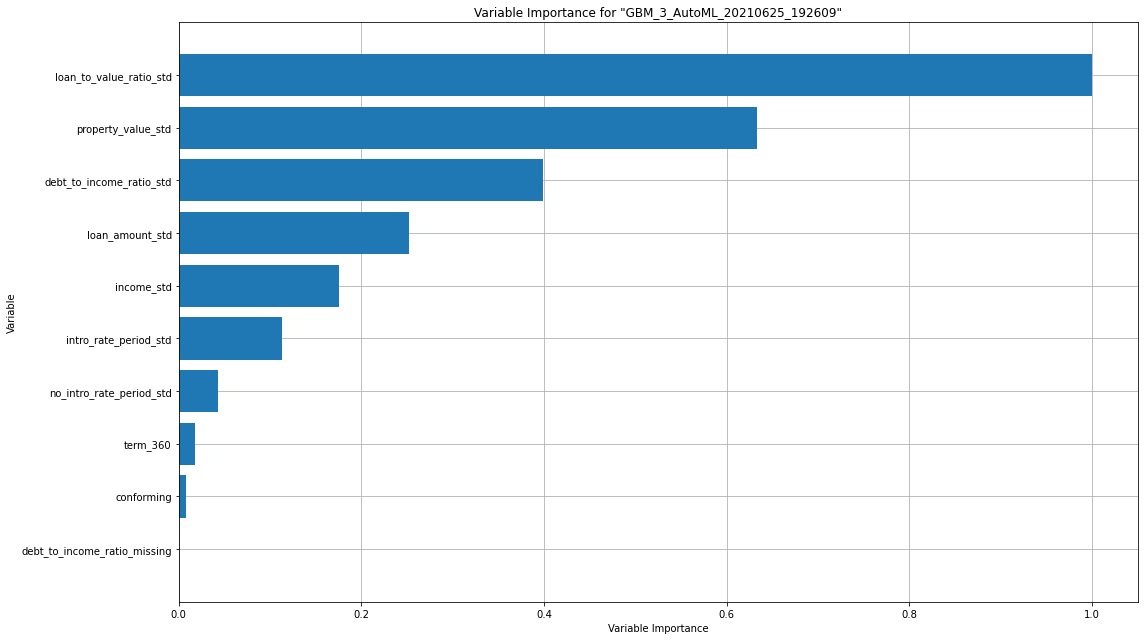

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

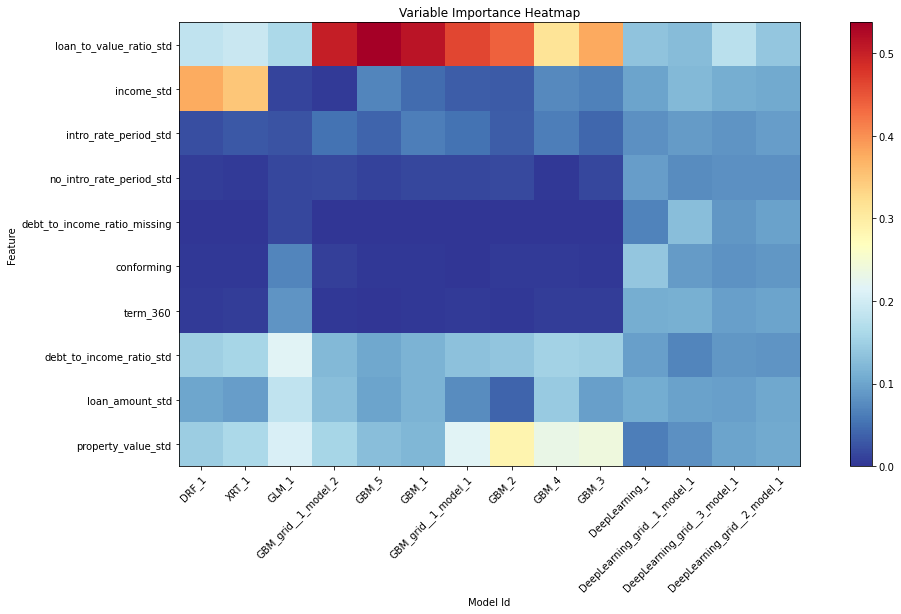

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

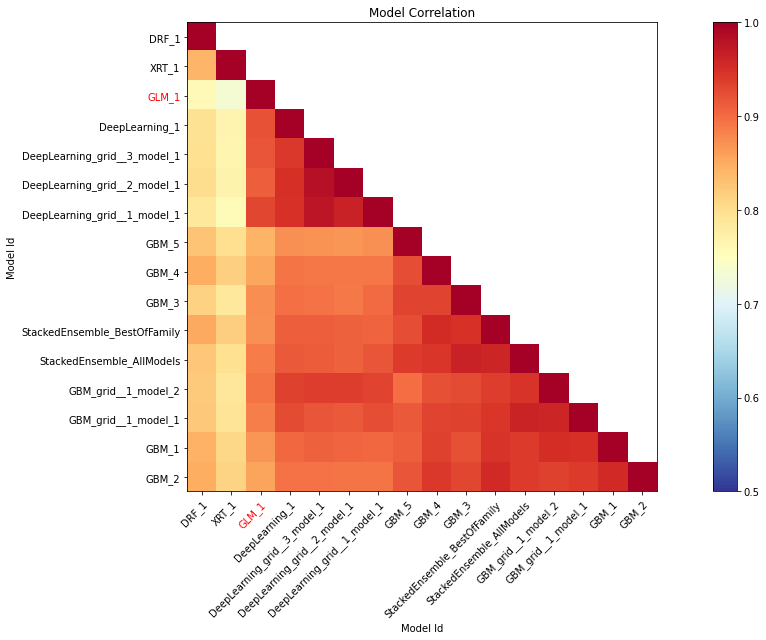

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\Users\minhyekim\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


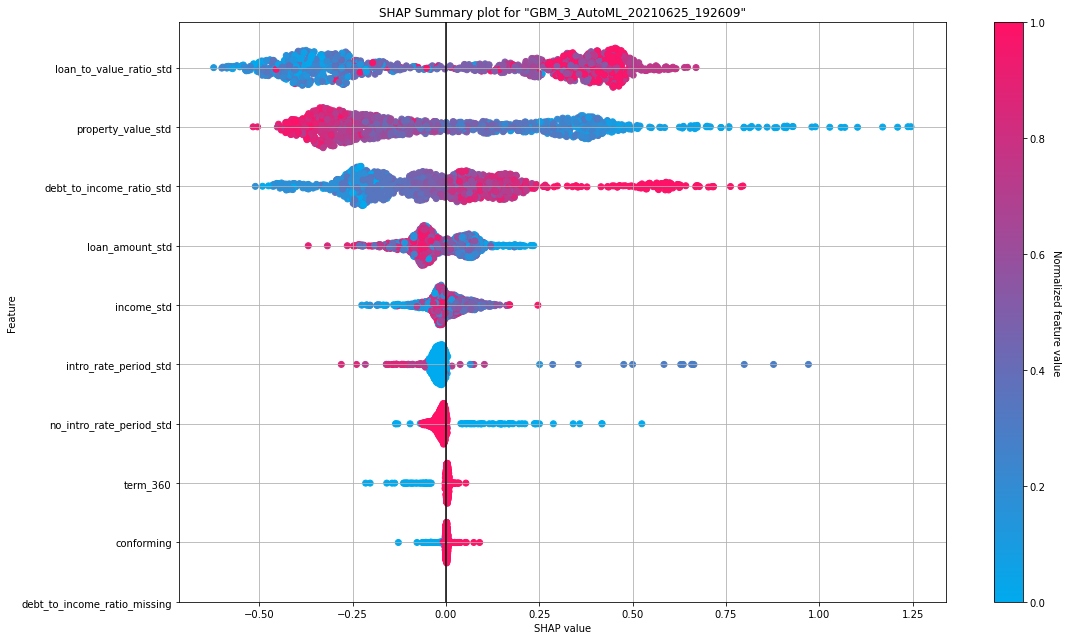

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

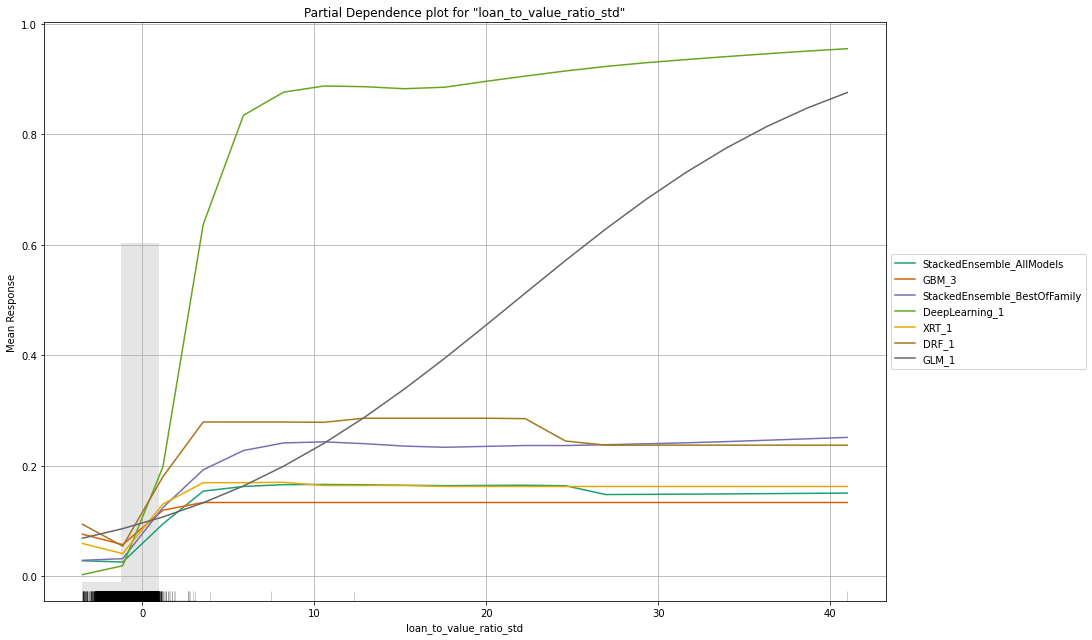

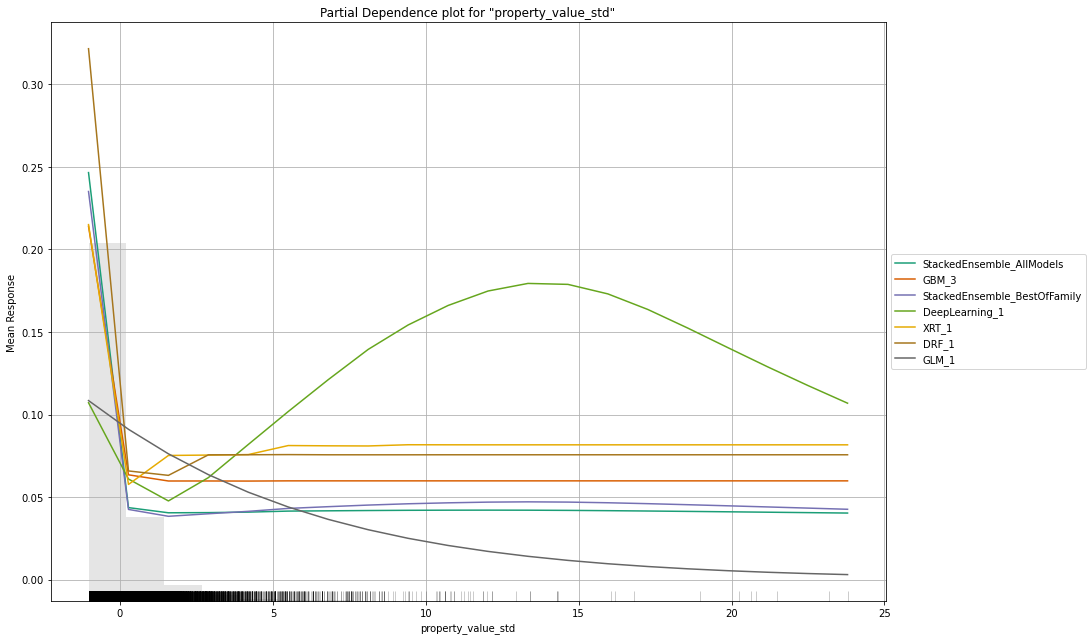

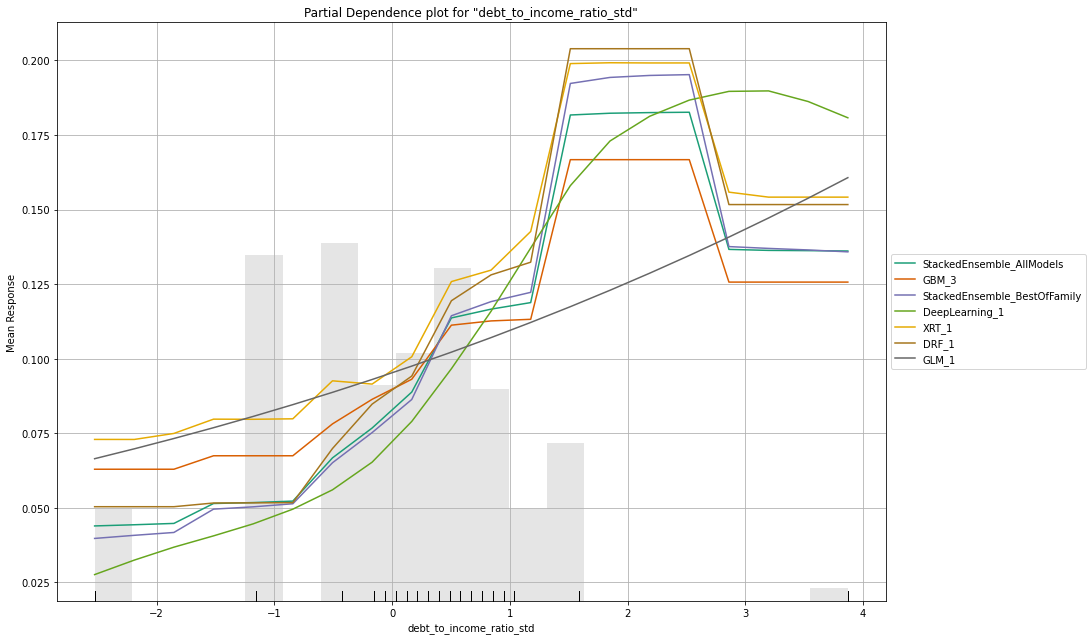

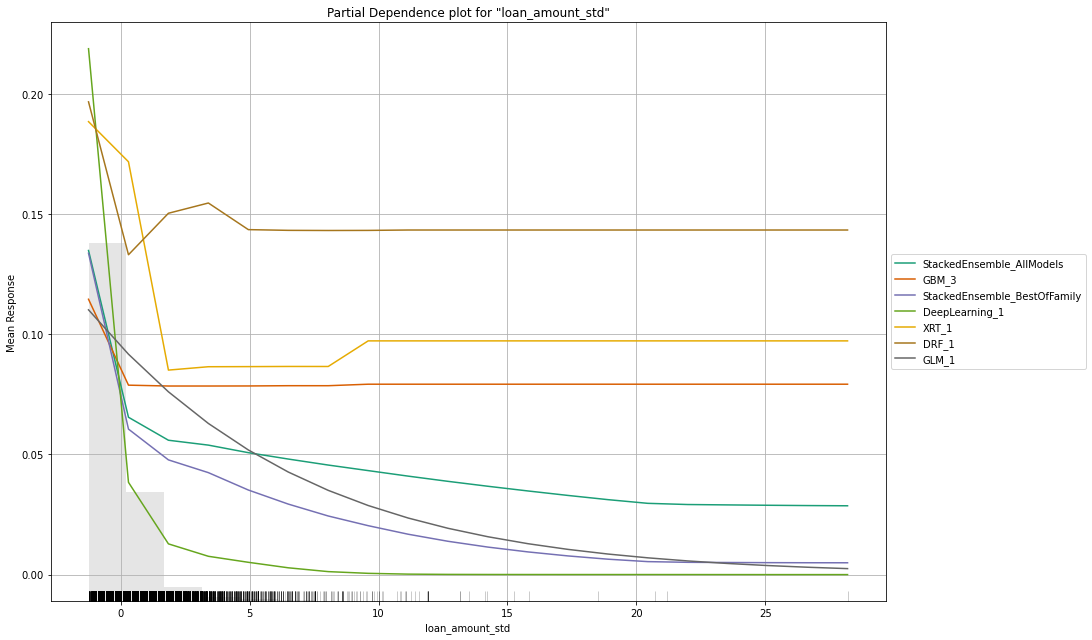

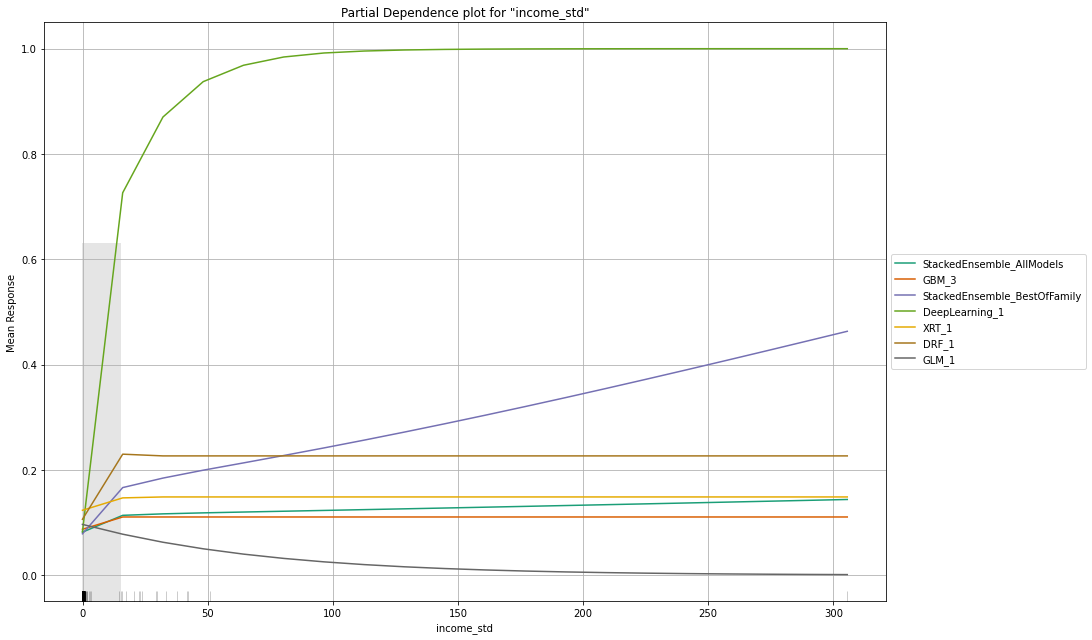

In [11]:
# preserve exact reproducibility
np.random.seed(SEED)

# use top models for submission

# Run AutoML for 3 minutes
aml = H2OAutoML(max_runtime_secs=180, seed=SEED)
aml.train(x=x_names, y=y_name, training_frame=htrain, validation_frame=hvalid)

# Explain leader model & compare with all AutoML models
exa = aml.explain(hvalid)

In [12]:
lb = aml.leaderboard
lb

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 StackedEnsemble_AllModels_AutoML_20210625_192609 0.819596 0.254975 0.287509 0.286015 0.276092 0.076227 
 GBM_3_AutoML_20210625_192609 0.818378 0.264845 0.286785 0.301459 0.27801 0.0772896 
 StackedEnsemble_BestOfFamily_AutoML_20210625_192609 0.81822 0.255858 0.287067 0.275986 0.276324 0.0763548 
 GBM_2_AutoML_20210625_192609 0.816032 0.266446 0.283462 0.279512 0.278622 0.07763 
 GBM_4_AutoML_20210625_192609 0.815991 0.270465 0.283161 0.292688 0.279645 0.0782014 
 GBM_1_AutoML_20210625_192609 0.814042 0.266911 0.28077 0.292188 0.278978 0.077829 
 GBM_5_AutoML_20210625_192609 0.813792 0.273492 0.276342 0.280879 0.280781 0.0788382 
 GBM_grid__1_AutoML_20210625_192609_model_1 0.813778 0.25791 0.271524 0.28605 0.277253 0.0768695 
 GBM_grid__1_AutoML_20210625_192609_model_2 0.808112 0.263521 0.266063 0.296273 0.278719 0.0776844 
 DeepLearning_1_AutoML_20210625_192609 0.78989 0.269431 0.24175 0.30149 0.281063 0.0789966

### ENSENBLE _ H2O AUTOML

In [13]:
ensenble_h2o = h2o.get_model(lb[0,"model_id"])

In [14]:
# create a submission file
ensenble_submit = ensenble_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
ensenble_submit.drop(['predict', '0.0'], axis=1, inplace=True)
ensenble_submit.columns = ['phat']
ensenble_submit.to_csv('group5_ensenble_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### GBM _ H2O AUTOML

In [23]:
gbm_h2o = h2o.get_model(lb[1,"model_id"])

In [24]:
# create a submission file
gbm_submit = gbm_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
gbm_submit.columns = ['phat']
gbm_submit.to_csv('group5_gbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

## Calculate and Plot Global Feature Importance.

### MGBM

In [25]:
import shap

shap.initjs()

In [26]:
# must convert from Pandas to H2OFrame ... and back again ... wasteful
shap_contribs_hf = best_gbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 2.53678132e-02  5.06912032e-03 -3.39932594e-04 ...  1.67568668e-03
   2.84477323e-01 -2.95474839e+00]
 [ 3.50550488e-02 -1.04621962e-01 -4.00915189e-04 ... -5.68656763e-03
  -4.94090408e-01 -2.95474839e+00]
 [ 4.00337204e-02  8.60574748e-03 -3.75397678e-04 ... -3.69064254e-03
  -4.82685059e-01 -2.95474839e+00]
 ...
 [ 2.64708437e-02  6.11919910e-03 -3.49611422e-04 ...  2.23110011e-03
   9.47546959e-03 -2.95474839e+00]
 [ 4.20722552e-02  7.55219813e-03 -3.50718095e-04 ...  1.07576291e-03
  -1.98656231e-01 -2.95474839e+00]
 [ 2.51392853e-02  5.88509394e-03 -3.36235593e-04 ...  1.07634871e-03
   6.05330467e-01 -2.95474839e+00]]

Shapley contributions rows = 47818, columns = 11


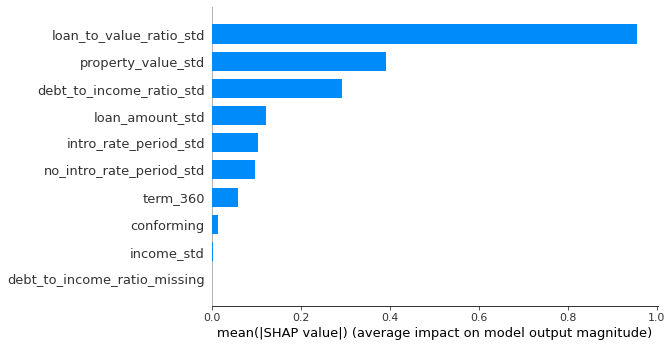

In [27]:
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names, plot_type='bar', title='Variable Importance: MGBM') # use shap package for nice bar plot

### GBM

In [28]:
gbm_h2o

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20210625_192609


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               12.0                      12.0              31074.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        8.0        8.0         8.0       186.0       221.0       201.75



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07596847149322962
RMSE: 0.2756237861528457
LogLoss: 0.2598533770342315
Mean Per-Class Error: 0.22998927103434075
AUC: 0.8347848533349105
AUCPR: 0.32931268237820654
Gini: 0.669569706669821

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15442572328363321: 


0.0      1.0   Error                 Rate
0    0.0  82870.0  18798.0  0.1849   (18798.0/101668.0)
1    1.0   3836.0   7016.0  0.3535     (3836.0/10852.0)
2  Total  86706.0  25814.0  0.2012   (22634.0/112520.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.154426       0.382698  197.0
1                        max f2   0.111557       0.548030  251.0
2                  max f0point5   0.211145       0.342246  127.0
3                  max accuracy   0.312040       0.905395   58.0
4                 max precision   0.633387       1.000000    0.0
5                    max recall   0.032089       1.000000  398.0
6               max specificity   0.633387       1.000000    0.0
7              max absolute_mcc   0.118755       0.333149  243.0
8    max min_per_class_accuracy   0.136517       0.755302  221.0
9   max mean_per_class_accuracy   0.104306       0.770011  261.0
10                      max tns   0.633387  101668.000000    0.0
11                      max fns   0.633387   10850.000000    0.0
12                      max fps   0.031724  101668.000000  399.0
13                      max tps   0.032089   10852.000000  398.0
14                      max tnr   0.633387       1.000000    0.0
15                      max fnr   0.633387       0.999816    0.0
16                      max fpr   0.031724       1.000000  399.0
17                      max tpr   0.032089       1.000000  398.0


Gains/Lift Table: Avg response rate:  9.64 %, avg score:  9.76 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010140         0.304761  6.043047   
1       2                  0.020592         0.275473  3.976392   
2       3                  0.030057         0.253370  3.670386   
3       4                  0.040233         0.240024  3.432050   
4       5                  0.050124         0.227626  3.213985   
5       6                  0.100000         0.201787  2.843419   
6       7                  0.150009         0.181634  2.472837   
7       8                  0.200098         0.162406  2.284918   
8       9                  0.300071         0.133813  1.817661   
9      10                  0.400018         0.095295  1.193965   
10     11                  0.500018         0.065397  0.599889   
11     12                  0.600062         0.050624  0.278166   
12     13                  0.700000         0.040206  0.146608   
13     14                  0.800071         0.035888  0.064458   
14     15                  0.900507         0.033754  0.043122   
15     16                  1.000000         0.029299  0.014819   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          6.043047       0.582822  0.362023                  0.582822   
1          4.994110       0.383503  0.286940                  0.481657   
2          4.577266       0.353991  0.264521                  0.441455   
3          4.287610       0.331004  0.246169                  0.413519   
4          4.075741       0.309973  0.232969                  0.393085   
5          3.461113       0.274234  0.211784                  0.333807   
6          3.131649       0.238493  0.191982                  0.302032   
7          2.919693       0.220369  0.172025                  0.281590   
8          2.552534       0.175304  0.148550                  0.246179   
9          2.213088       0.115152  0.114080                  0.213441   
10         1.890460       0.057856  0.078645                  0.182326   
11         1.621653       0.026828  0.057107                  0.156400   
12         1.411063       0.014140  0.045097                  0.136090   
13         1.242633       0.006217  0.037586                  0.119846   
14         1.108849       0.004159  0.034843                  0.106943   
15         1.000000       0.001429  0.032844                  0.096445   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.362023      0.061279                 0.061279  504.304654   
1           0.323915      0.041559                 0.102838  297.639170   
2           0.305212      0.034740                 0.137578  267.038550   
3           0.290278      0.034924                 0.172503  243.205044   
4           0.278969      0.031791                 0.204294  221.398517   
5           0.245460      0.141817                 0.346111  184.341923   
6           0.227632      0.123664                 0.469775  147.283728   
7           0.213712      0.114449                 0.584224  128.491764   
8           0.192002      0.181718                 0.765942   81.766118   
9           0.172533      0.119333                 0.885275   19.396509   
10          0.153756      0.059989                 0.945264  -40.011058   
11          0.137642      0.027829                 0.973093  -72.183389   
12          0.124430      0.014652                 0.987744  -85.339202   
13          0.113568      0.006450                 0.994195  -93.554159   
14          0.104787      0.004331                 0.998526  -95.687780   
15          0.097629      0.001474                 1.000000  -98.518110   

    cumulative_gain  kolmogorov_smirnov  
0        504.304654            0.056597  
1        399.410995            0.091025  
2        357.726591            0.118998  
3        328.761013            0.146388  
4        307.574052            0.170626  
5        246.111316            0.272381  
6        213.164883            0.353898  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07789013943046294
RMSE: 0.2790880496016677
LogLoss: 0.266511629011806
Mean Per-Class Error: 0.2432169538022635
AUC: 0.8184224967150949
AUCPR: 0.2916367917640127
Gini: 0.6368449934301899

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1592338104198655: 


0.0      1.0   Error               Rate
0    0.0  35823.0   7342.0  0.1701   (7342.0/43165.0)
1    1.0   1961.0   2692.0  0.4214    (1961.0/4653.0)
2  Total  37784.0  10034.0  0.1946   (9303.0/47818.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.159234      0.366583  184.0
1                        max f2   0.109606      0.534013  251.0
2                  max f0point5   0.200190      0.313419  130.0
3                  max accuracy   0.384635      0.903112   26.0
4                 max precision   0.586640      1.000000    0.0
5                    max recall   0.031906      1.000000  399.0
6               max specificity   0.586640      1.000000    0.0
7              max absolute_mcc   0.123161      0.317971  234.0
8    max min_per_class_accuracy   0.132703      0.743391  223.0
9   max mean_per_class_accuracy   0.102459      0.756783  261.0
10                      max tns   0.586640  43165.000000    0.0
11                      max fns   0.586640   4652.000000    0.0
12                      max fps   0.031906  43165.000000  399.0
13                      max tps   0.031906   4653.000000  399.0
14                      max tnr   0.586640      1.000000    0.0
15                      max fnr   0.586640      0.999785    0.0
16                      max fpr   0.031906      1.000000  399.0
17                      max tpr   0.031906      1.000000  399.0


Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.73 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010247         0.298718  4.697971   
1       2                  0.020118         0.274119  3.940896   
2       3                  0.030031         0.251764  3.512328   
3       4                  0.040006         0.237793  3.123978   
4       5                  0.050044         0.224647  2.911763   
5       6                  0.100381         0.200647  2.749591   
6       7                  0.150027         0.180669  2.454487   
7       8                  0.201200         0.161623  2.267870   
8       9                  0.300033         0.134013  1.824427   
9      10                  0.399996         0.094991  1.216878   
10     11                  0.500063         0.065826  0.687268   
11     12                  0.600004         0.050658  0.361269   
12     13                  0.700343         0.040203  0.158500   
13     14                  0.800013         0.035932  0.079782   
14     15                  0.900017         0.033786  0.068770   
15     16                  1.000000         0.030704  0.038691   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.697971       0.457143  0.342793                  0.457143   
1          4.326516       0.383475  0.284428                  0.420998   
2          4.057766       0.341772  0.263802                  0.394847   
3          3.824929       0.303983  0.245184                  0.372190   
4          3.641762       0.283333  0.230466                  0.354367   
5          3.194375       0.267553  0.210274                  0.310833   
6          2.949533       0.238837  0.191203                  0.287009   
7          2.776160       0.220678  0.171002                  0.270138   
8          2.462652       0.177529  0.148267                  0.239632   
9          2.151323       0.118410  0.114091                  0.209338   
10         1.858353       0.066876  0.078803                  0.180830   
11         1.608987       0.035154  0.057360                  0.156565   
12         1.401174       0.015423  0.045102                  0.136343   
13         1.236548       0.007763  0.037624                  0.120324   
14         1.106792       0.006692  0.034903                  0.107698   
15         1.000000       0.003765  0.032890                  0.097306   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.342793      0.048141                 0.048141  369.797059   
1           0.314157      0.038900                 0.087041  294.089561   
2           0.297536      0.034816                 0.121857  251.232769   
3           0.284482      0.031163                 0.153020  212.397808   
4           0.273647      0.029228                 0.182248  191.176302   
5           0.241868      0.138405                 0.320653  174.959122   
6           0.225102      0.121857                 0.442510  145.448679   
7           0.211342      0.116054                 0.558564  126.786995   
8           0.190565      0.180314                 0.738878   82.442745   
9           0.171454      0.121642                 0.860520   21.687758   
10          0.152913      0.068773                 0.929293  -31.273158   
11          0.136997      0.036106                 0.965399  -63.873108   
12          0.123831      0.015904                 0.981302  -84.149979   
13          0.113091      0.007952                 0.989254  -92.021779   
14          0.104403      0.006877                 0.996132  -93.123004   
15          0.097253      0.003868                 1.000000  -96.130881   

    cumulative_gain  kolmogorov_smirnov  
0        369.797059            0.041979  
1        332.651592            0.074137  
2        305.776577            0.101725  
3        282.492901            0.125196  
4        264.176157            0.146455  
5        219.437531            0.244017  
6        194.953347            0.324011  
7        1



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.0772895906593812
RMSE: 0.2780100549609334
LogLoss: 0.2648452942244096
Mean Per-Class Error: 0.24297894314866364
AUC: 0.8183779958511708
AUCPR: 0.28678473265633114
Gini: 0.6367559917023415

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16321427260307036: 


0.0      1.0   Error                 Rate
0    0.0  85115.0  16553.0  0.1628   (16553.0/101668.0)
1    1.0   4776.0   6076.0  0.4401     (4776.0/10852.0)
2  Total  89891.0  22629.0  0.1896   (21329.0/112520.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.163214       0.362952  186.0
1                        max f2   0.109331       0.532541  254.0
2                  max f0point5   0.201257       0.309931  140.0
3                  max accuracy   0.449597       0.903875   24.0
4                 max precision   0.674499       1.000000    0.0
5                    max recall   0.022775       1.000000  399.0
6               max specificity   0.674499       1.000000    0.0
7              max absolute_mcc   0.115998       0.315922  247.0
8    max min_per_class_accuracy   0.132570       0.742161  227.0
9   max mean_per_class_accuracy   0.106036       0.757021  258.0
10                      max tns   0.674499  101668.000000    0.0
11                      max fns   0.674499   10850.000000    0.0
12                      max fps   0.022775  101668.000000  399.0
13                      max tps   0.022775   10852.000000  399.0
14                      max tnr   0.674499       1.000000    0.0
15                      max fnr   0.674499       0.999816    0.0
16                      max fpr   0.022775       1.000000  399.0
17                      max tpr   0.022775       1.000000  399.0


Gains/Lift Table: Avg response rate:  9.64 %, avg score:  9.77 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010007         0.303151  4.641006   
1       2                  0.020325         0.271428  3.750913   
2       3                  0.030004         0.254873  3.599017   
3       4                  0.040002         0.241859  3.142837   
4       5                  0.050036         0.231025  3.085782   
5       6                  0.100027         0.202443  2.715190   
6       7                  0.150009         0.182030  2.459407   
7       8                  0.200000         0.163103  2.320722   
8       9                  0.300009         0.133878  1.797666   
9      10                  0.400000         0.093353  1.269003   
10     11                  0.500009         0.065532  0.704877   
11     12                  0.600018         0.050171  0.289322   
12     13                  0.700036         0.041475  0.201770   
13     14                  0.800000         0.037675  0.079276   
14     15                  0.900089         0.035283  0.046034   
15     16                  1.000000         0.021541  0.041504   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.641006       0.447602  0.365780                  0.447602   
1          4.189148       0.361757  0.283796                  0.404023   
2          3.998789       0.347107  0.263031                  0.385664   
3          3.784848       0.303111  0.248030                  0.365030   
4          3.644663       0.297609  0.235895                  0.351510   
5          3.180133       0.261867  0.214345                  0.306708   
6          2.939990       0.237198  0.191898                  0.283548   
7          2.785201       0.223822  0.172536                  0.268619   
8          2.456003       0.173376  0.148295                  0.236869   
9          2.159279       0.122389  0.113802                  0.208252   
10         1.868378       0.067982  0.078479                  0.180196   
11         1.605187       0.027904  0.056915                  0.154812   
12         1.404673       0.019460  0.045351                  0.135474   
13         1.239057       0.007646  0.039322                  0.119501   
14         1.106394       0.004440  0.036380                  0.106706   
15         1.000000       0.004003  0.029548                  0.096445   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.365780      0.046443                 0.046443  364.100551   
1           0.324161      0.038703                 0.085146  275.091316   
2           0.304442      0.034832                 0.119978  259.901667   
3           0.290342      0.031423                 0.151401  214.283655   
4           0.279424      0.030962                 0.182363  208.578223   
5           0.246899      0.135735                 0.318098  171.518958   
6           0.228573      0.122927                 0.441025  145.940729   
7           0.214566      0.116015                 0.557040  132.072212   
8           0.192474      0.179783                 0.736823   79.766552   
9           0.172808      0.126889                 0.863712   26.900331   
10          0.153941      0.070494                 0.934206  -29.512346   
11          0.137769      0.028935                 0.963140  -71.067813   
12          0.124565      0.020181                 0.983321  -79.822975   
13          0.113913      0.007925                 0.991246  -92.072375   
14          0.105291      0.004607                 0.995853  -95.396646   
15          0.097724      0.004147                 1.000000  -95.849610   

    cumulative_gain  kolmogorov_smirnov  
0        364.100551            0.040325  
1        318.914840            0.071739  
2        299.878896            0.099578  
3        278.484840            0.123290  
4        264.466266            0.146452  
5        218.013258            0.241348  
6        193.999045            0.322079  
7        1



Cross-Validation Metrics Summary: 


mean            sd  cv_1_valid  \
0                  accuracy   0.7970494   0.011550784   0.7843939   
1                       auc   0.8188298  0.0060186465   0.8121806   
2                       err  0.20295058   0.011550784  0.21560611   
3                 err_count      4567.2     259.93884      4852.0   
4                  f0point5   0.2949692   0.008542082  0.28562394   
5                        f1  0.36467996  0.0066260807   0.3583708   
6                        f2   0.4780557   0.013790395  0.48083746   
7            lift_top_group   4.5521674    0.46907628   4.6225214   
8                   logloss  0.26484528   0.005061271    0.268322   
9       max_per_class_error  0.39603955   0.034180466   0.3772978   
10                      mcc  0.29924932   0.008111233  0.29396582   
11  mean_per_class_accuracy  0.71082544   0.009982557  0.71220213   
12     mean_per_class_error  0.28917453   0.009982557  0.28779787   
13                      mse  0.07728959  0.0012627096  0.07804263   
14                   pr_auc  0.28864926   0.011637472   0.2807261   
15                precision  0.26167607   0.009470773  0.25157815   
16                       r2  0.11306534  0.0072890073  0.10649336   
17                   recall  0.60396045   0.034180466   0.6227022   
18                     rmse  0.27800262  0.0022738143   0.2793611   
19              specificity   0.8176905    0.01625191   0.8017021   

     cv_2_valid  cv_3_valid  cv_4_valid   cv_5_valid  
0    0.78657126  0.80479026    0.811278   0.79821366  
1    0.81291705   0.8225005   0.8207529    0.8257977  
2    0.21342872  0.19520974    0.188722   0.20178635  
3        4803.0      4393.0      4247.0       4541.0  
4    0.28680202   0.3056779   0.2984442   0.29829797  
5    0.36087823   0.3726974  0.36048788    0.3709655  
6    0.48654467  0.47735754  0.45509848   0.49044025  
7     3.8114352   4.8862257   5.0017047    4.4389505  
8    0.26500303  0.26922294  0.26526043    0.2564181  
9    0.36635515  0.41269127   0.4483871    0.3754664  
10    0.3001617  0.30332953  0.28896096   0.30982867  
11    0.7181434  0.70796263   0.6953009    0.7205183  
12   0.28185663  0.29203737   0.3046991   0.27948174  
13   0.07683822  0.07879612  0.07730814  0.075462855  
14    0.2748795  0.30521613  0.29027963   0.29214495  
15   0.25227907  0.27295545  0.26772535   0.26384237  
16  0.107064985  0.11453903  0.11271713   0.12451219  
17    0.6336449   0.5873087   0.5516129    0.6245336  
18   0.27719706  0.28070647  0.27804342   0.27470502  
19    0.8026419   0.8286165   0.8389889    0.8165029


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2021-06-25 19:27:01   6.838 sec              0.0       0.295201   
1    2021-06-25 19:27:01   7.307 sec              5.0       0.282801   
2    2021-06-25 19:27:02   7.877 sec             10.0       0.276877   
3    2021-06-25 19:27:02   8.205 sec             12.0       0.275624   

   training_logloss  training_auc  training_pr_auc  training_lift  \
0          0.317201      0.500000         0.096445       1.000000   
1          0.280601      0.826199         0.313586       5.708243   
2          0.263675      0.833624         0.326857       5.989313   
3          0.259853      0.834785         0.329313       6.043047   

   training_classification_error  validation_rmse  validation_logloss  \
0                       0.903555         0.296376            0.319128   
1                       0.199200         0.285125            0.285050   
2                       0.207305         0.280099            0.269858   
3                       0.201155         0.279088            0.266512   

   validation_auc  validation_pr_auc  validation_lift  \
0        0.500000           0.097306         1.000000   
1        0.811686           0.283322         4.593105   
2        0.817472           0.290366         4.605376   
3        0.818422           0.291637         4.697971   

   validation_classification_error  
0                         0.902694  
1                         0.215986  
2                         0.216613  
3                         0.194550


Variable Importances: 


variable  relative_importance  scaled_importance  \
0       loan_to_value_ratio_std          2112.590088           1.000000   
1            property_value_std          1338.007568           0.633349   
2      debt_to_income_ratio_std           843.251953           0.399156   
3               loan_amount_std           531.871643           0.251763   
4                    income_std           371.724457           0.175957   
5         intro_rate_period_std           238.300278           0.112800   
6      no_intro_rate_period_std            90.049271           0.042625   
7                      term_360            38.464825           0.018207   
8                    conforming            16.286446           0.007709   
9  debt_to_income_ratio_missing             0.955230           0.000452   

   percentage  
0    0.378499  
1    0.239722  
2    0.151080  
3    0.095292  
4    0.066599  
5    0.042695  
6    0.016134  
7    0.006891  
8    0.002918  
9    0.000171

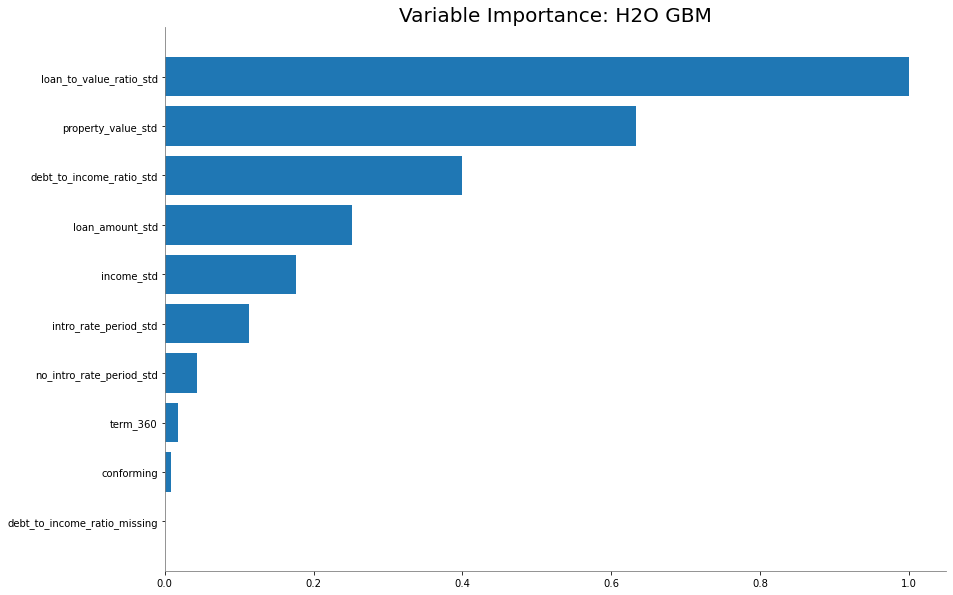

In [29]:
gbm_h2o.varimp_plot()

## Calculate and Plot Local Feature Importance.

### MGBM

In [30]:
from rmltk import explain

In [31]:
# merge MGBM predictions onto validation data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_gbm.predict(hvalid)['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_high_priced', mgbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 25515,
 99: 139587,
 10: 12332,
 20: 14708,
 30: 83479,
 40: 28735,
 50: 7166,
 60: 138033,
 70: 157733,
 80: 36624,
 90: 88990}

In [32]:
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True) # Pandas index will now start from 0
valid_idx_map[0:5] # Shapley array index on left, ID on right

0     4
1     9
2    11
3    15
4    17
Name: row_id, dtype: int64

In [33]:
local_coef_dict = {10: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names)}
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(mgbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['mgbm Contribution'], index=x_names)
        local_coef_dict[percentile]['mgbm Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### Ensenble

In [34]:
# merge ensenble predictions onto validation data
ensenble_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             ensenble_h2o.predict(hvalid)['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
ensenble_yhat_valid = ensenble_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
ensenble_percentile_dict = explain.get_percentile_dict('p_high_priced', ensenble_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
ensenble_percentile_dict

{0: 156364,
 99: 31139,
 10: 155822,
 20: 73428,
 30: 135467,
 40: 1938,
 50: 107832,
 60: 130697,
 70: 97625,
 80: 93078,
 90: 124771}

In [35]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(ensenble_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['Ensenble Contribution'], index=x_names)
        local_coef_dict[percentile]['Ensenble Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### GBM

In [36]:
# merge gbm predictions onto validation data
gbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             gbm_h2o.predict(hvalid)['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
gbm_yhat_valid = gbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
gbm_percentile_dict = explain.get_percentile_dict('p_high_priced', gbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
gbm_percentile_dict

{0: 127997,
 99: 73921,
 10: 67417,
 20: 88576,
 30: 138982,
 40: 108295,
 50: 18060,
 60: 59478,
 70: 151240,
 80: 63370,
 90: 112318}

In [37]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(gbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['gbm Contribution'], index=x_names)
        local_coef_dict[percentile]['gbm Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### Comparison

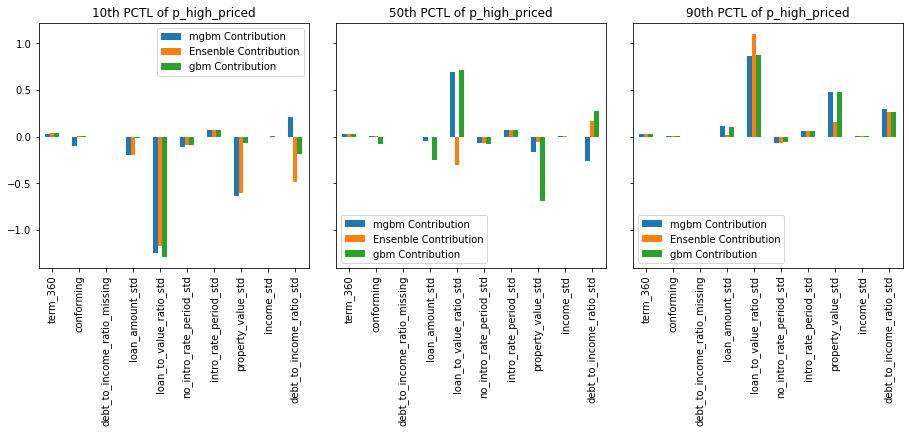

In [38]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_coef_dict[10].plot(kind='bar',
                           ax=ax0,
                           title='10th PCTL of p_high_priced')

_ = local_coef_dict[50].plot(kind='bar',
                           ax=ax1,
                           title='50th PCTL of p_high_priced')

_ = local_coef_dict[90].plot(kind='bar',
                           ax=ax2,
                           title='90th PCTL of p_high_priced')

### H2O Analysis: Ensenble

No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

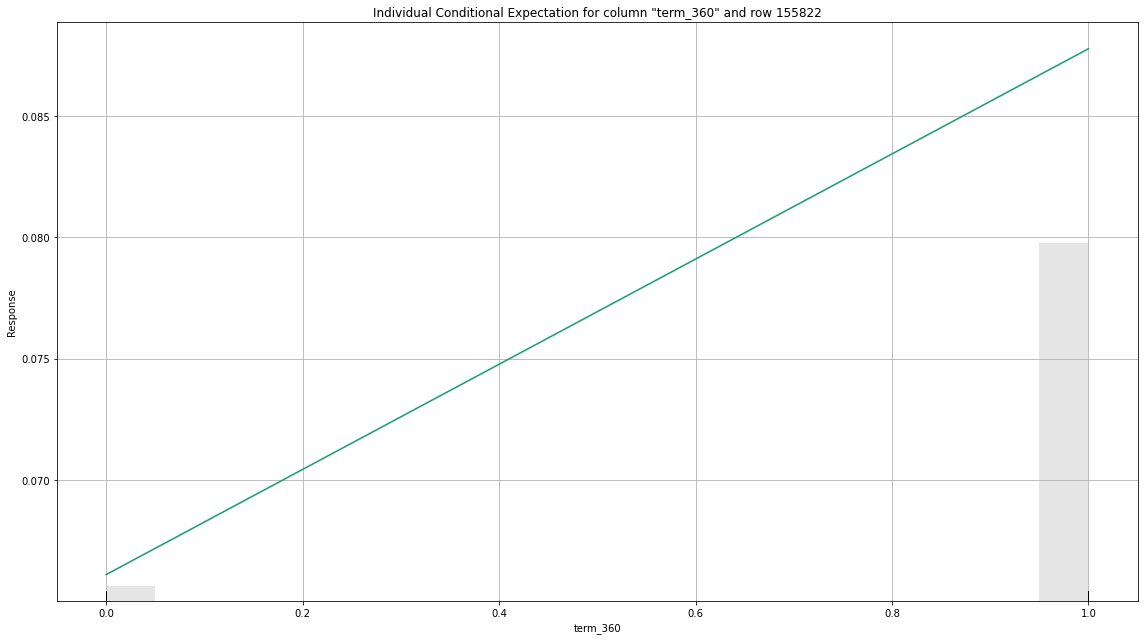

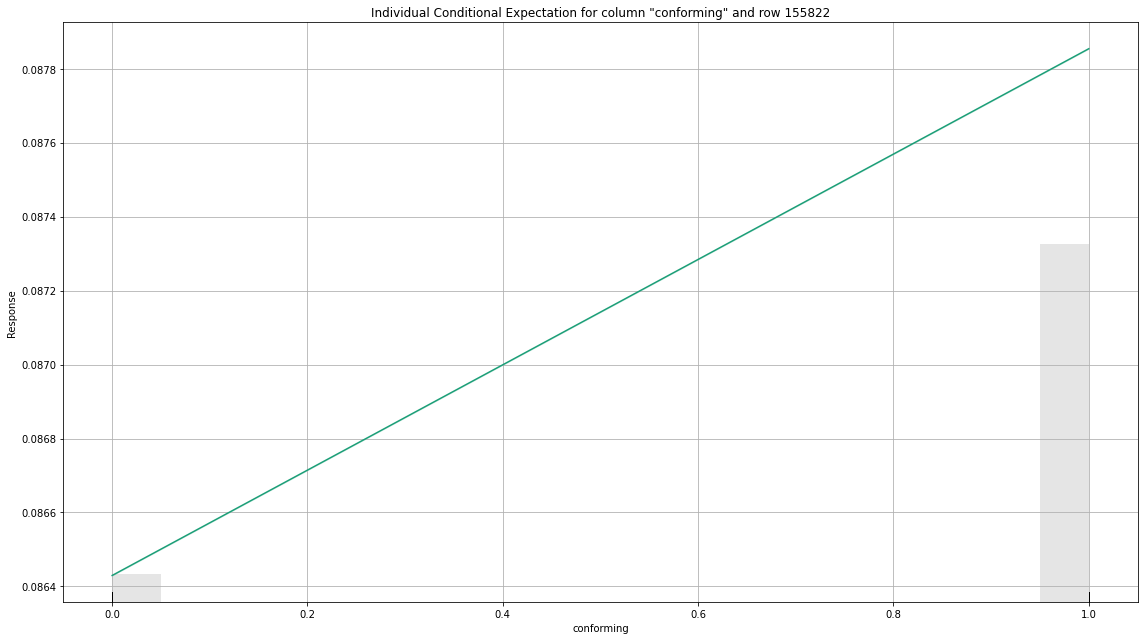

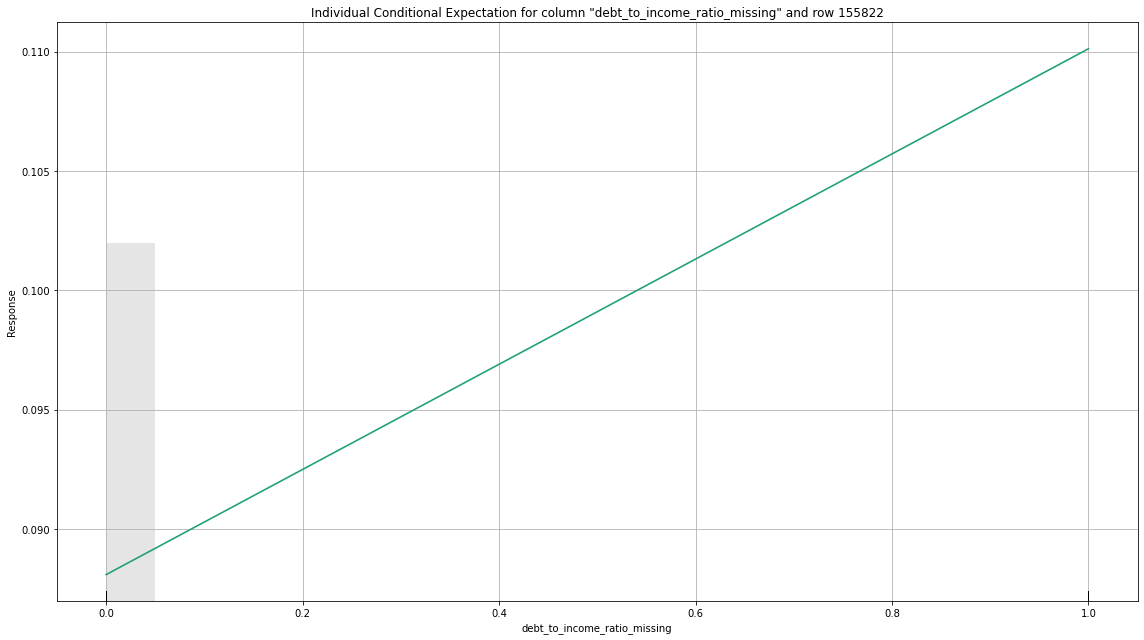

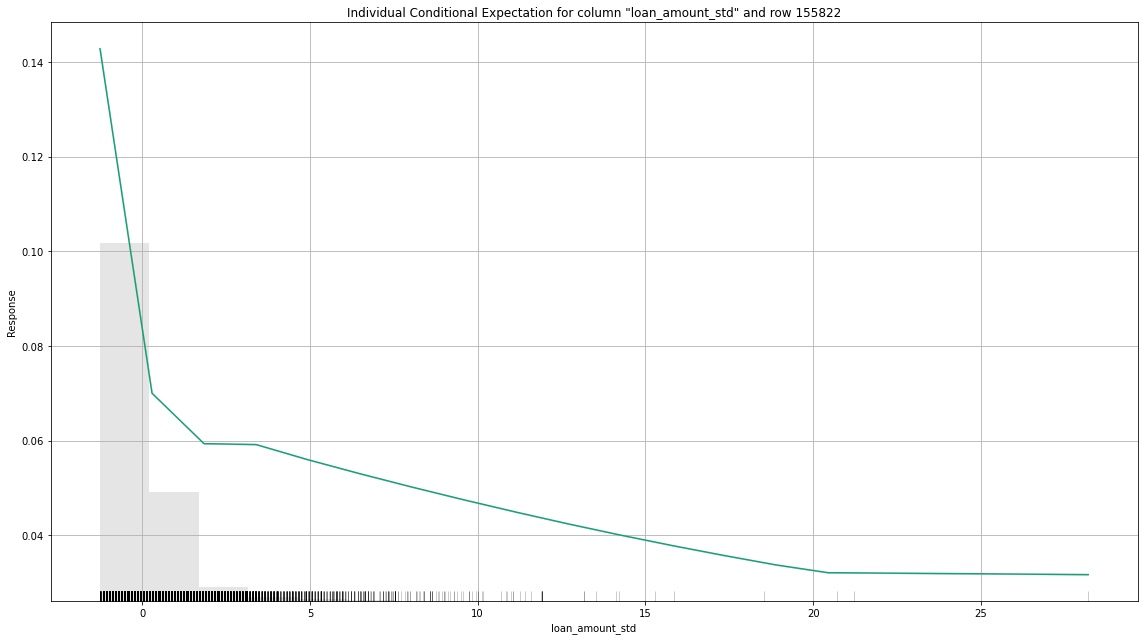

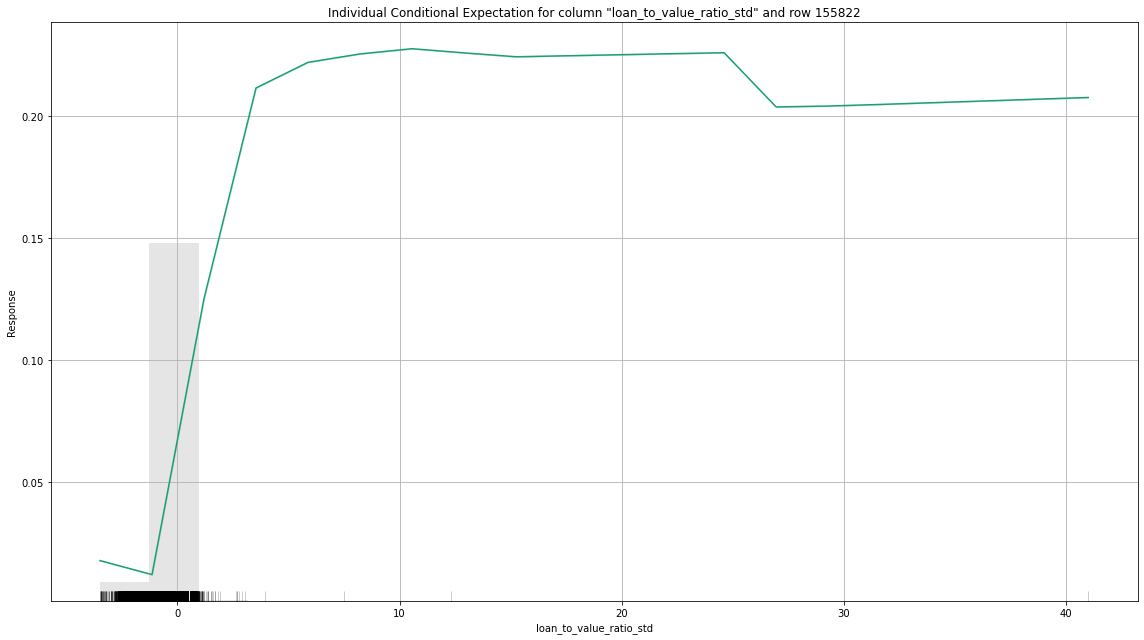

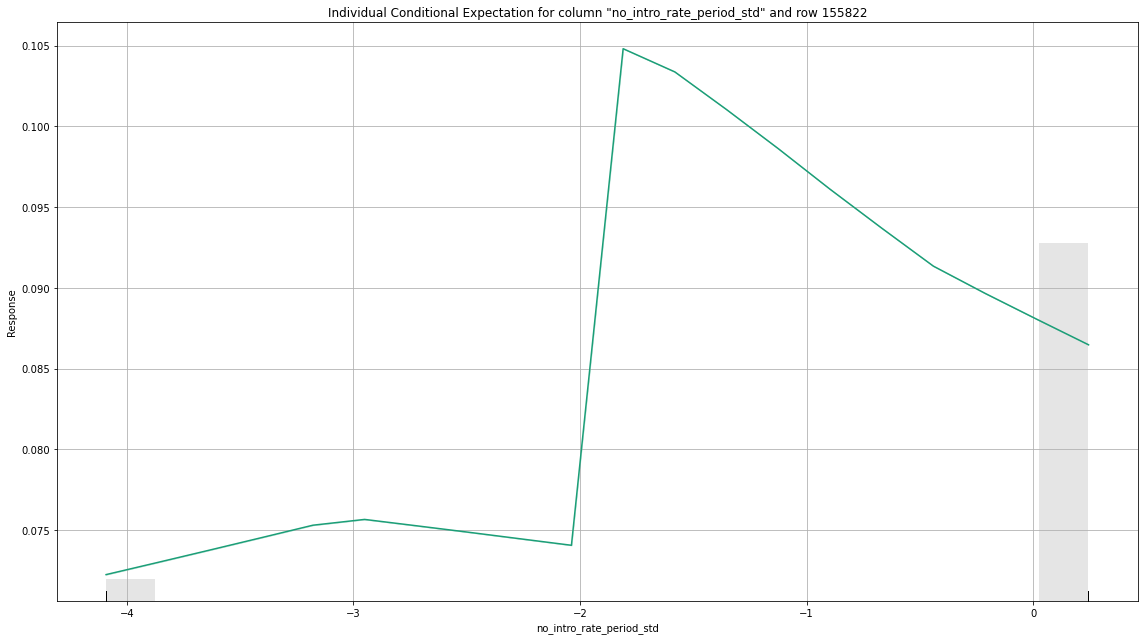

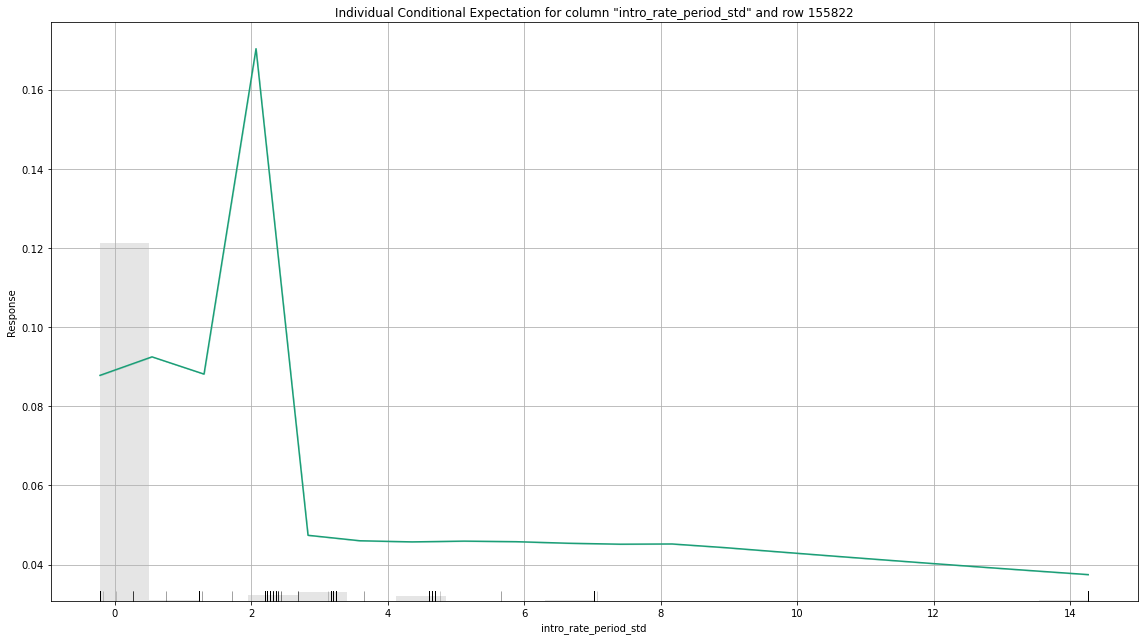

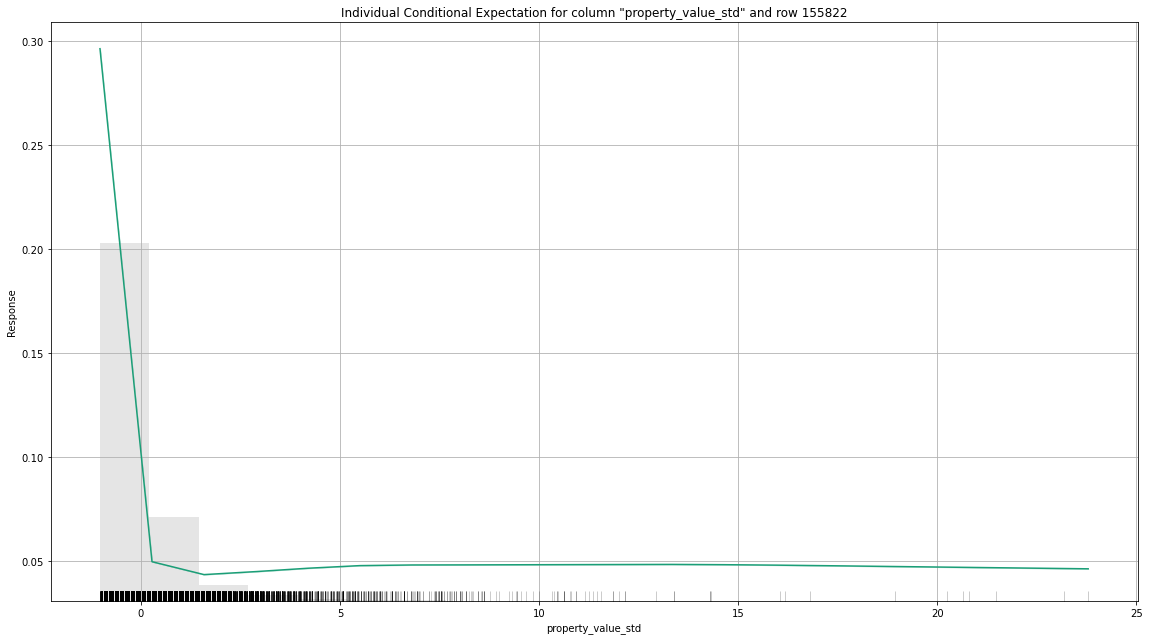

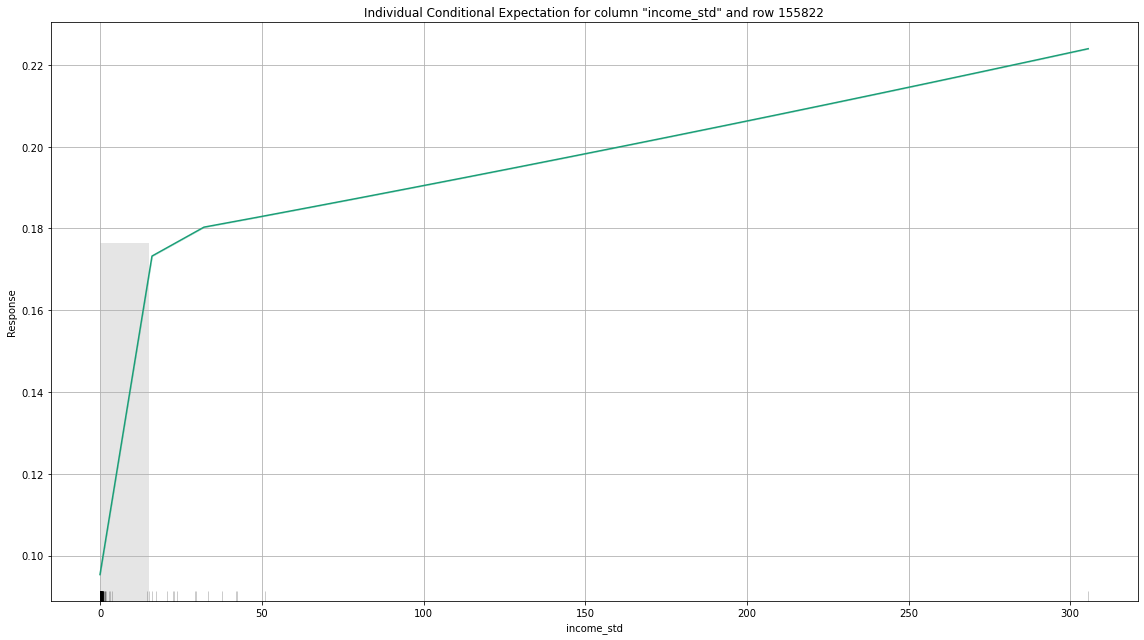

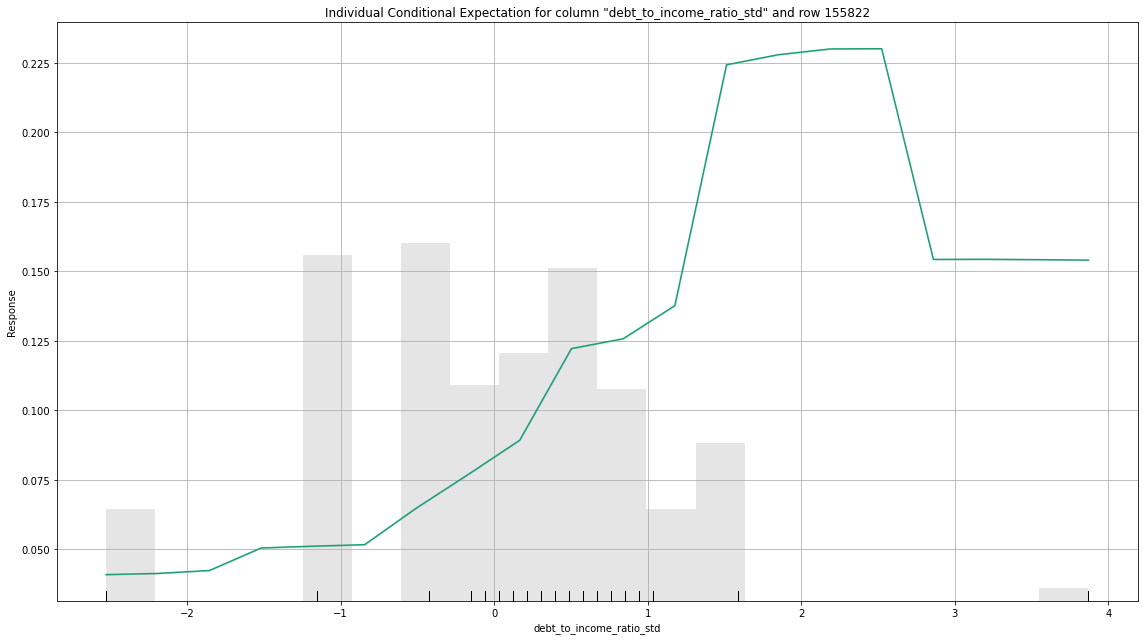

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

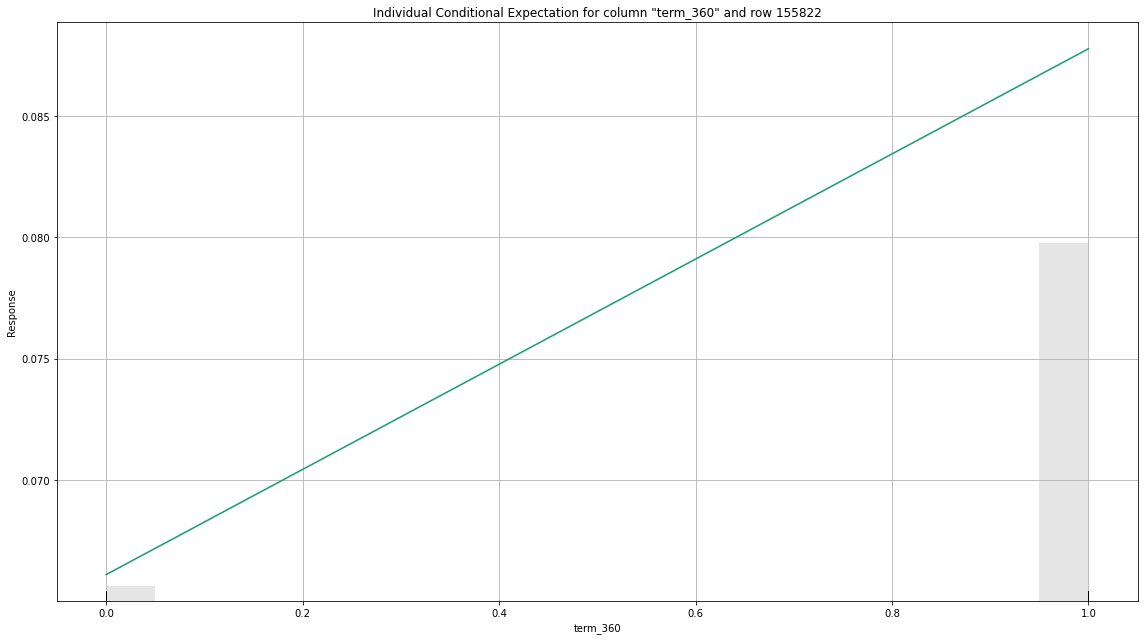

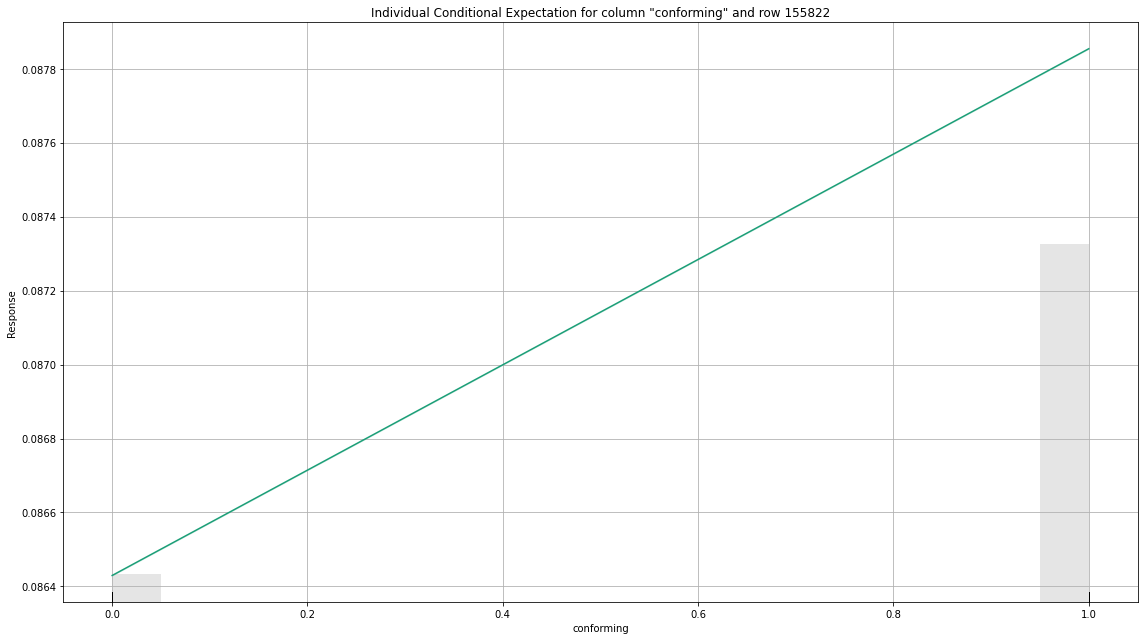

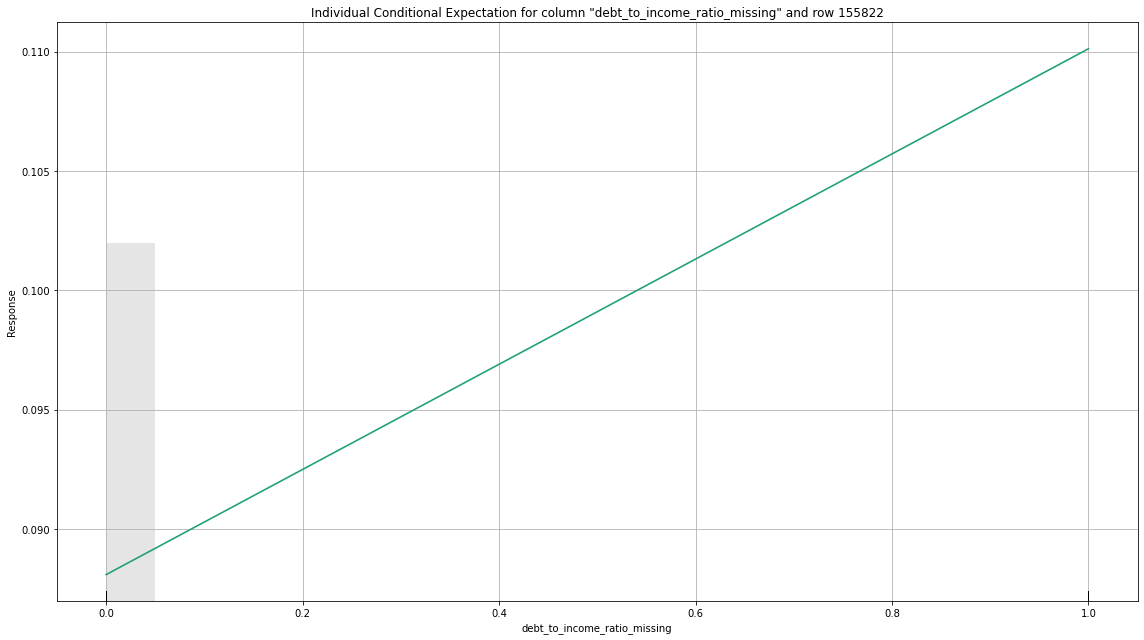

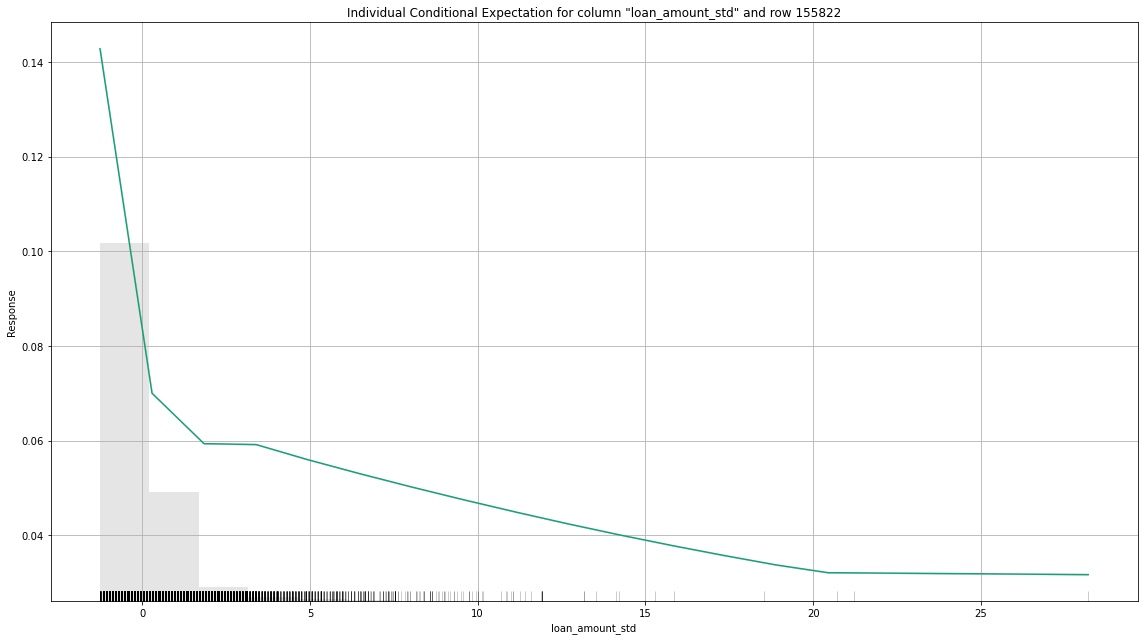

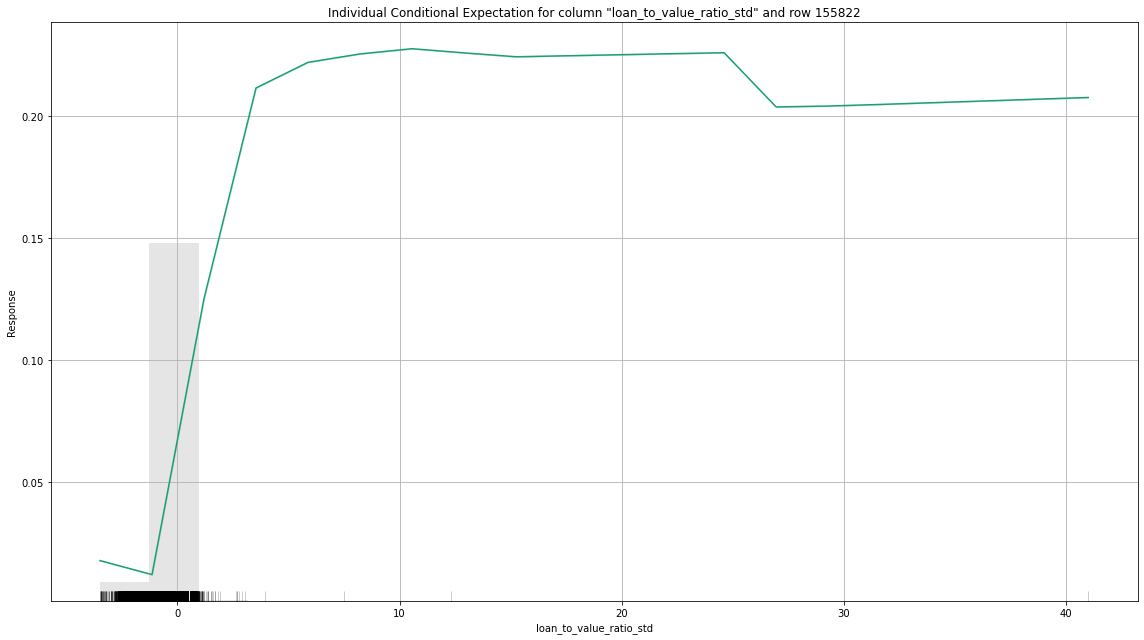

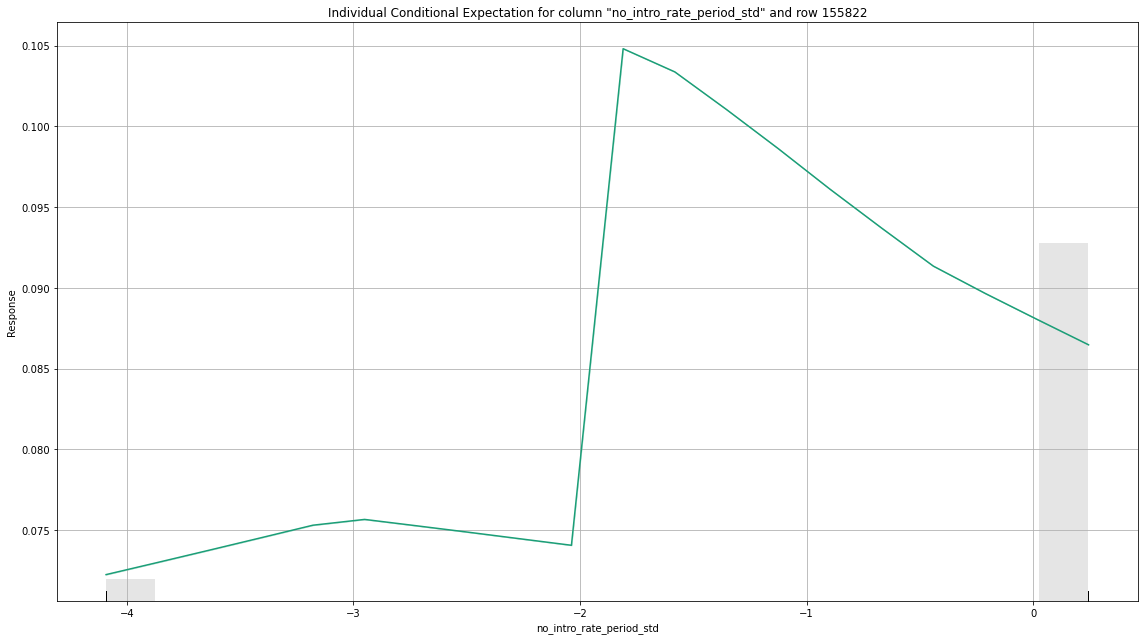

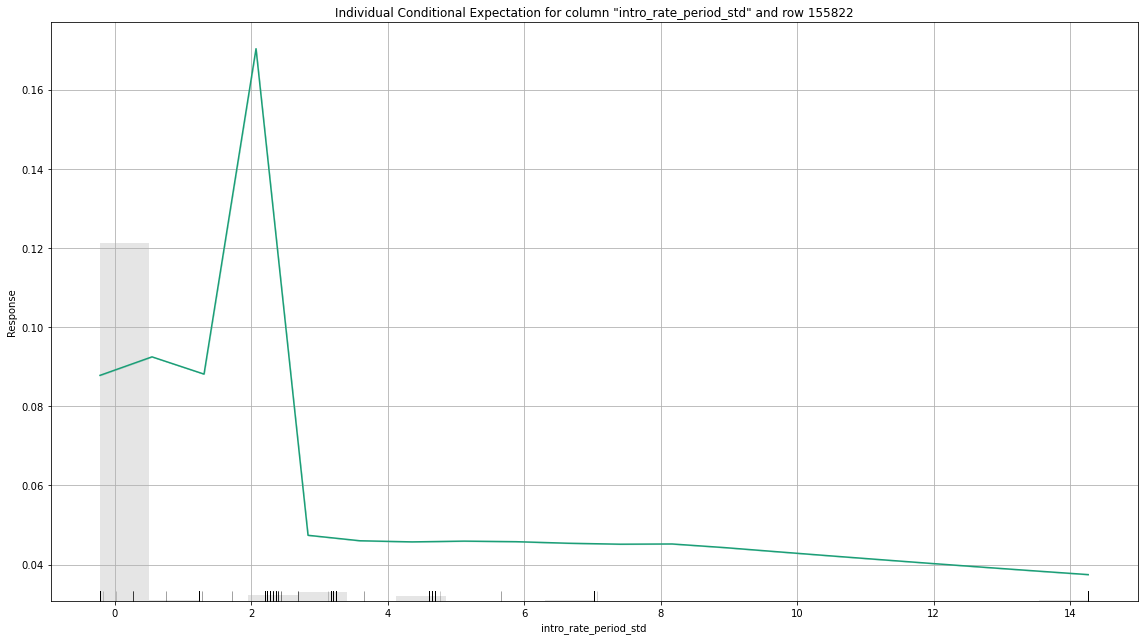

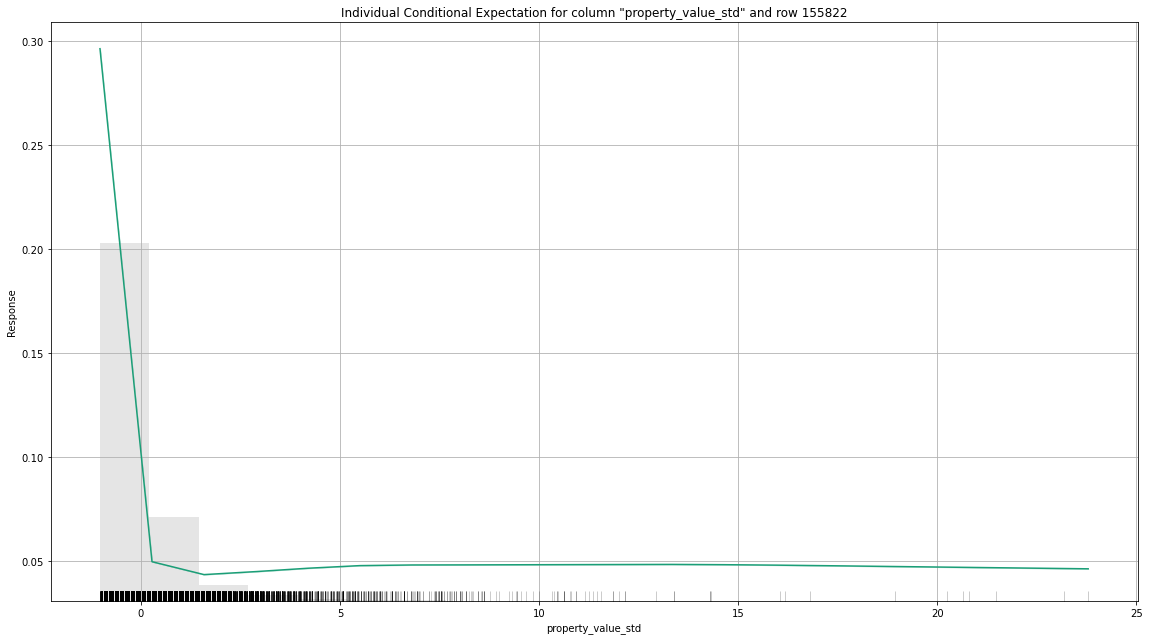

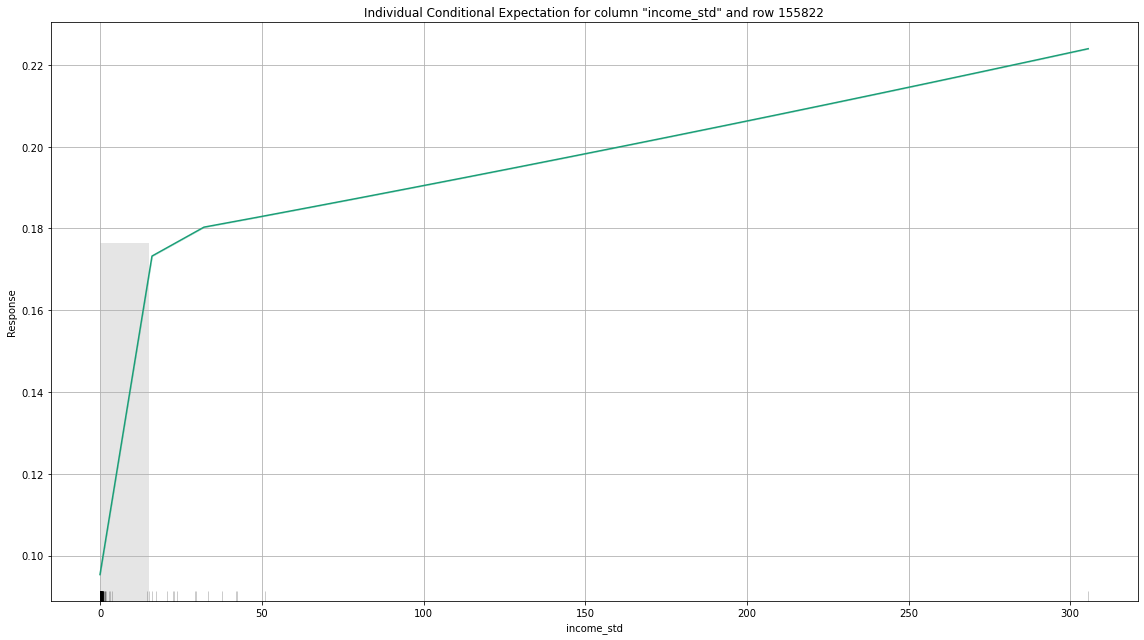

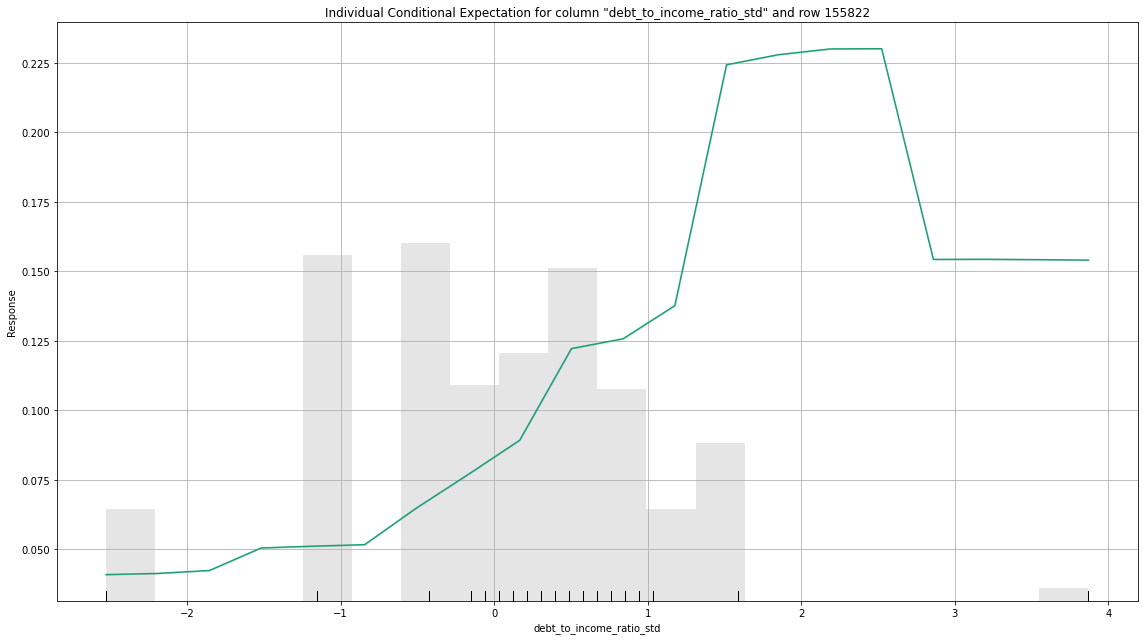

In [39]:
# Explain 10 percentile
ensenble_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[10]))


No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

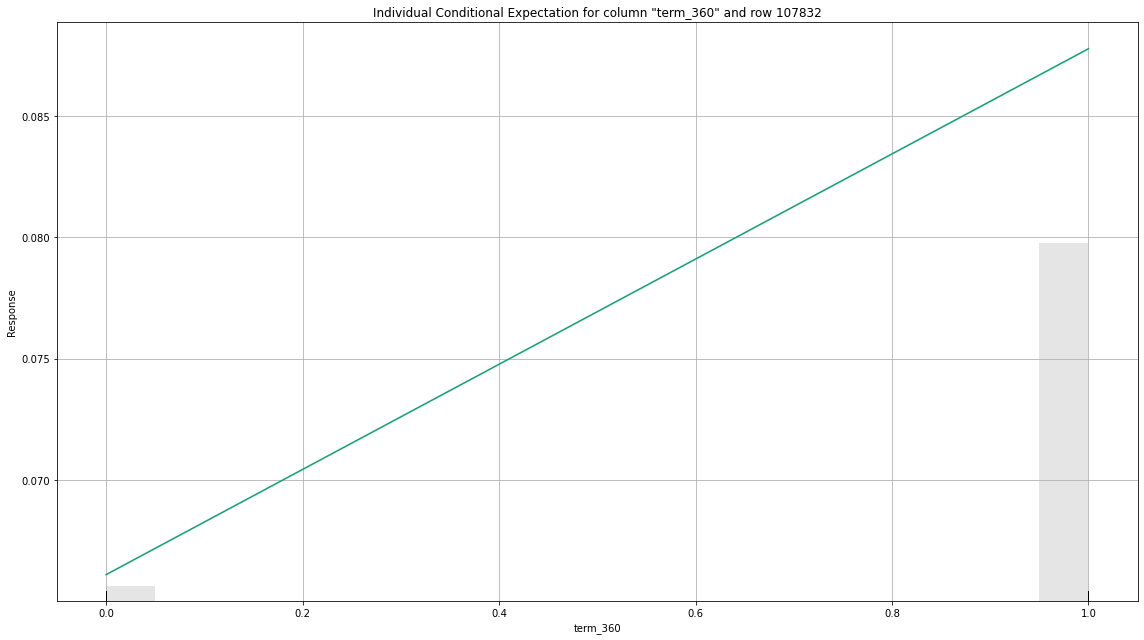

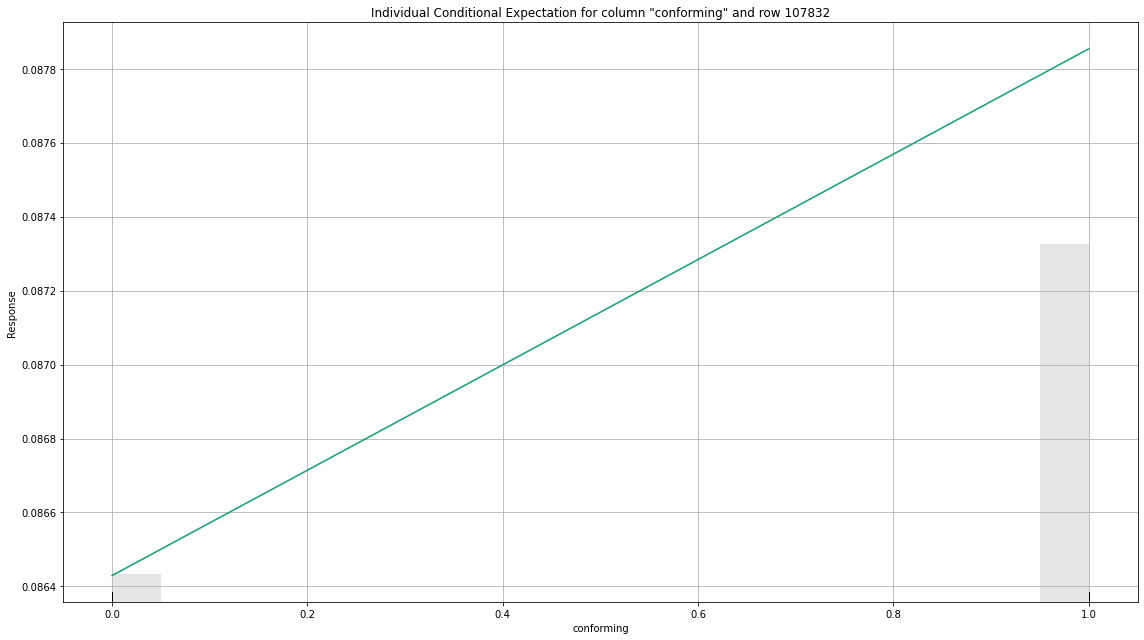

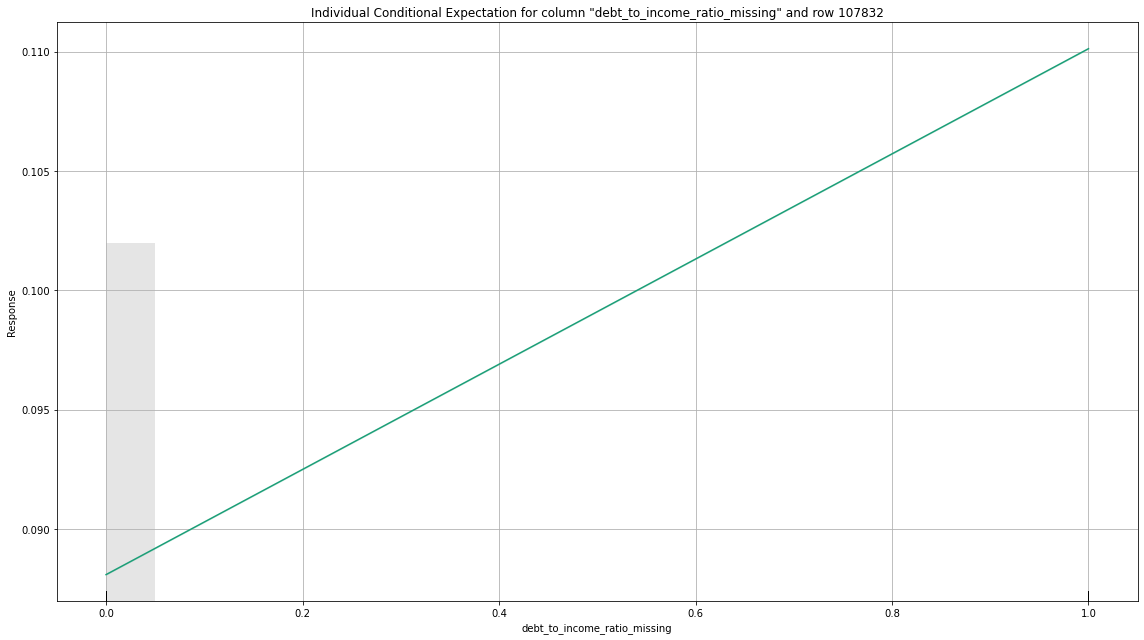

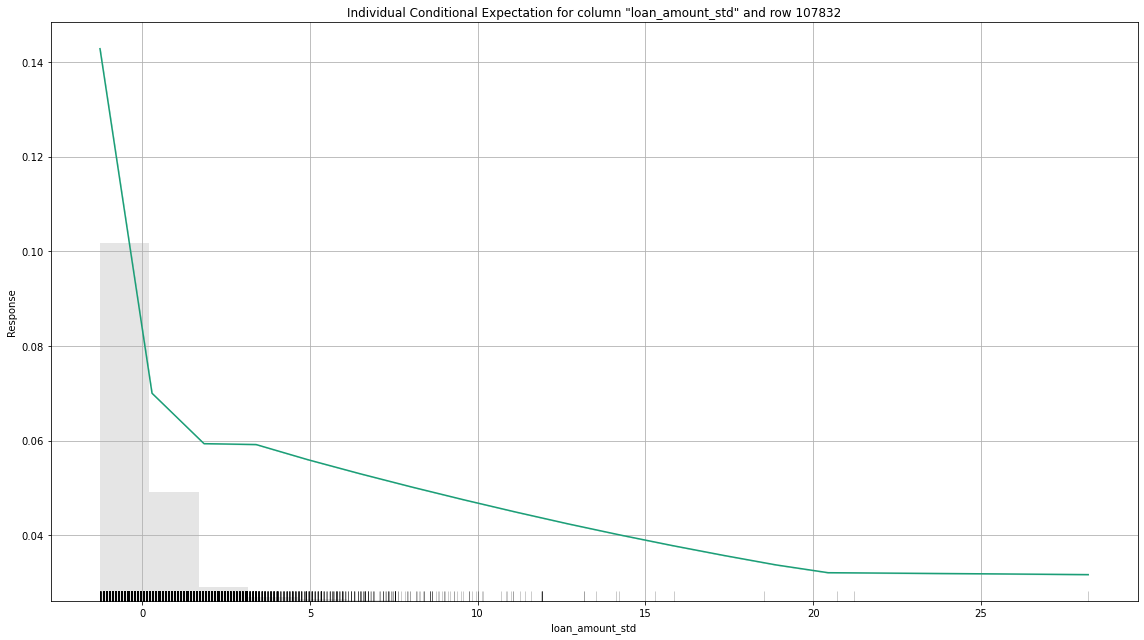

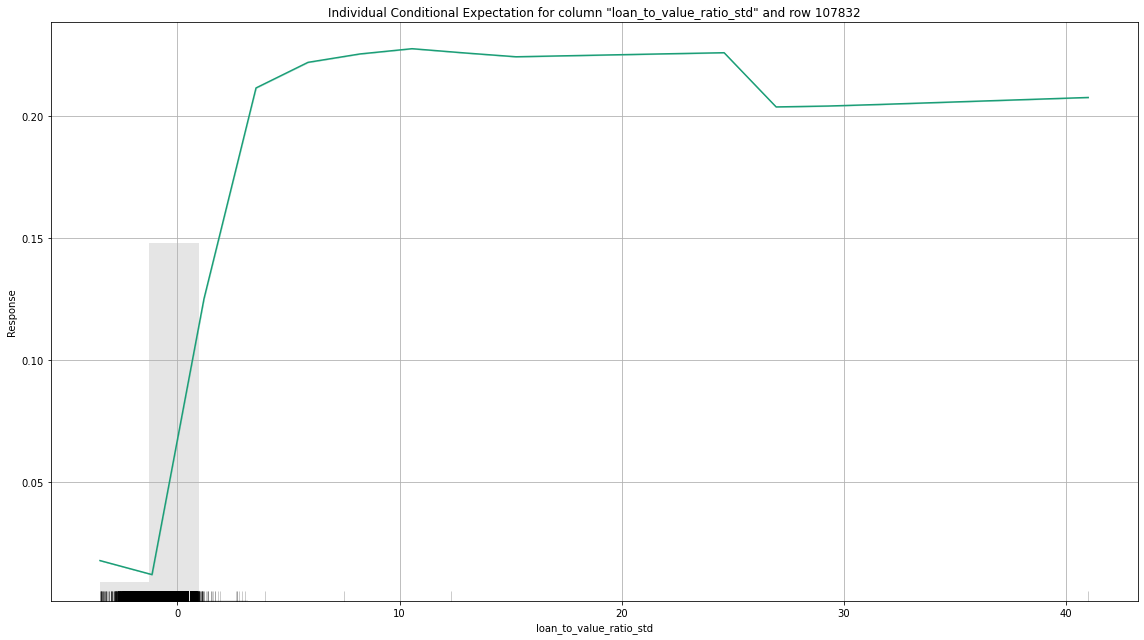

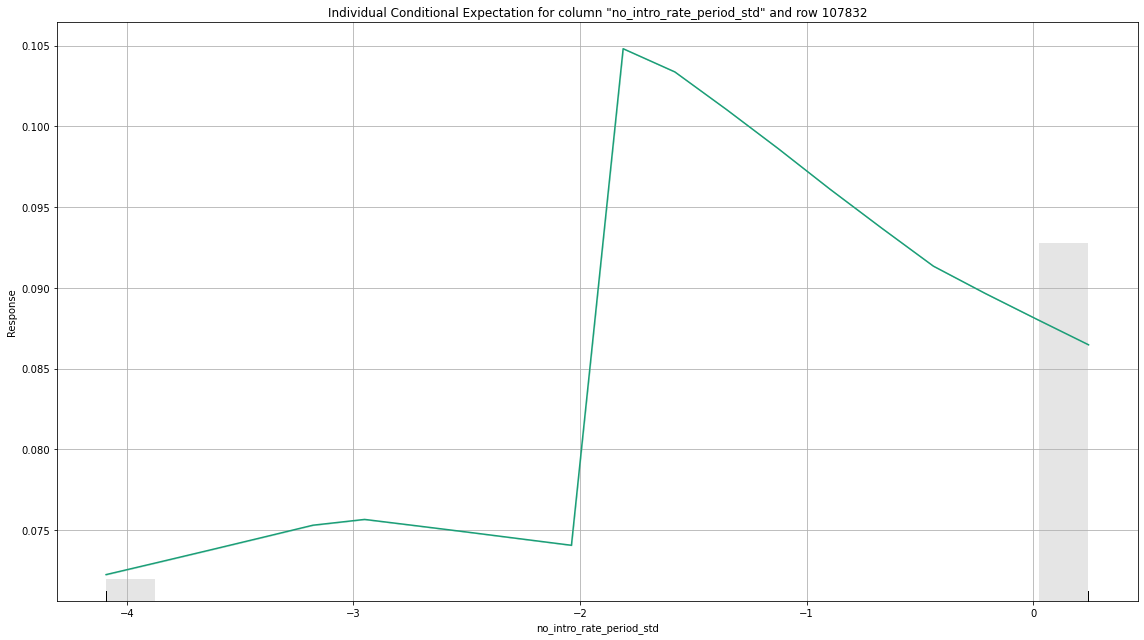

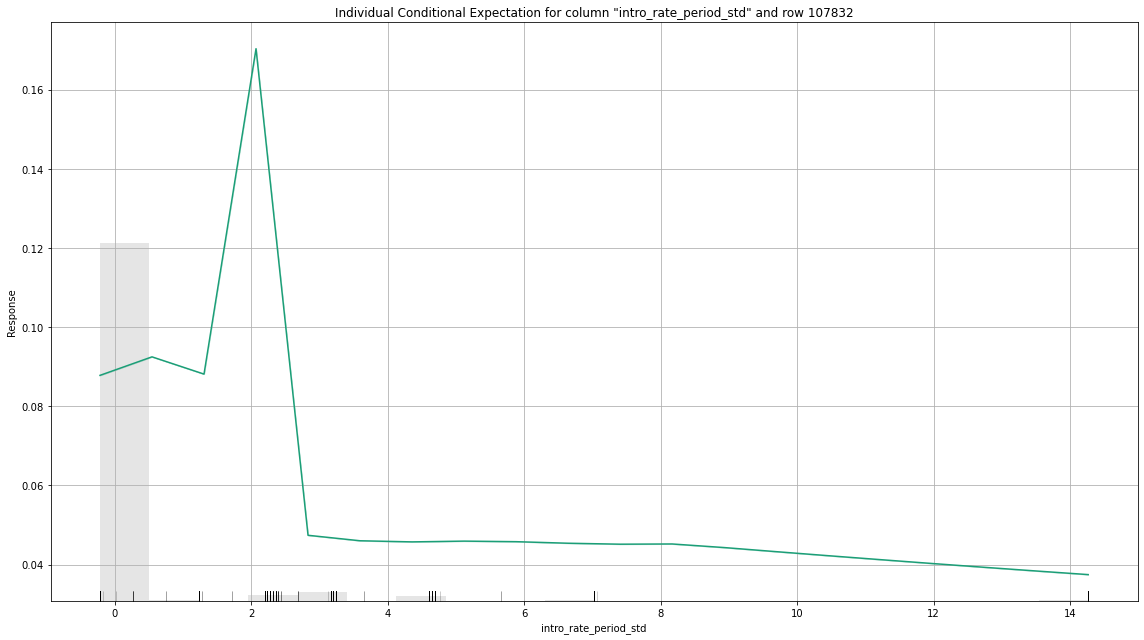

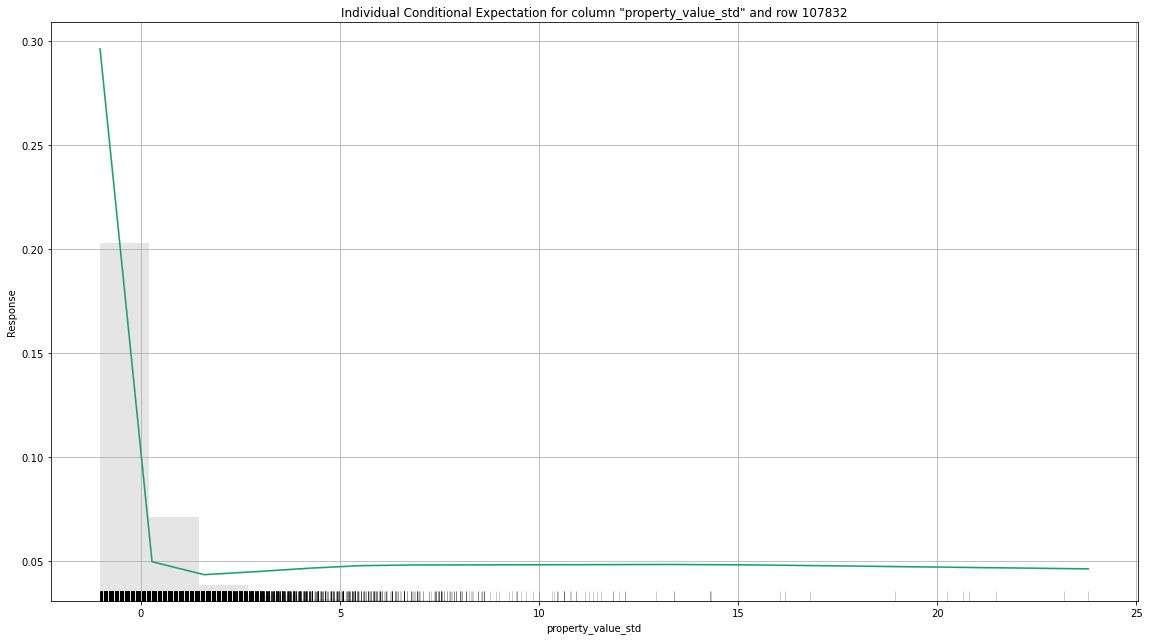

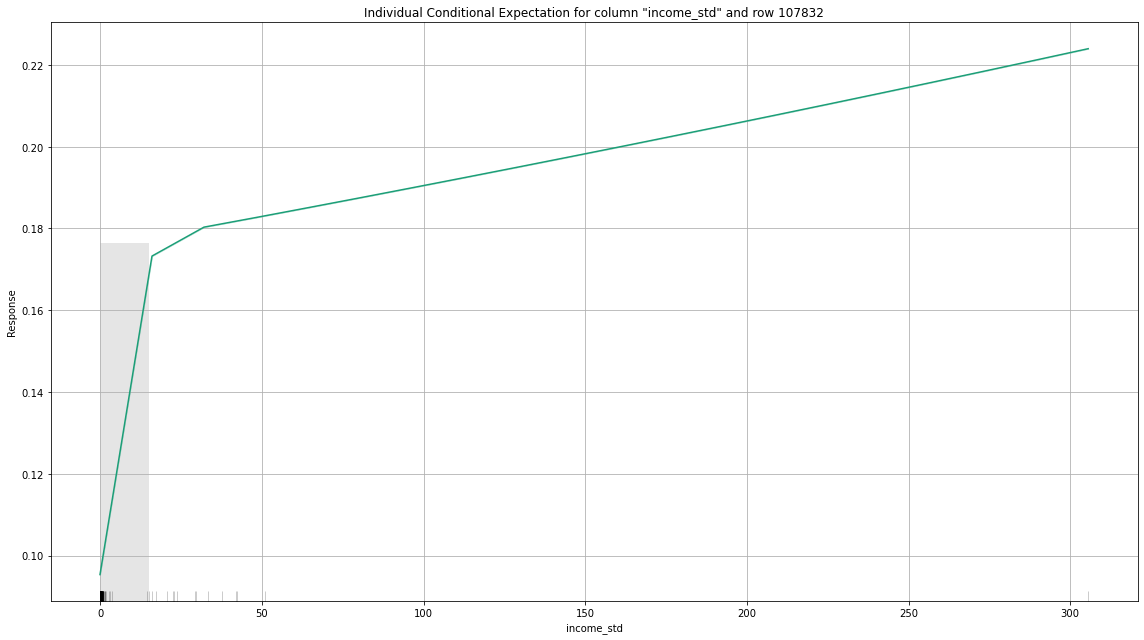

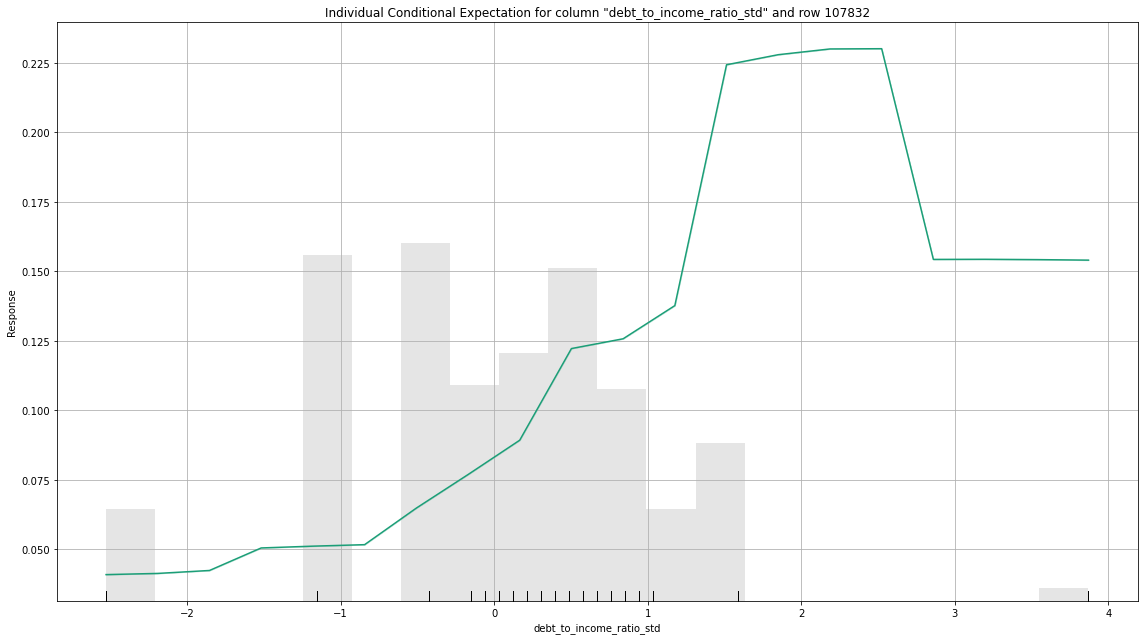

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

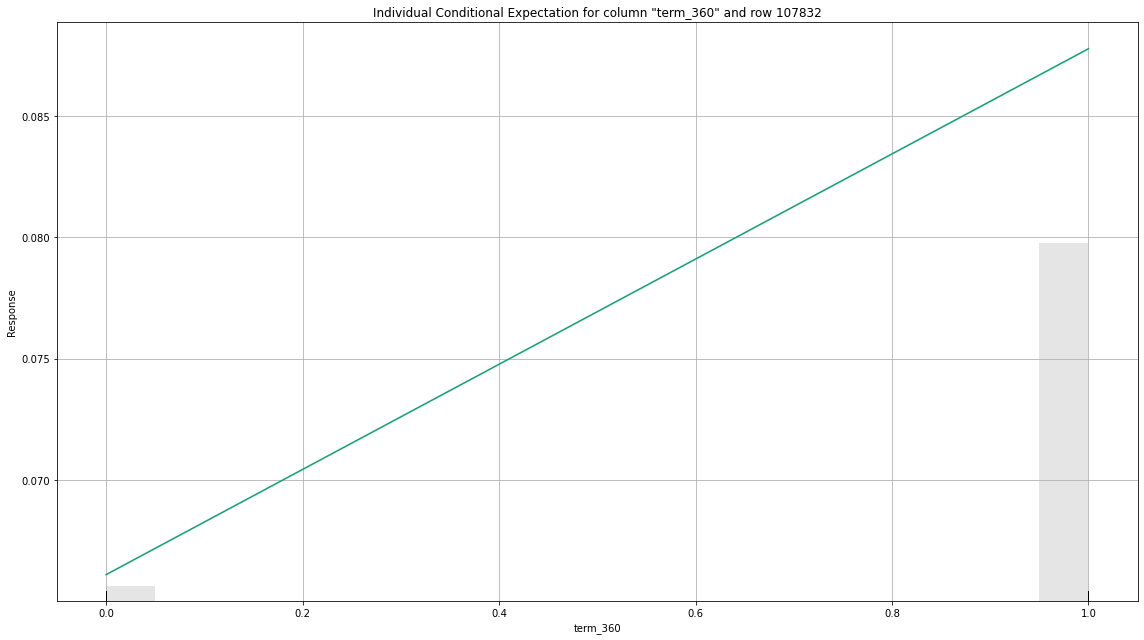

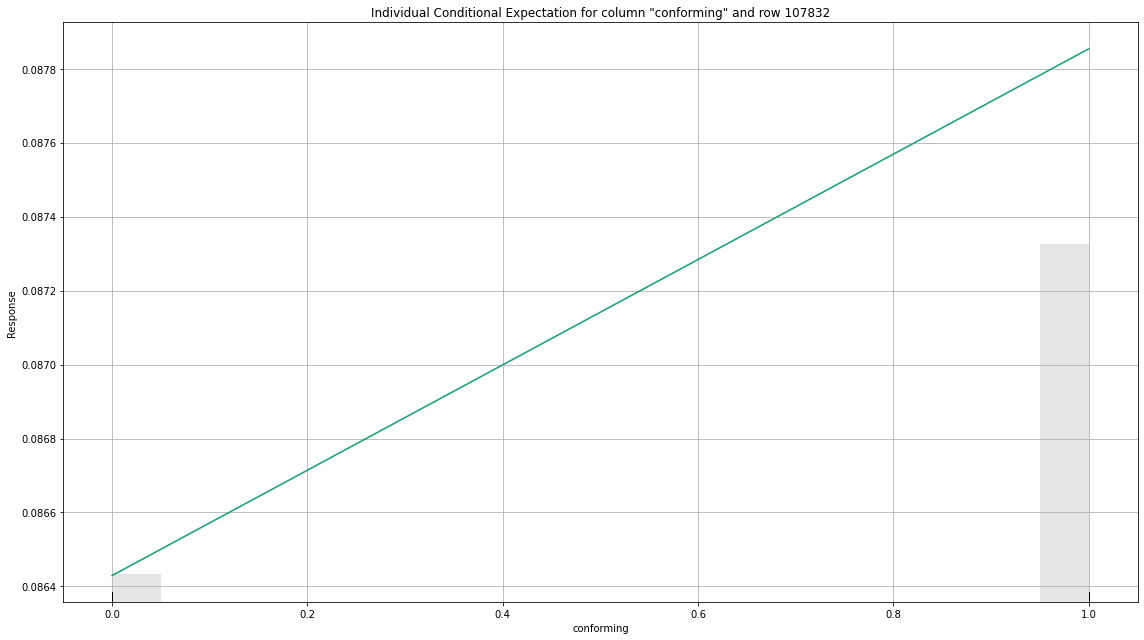

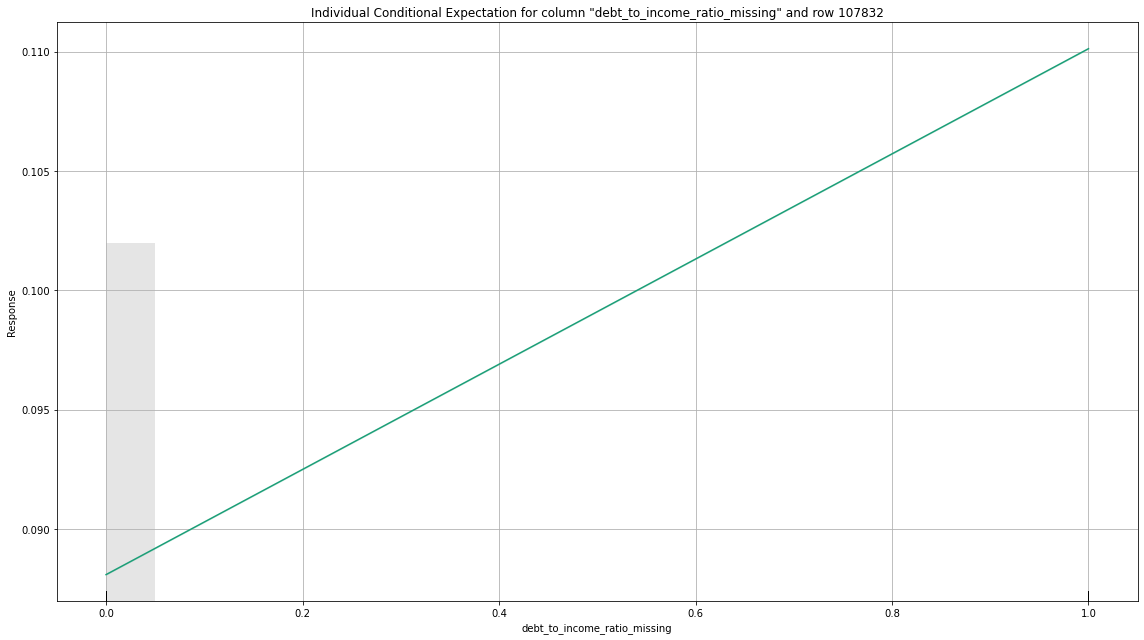

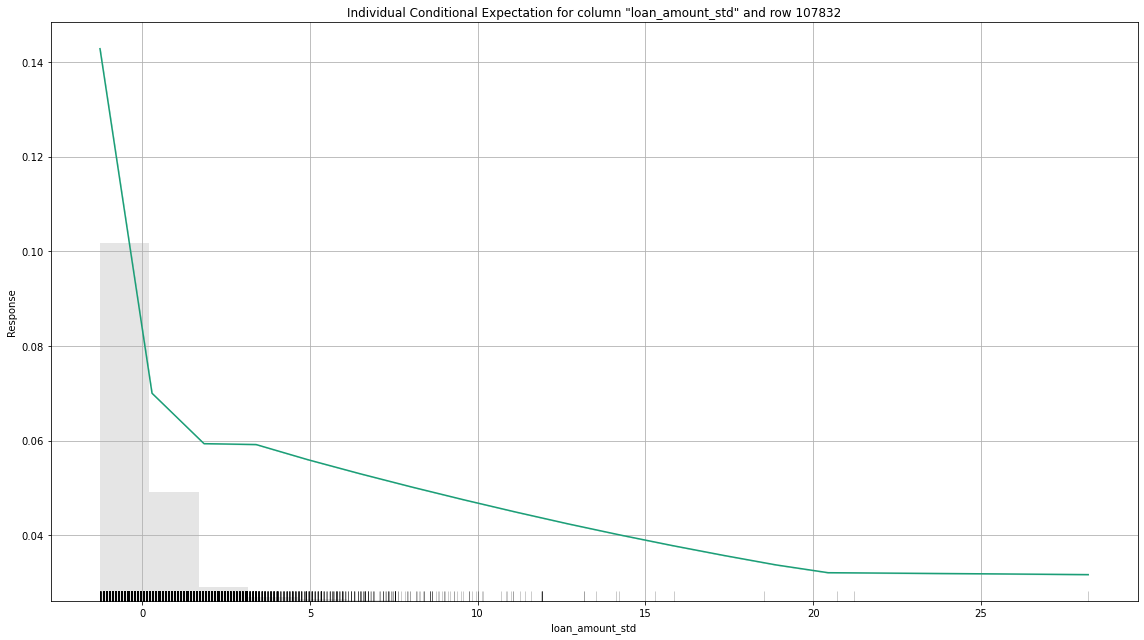

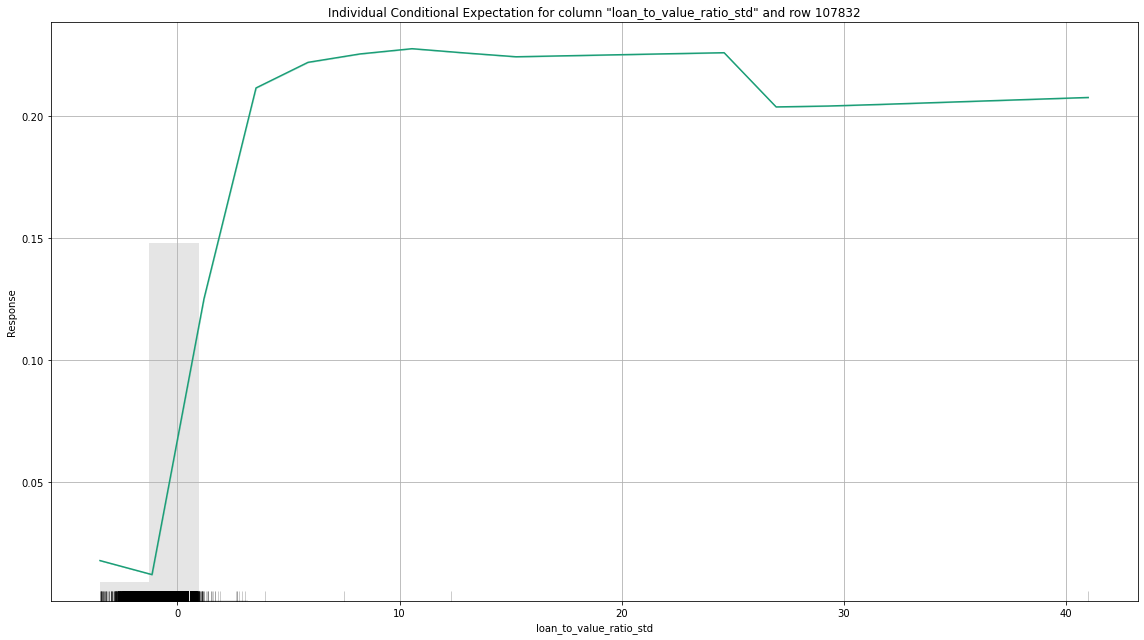

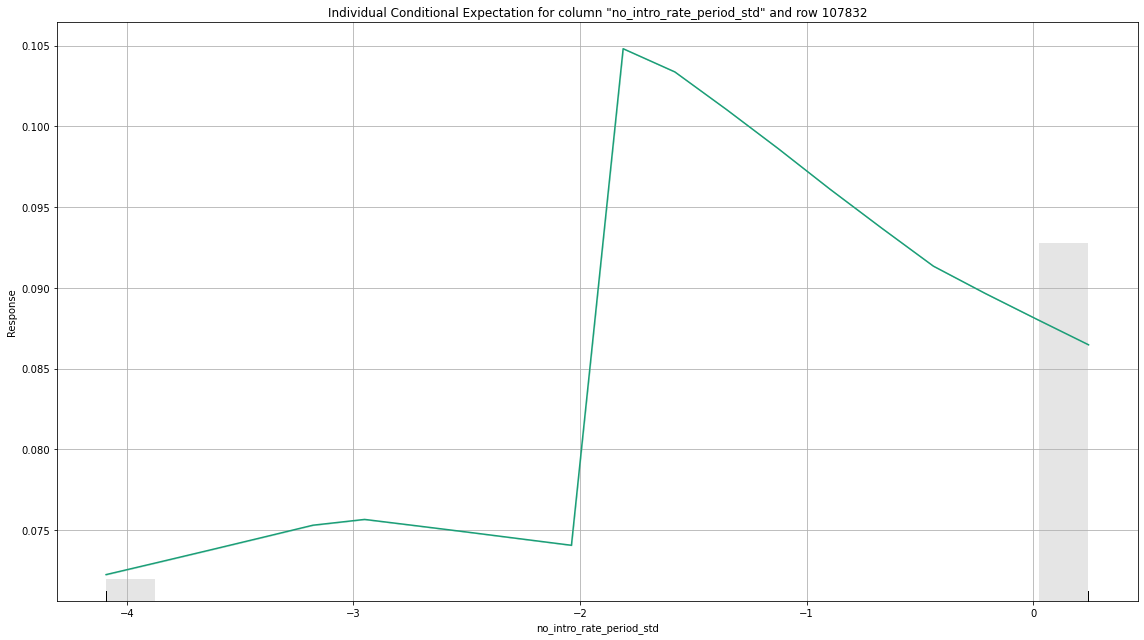

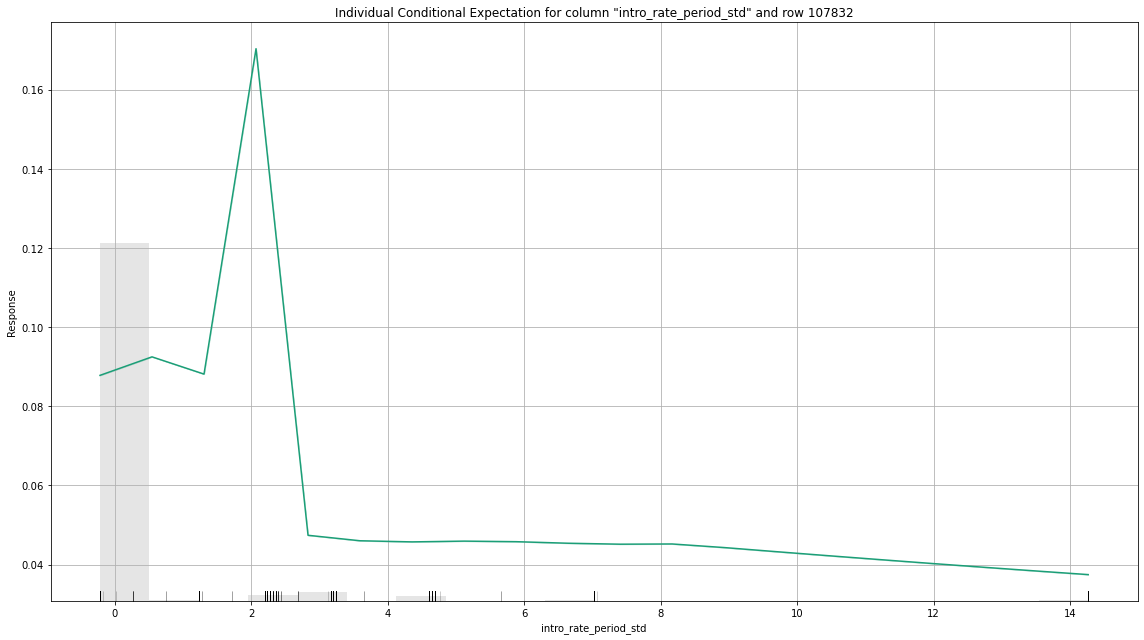

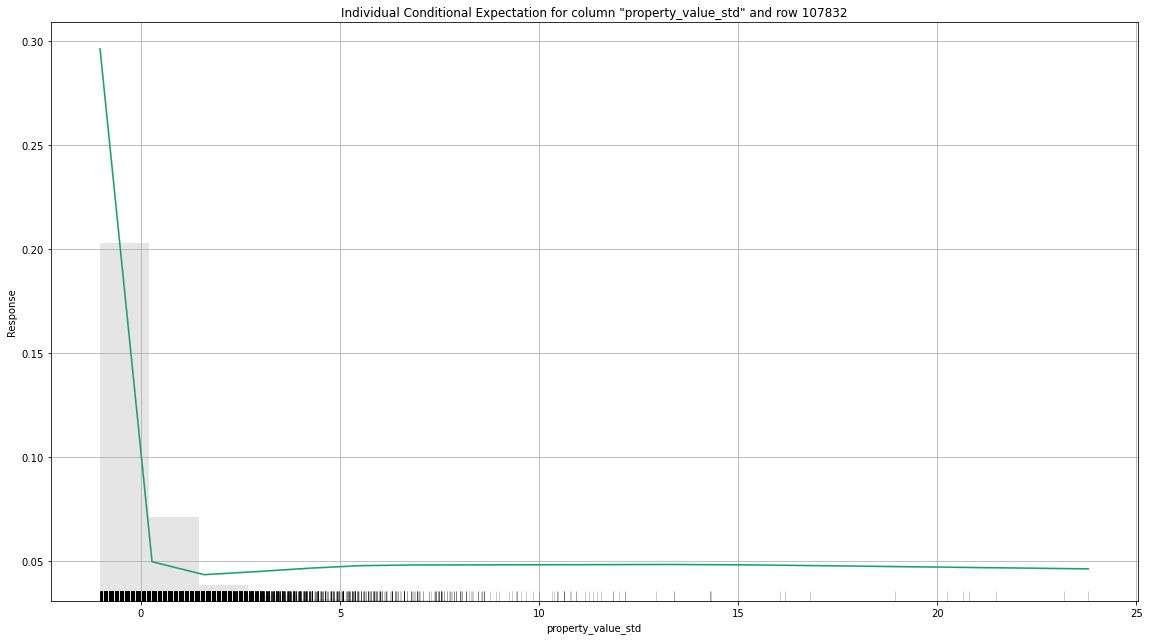

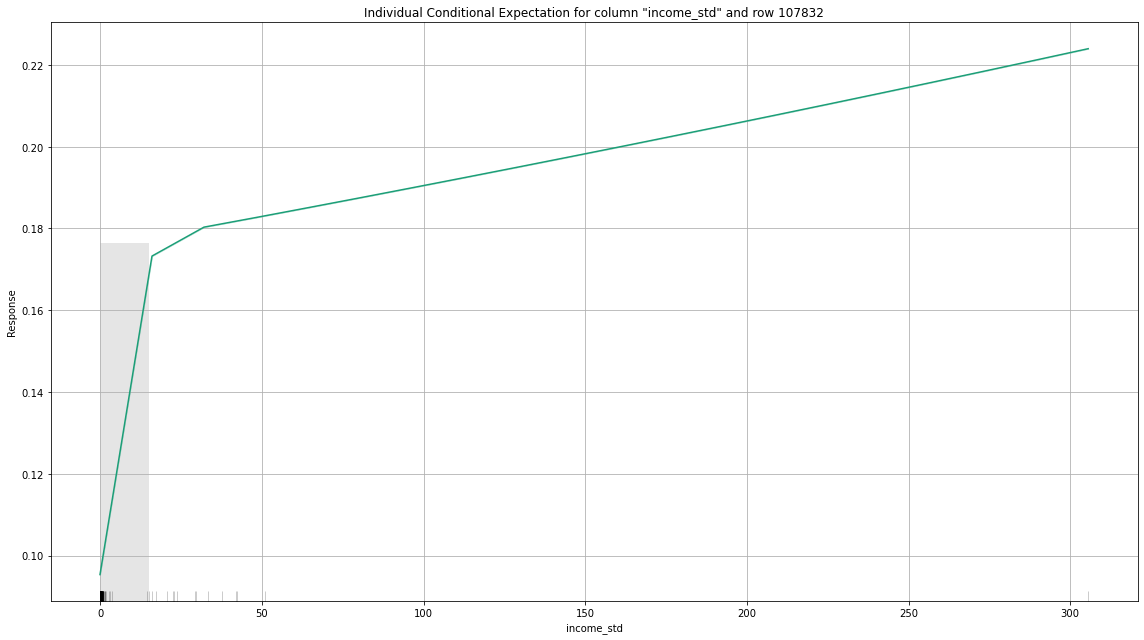

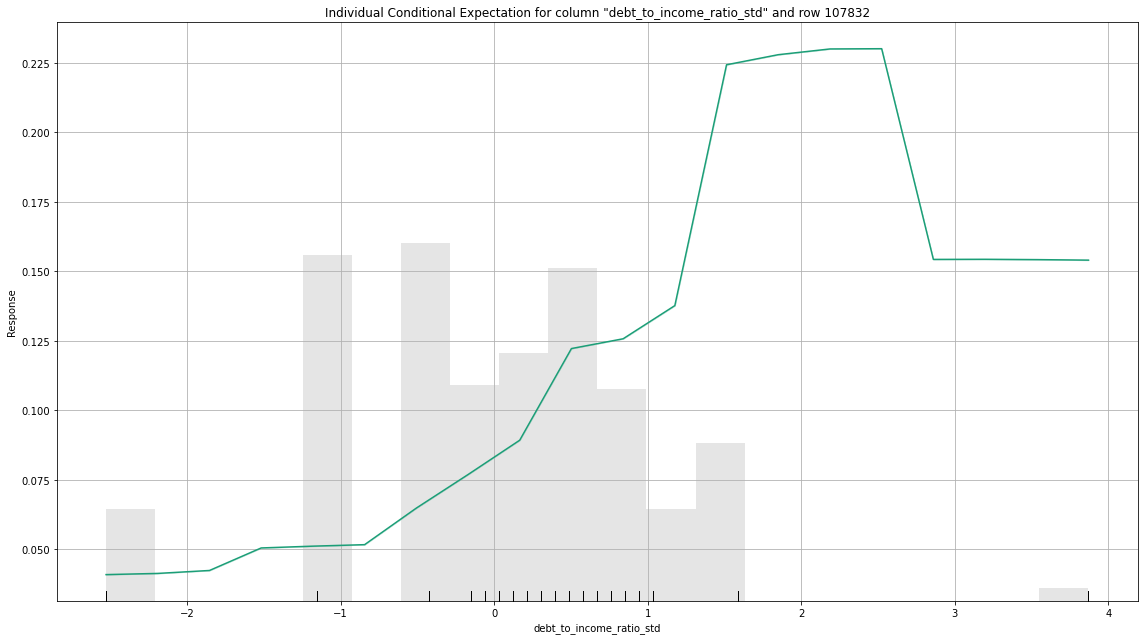

In [40]:
# Explain 50 percentile
ensenble_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[50]))

No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

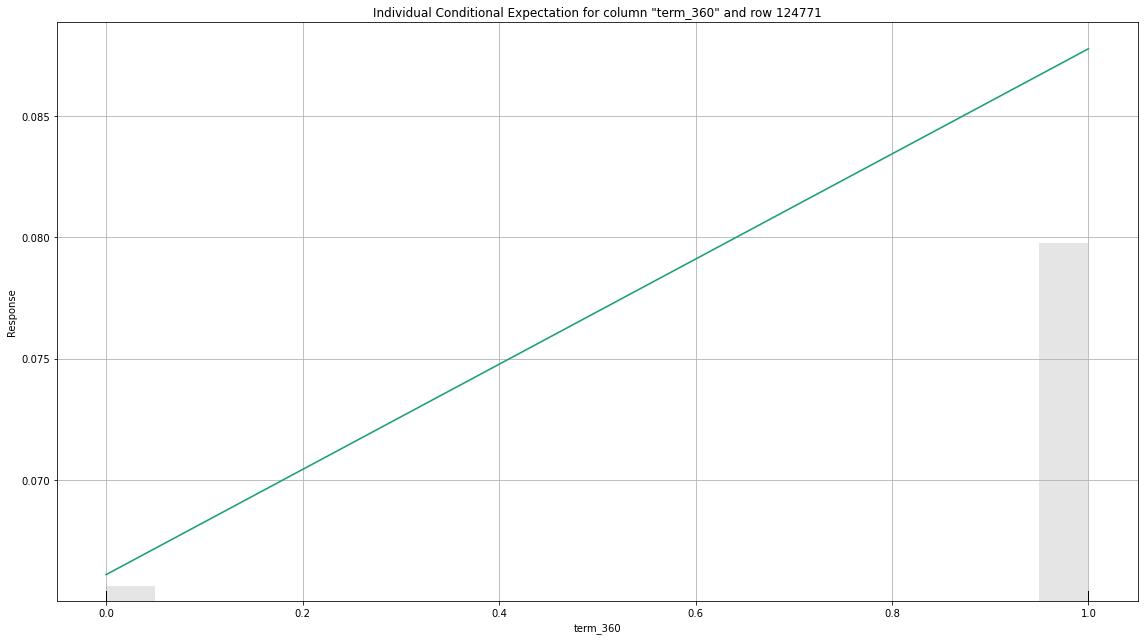

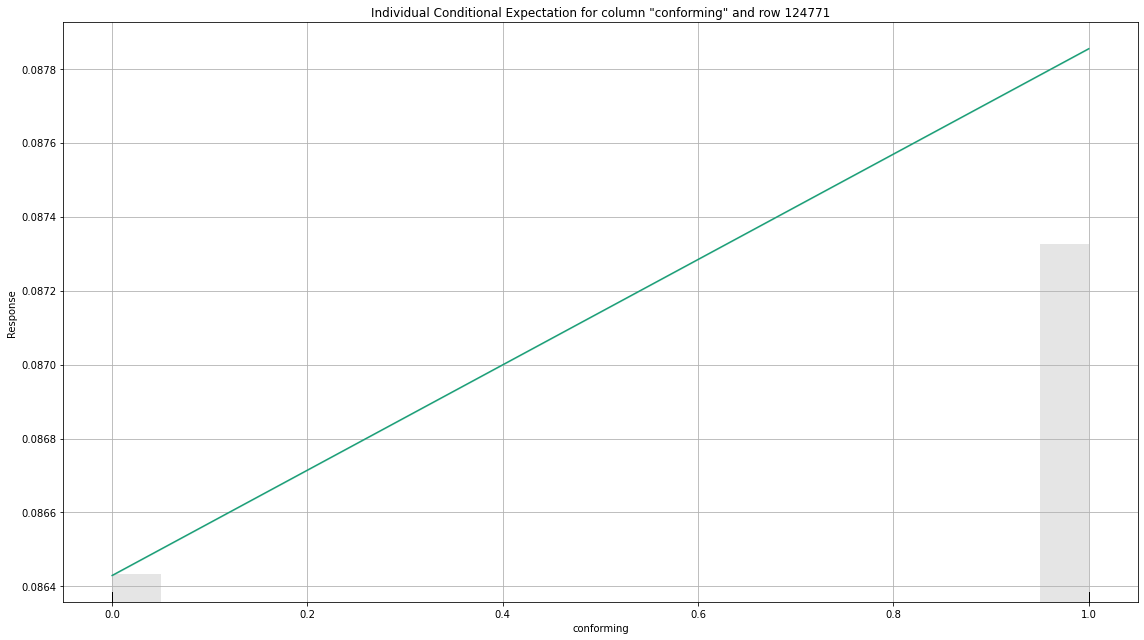

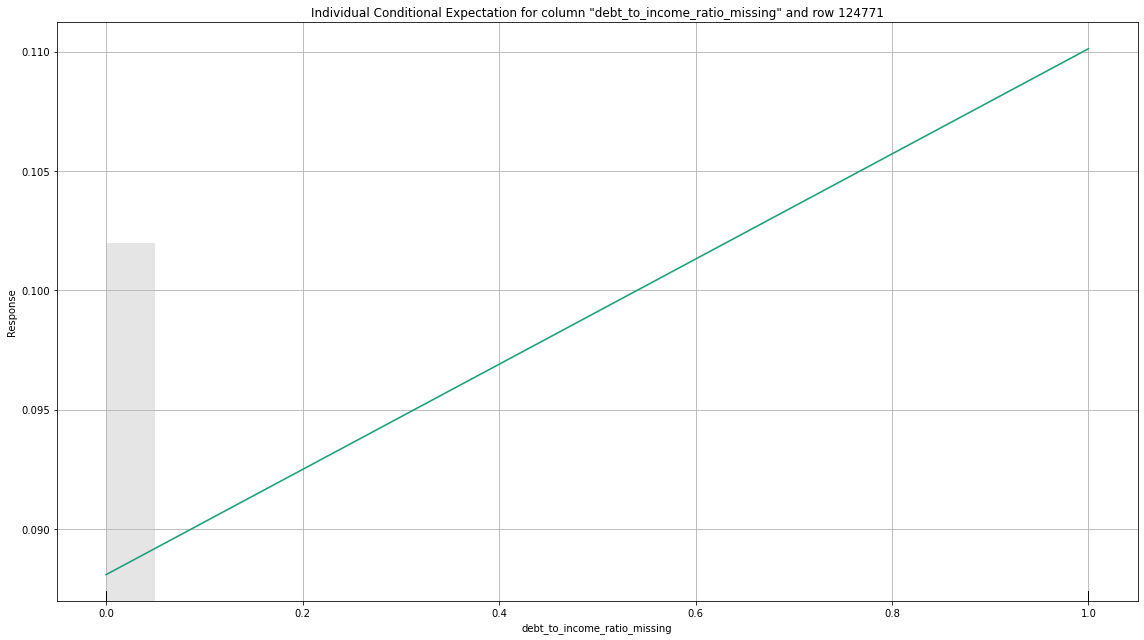

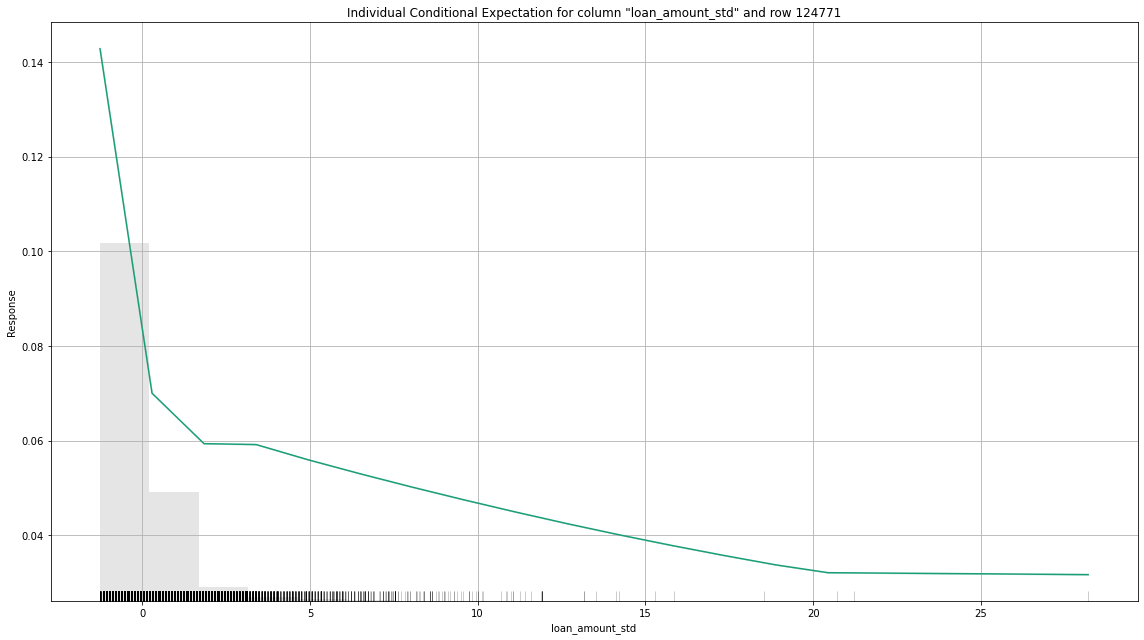

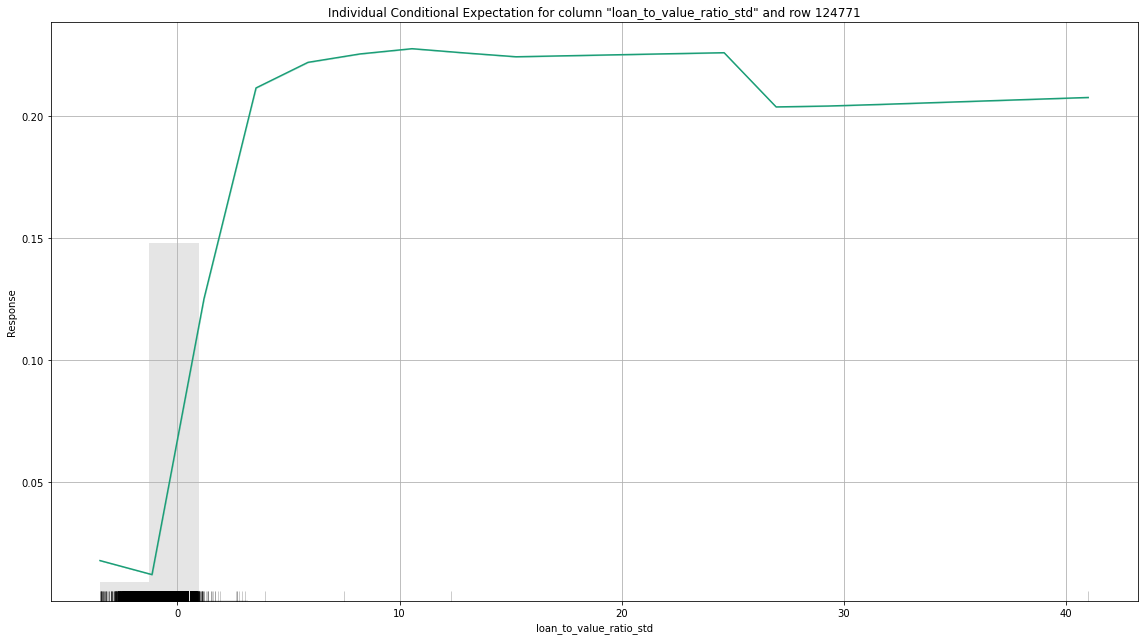

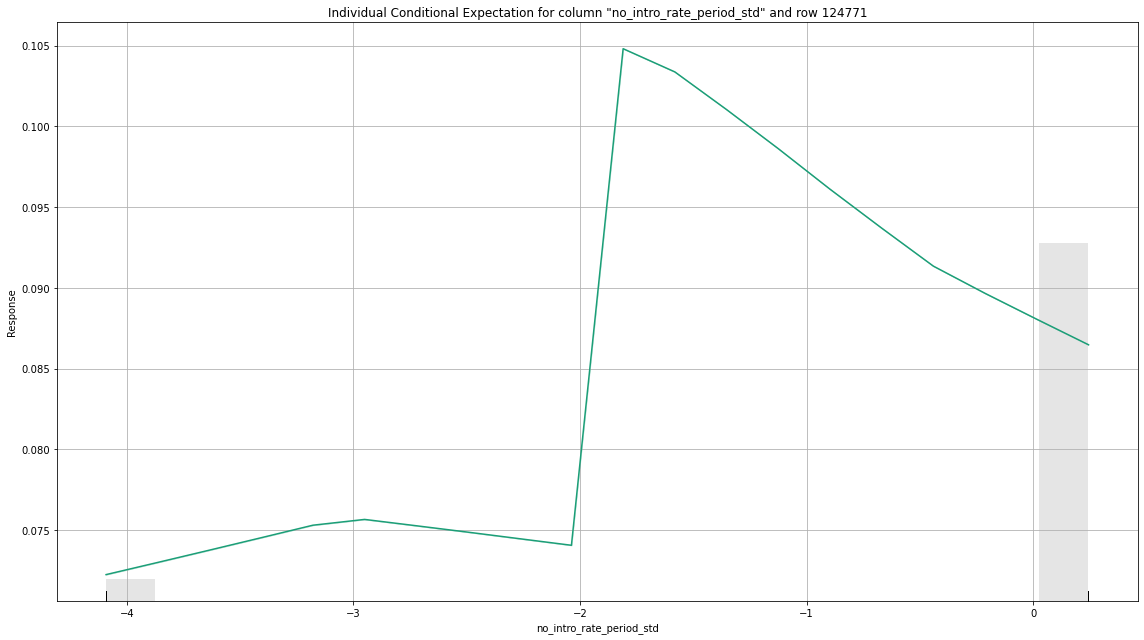

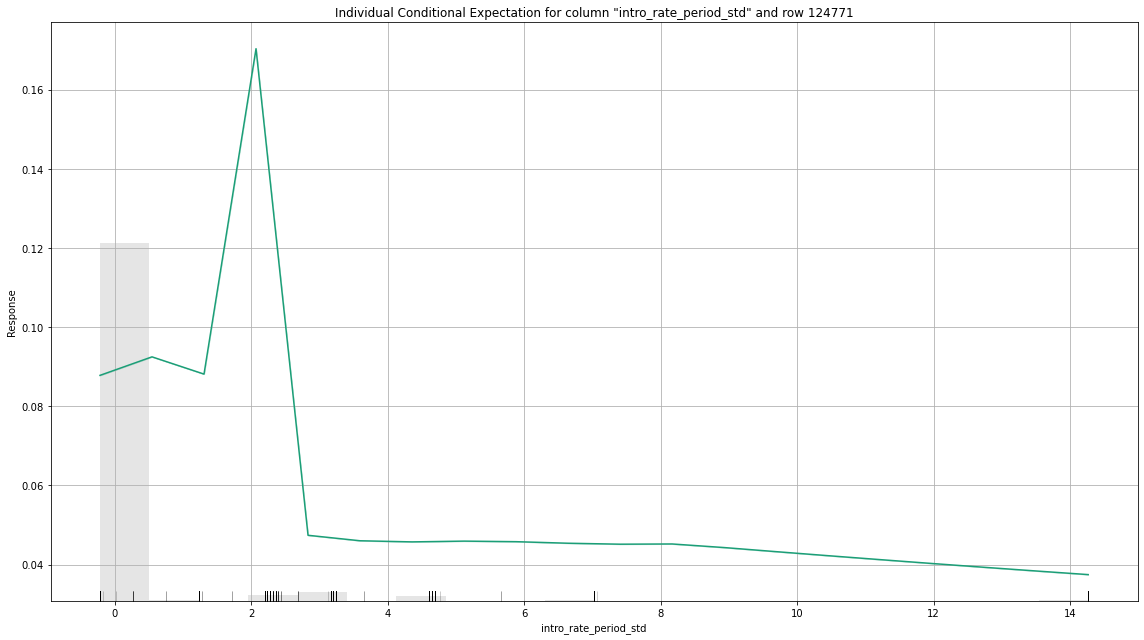

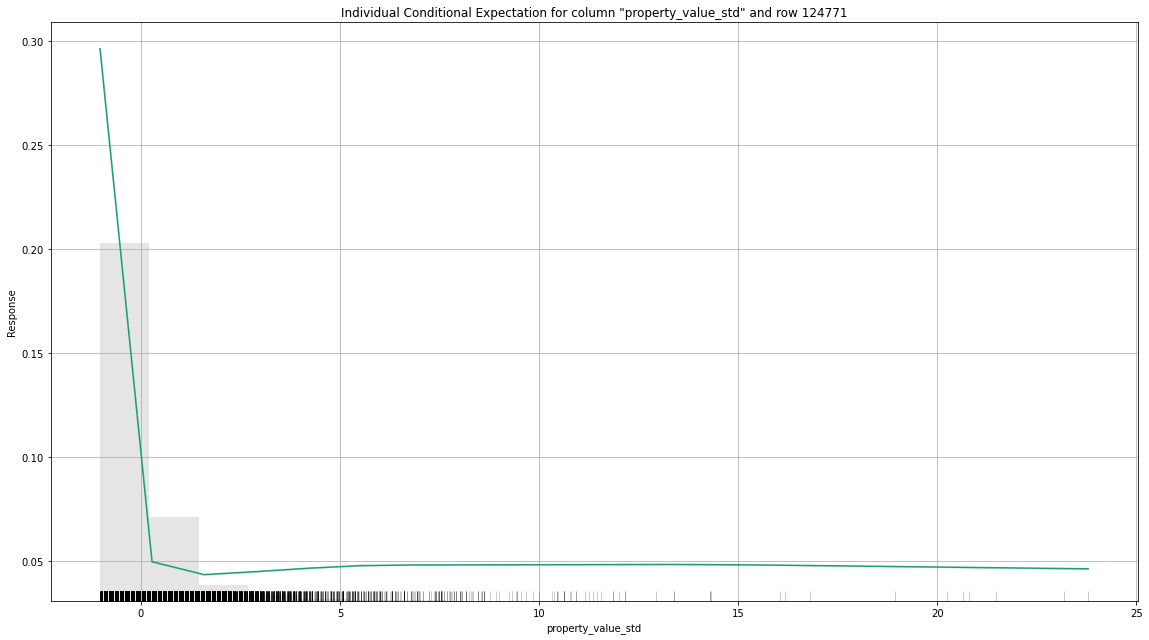

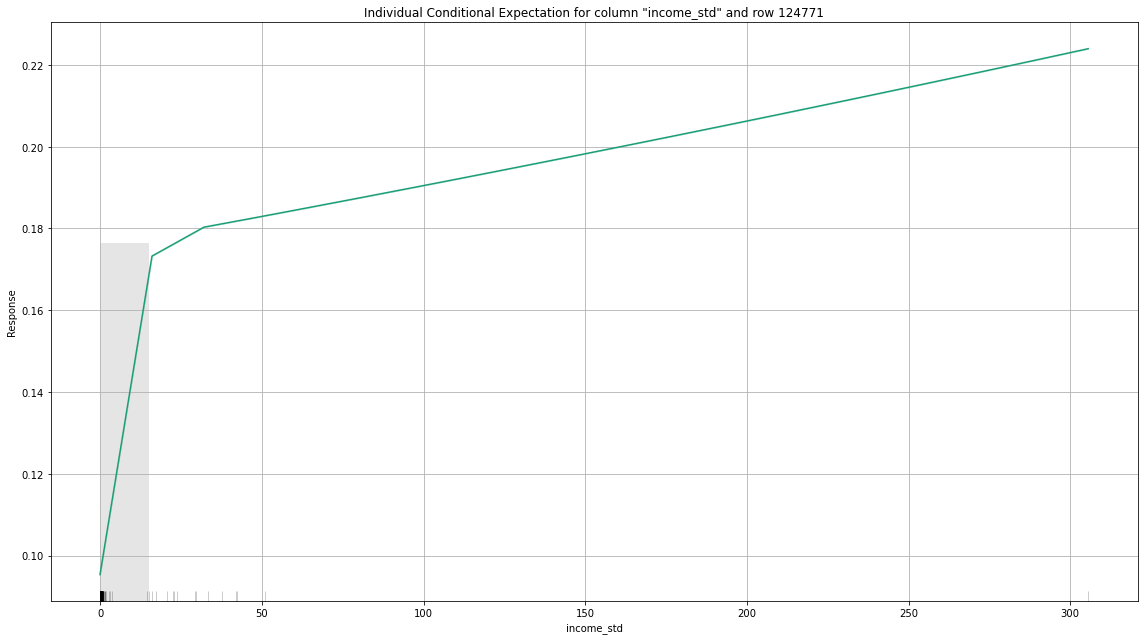

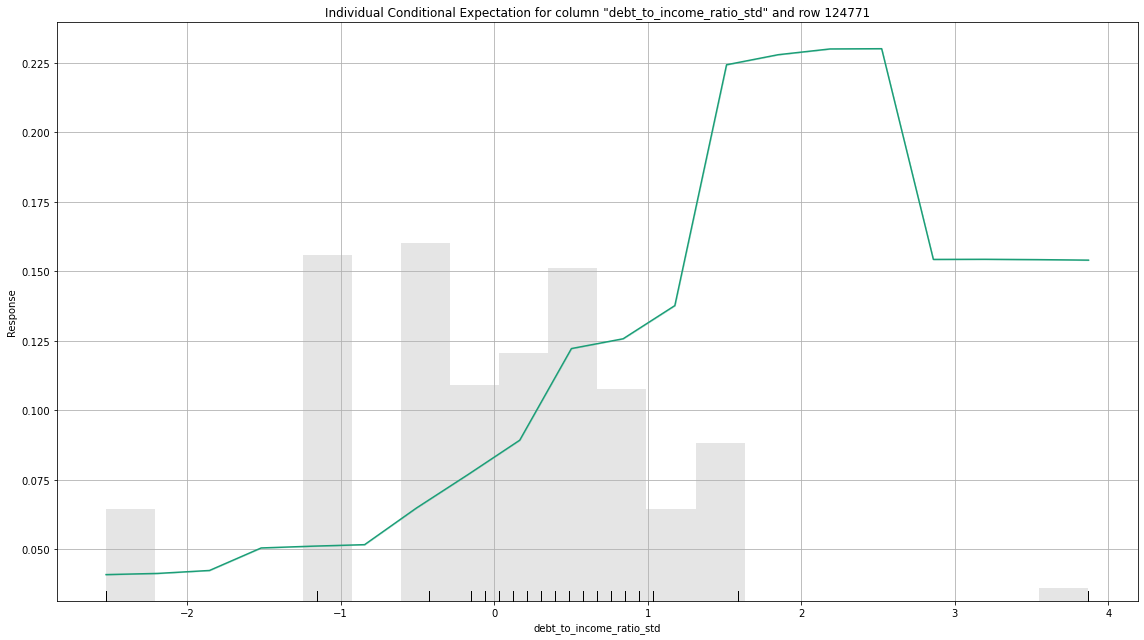

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

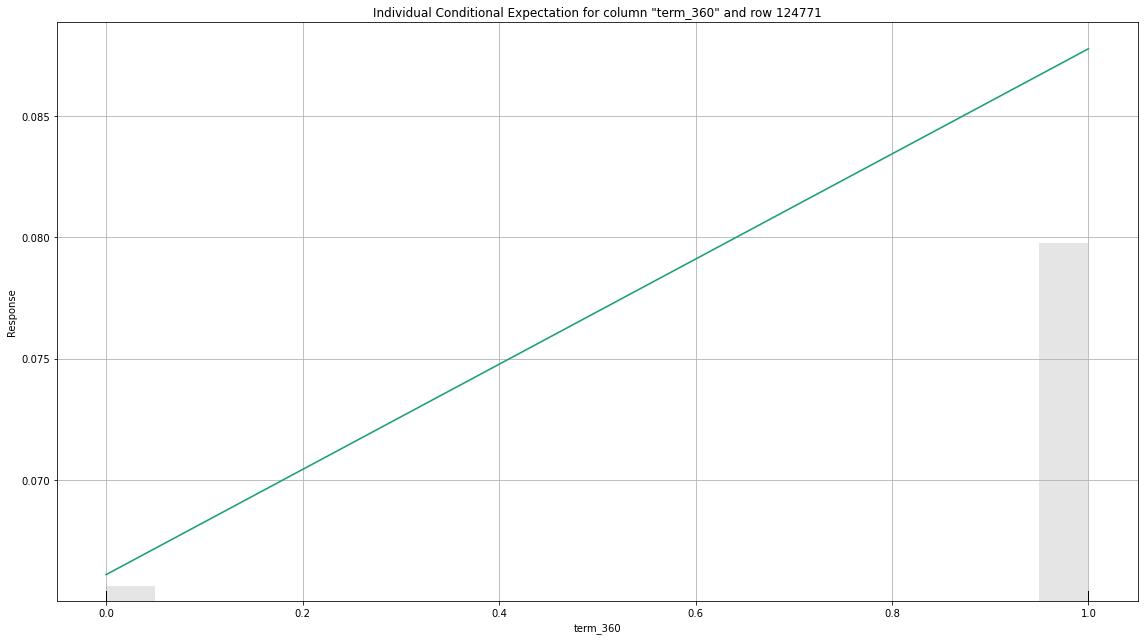

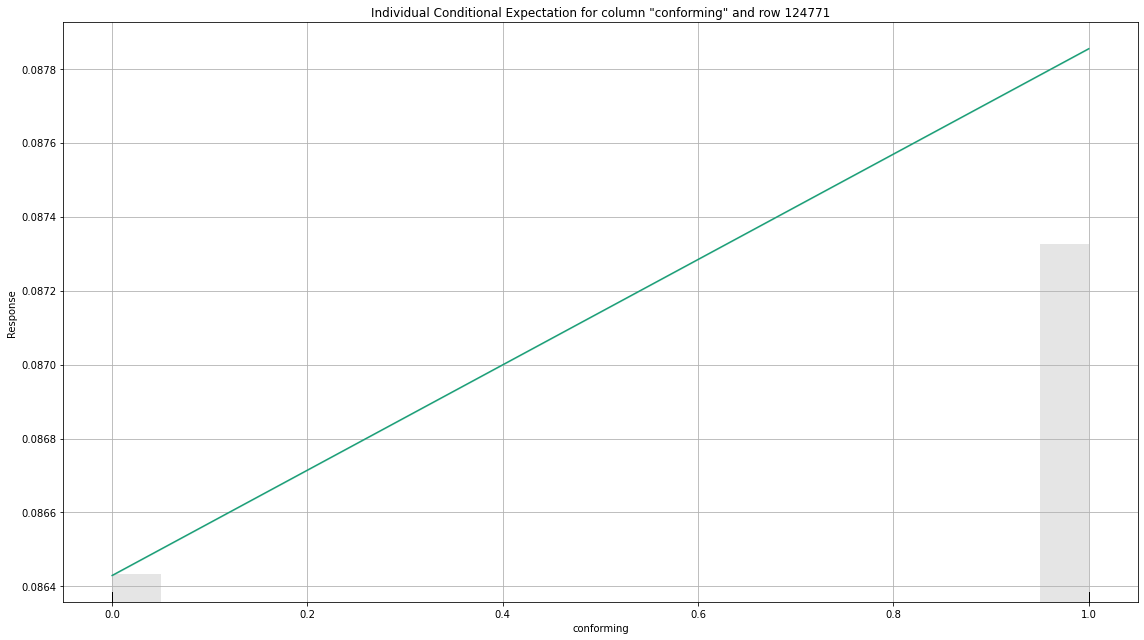

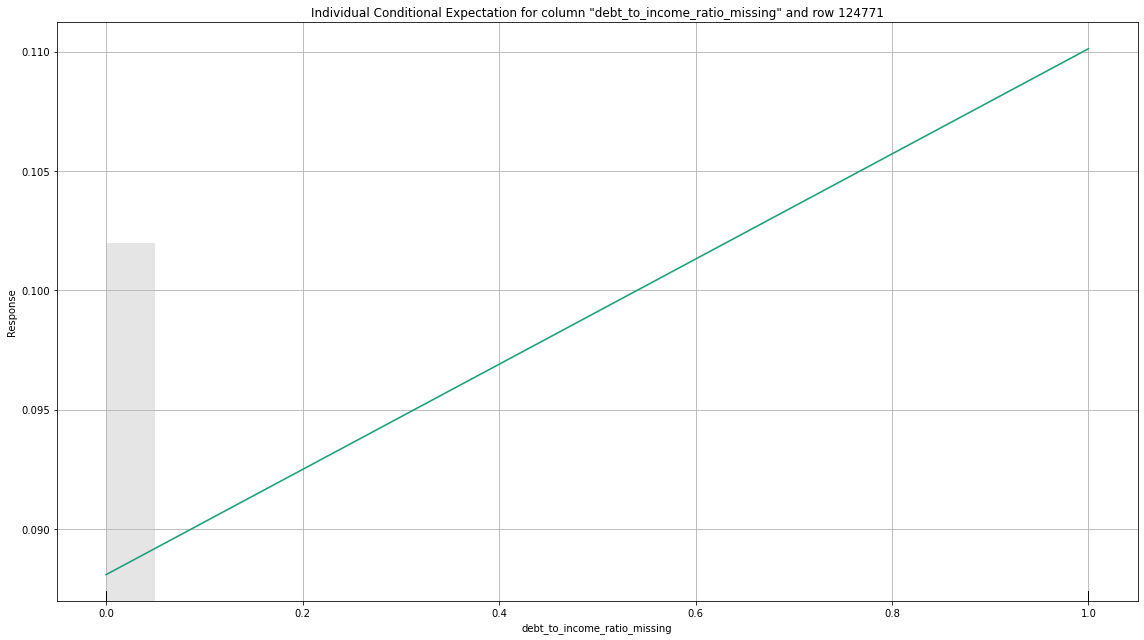

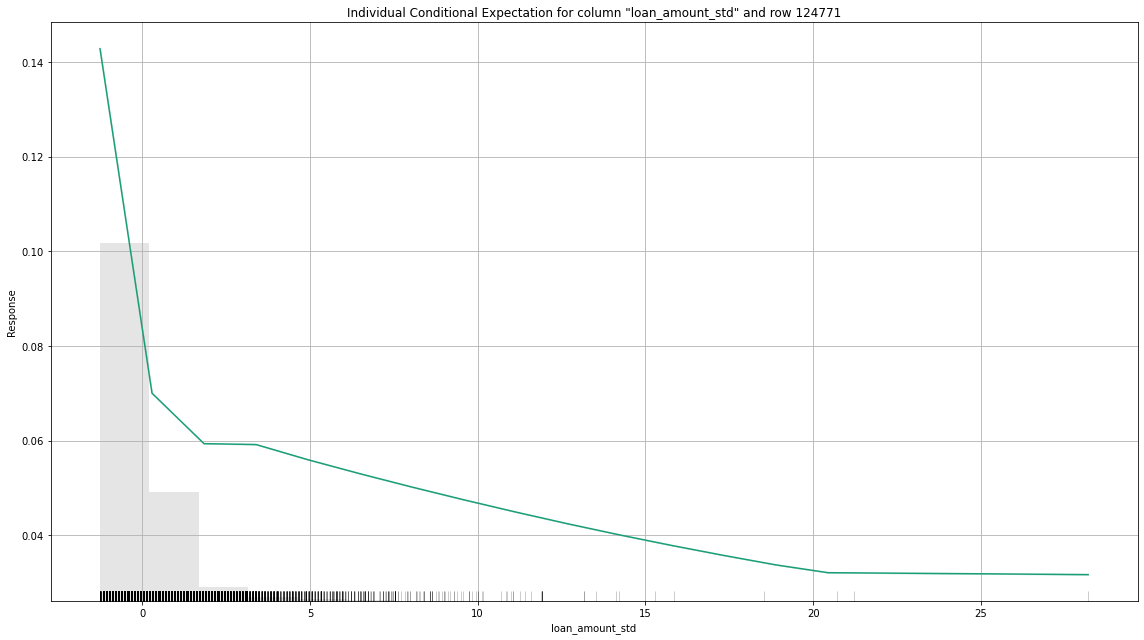

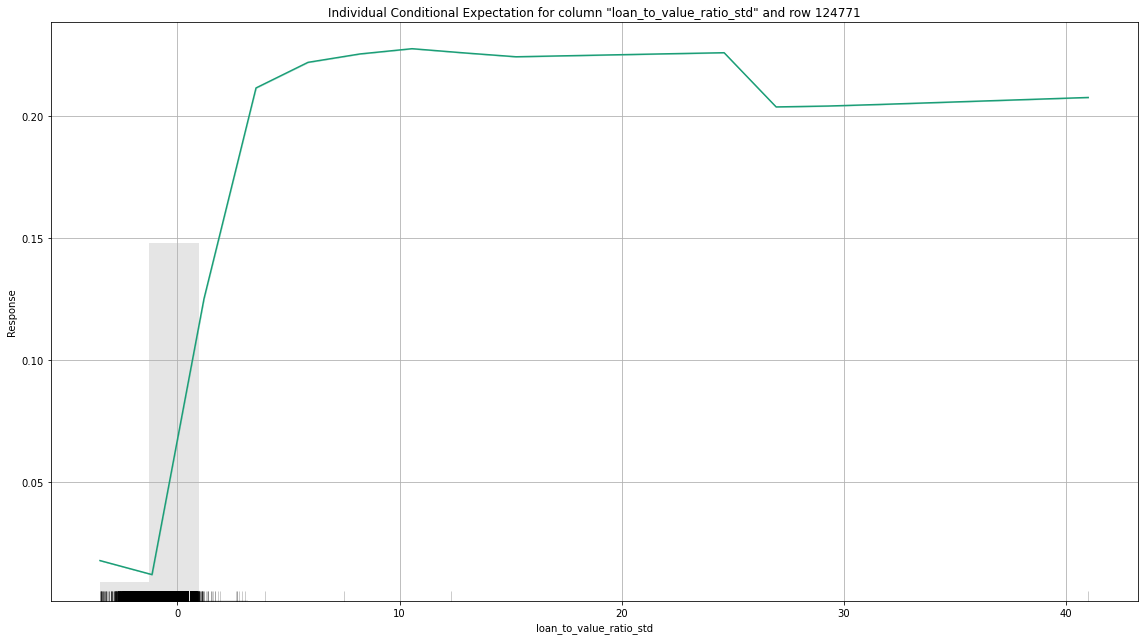

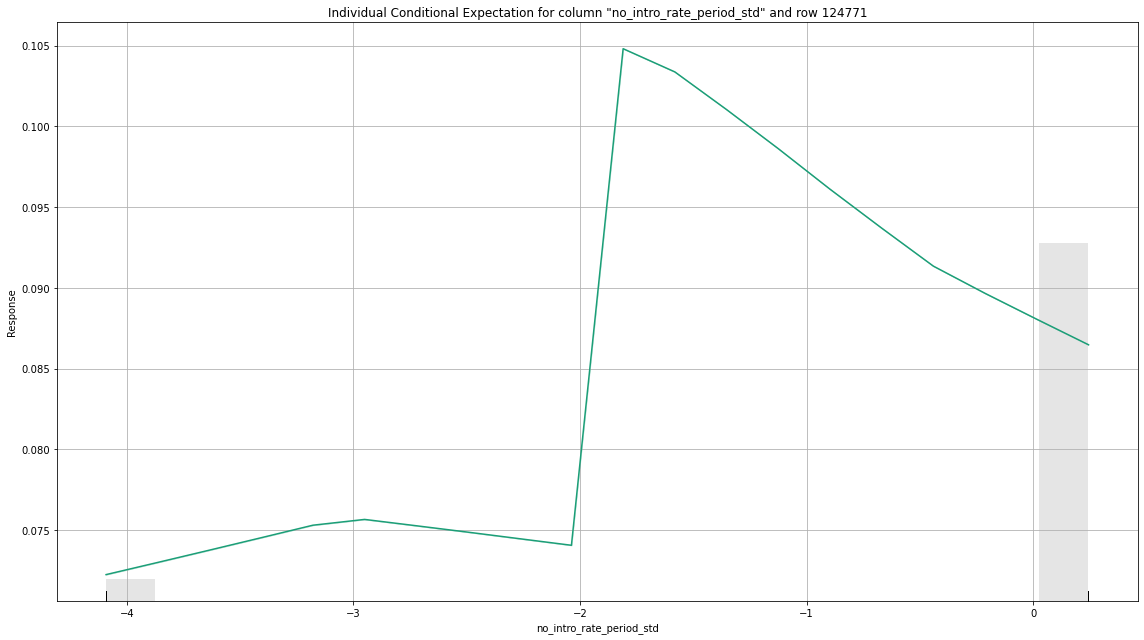

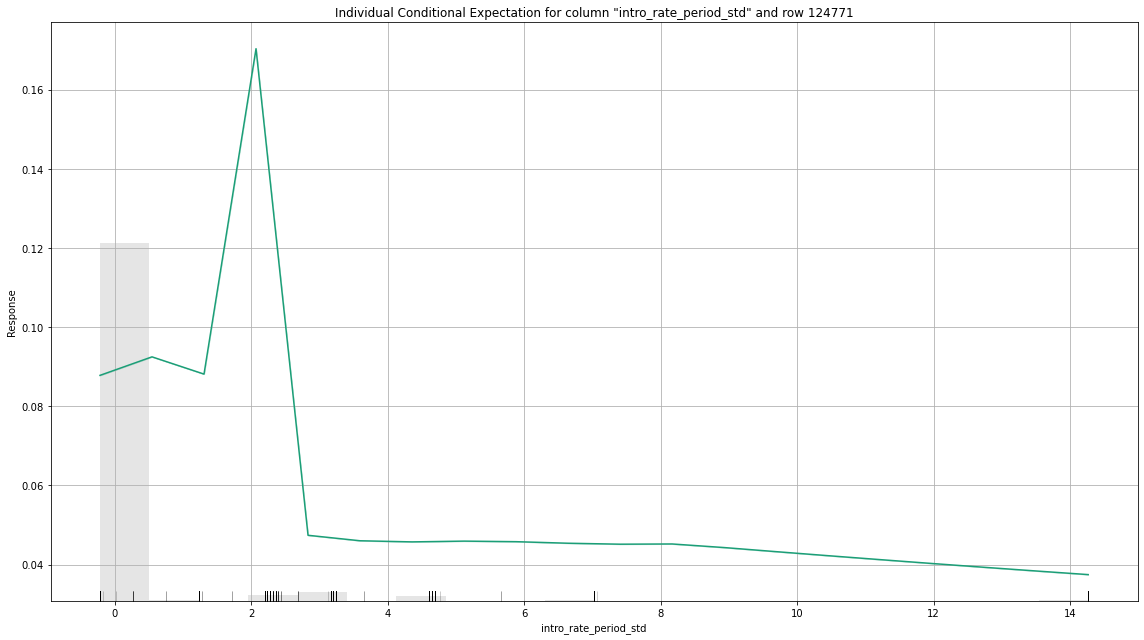

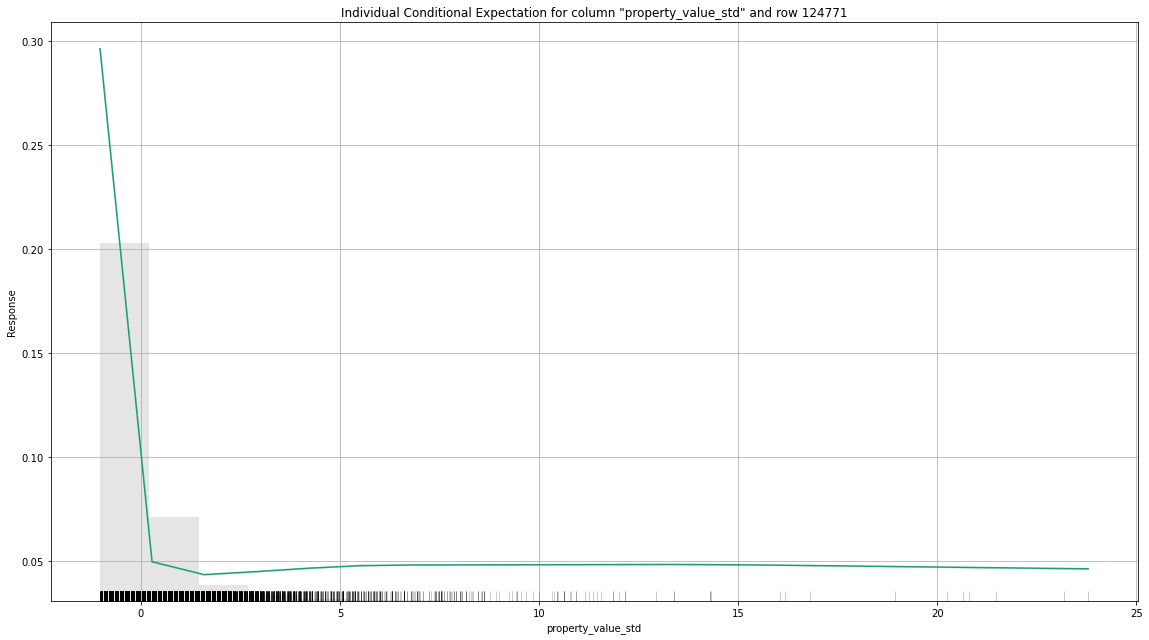

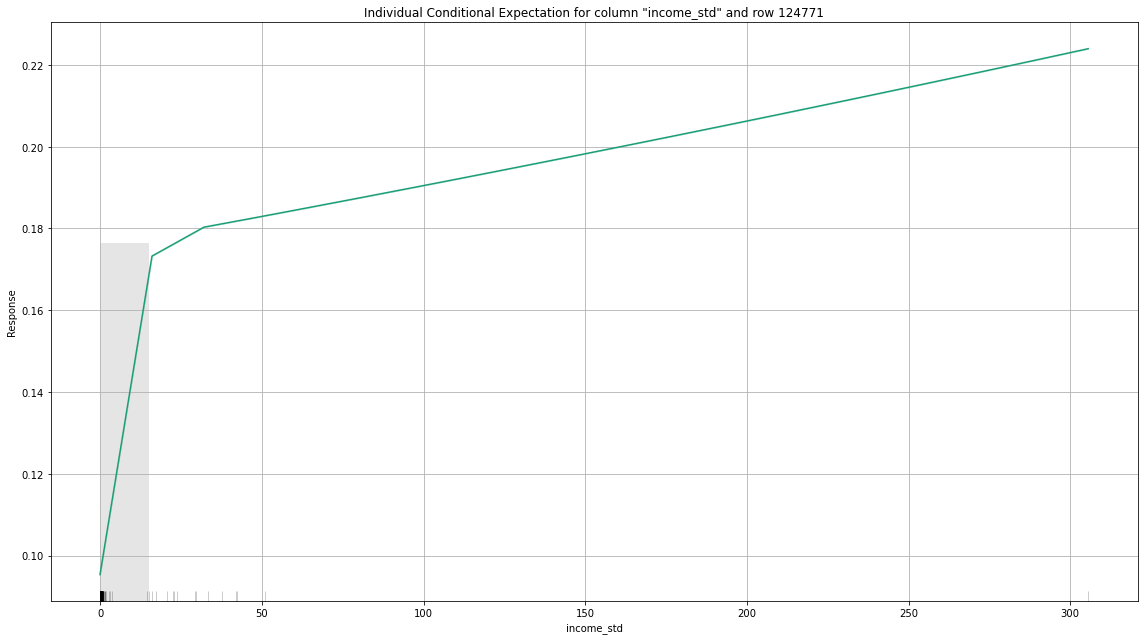

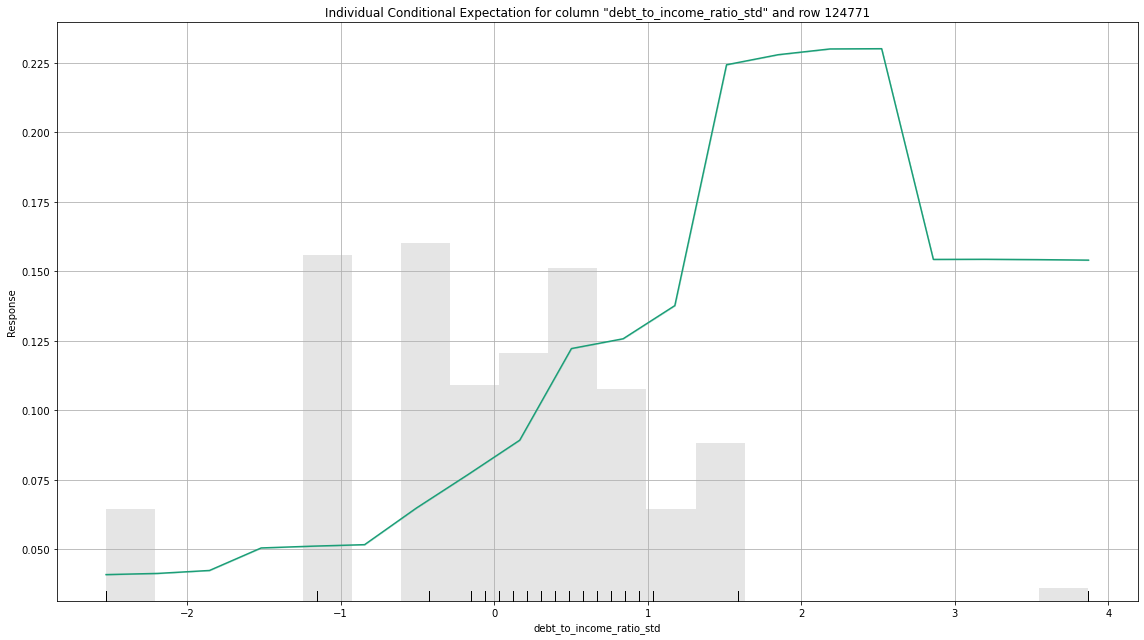

In [41]:
# Explain 90 percentile
ensenble_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[90]))

### H2O Analysis: gbm

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

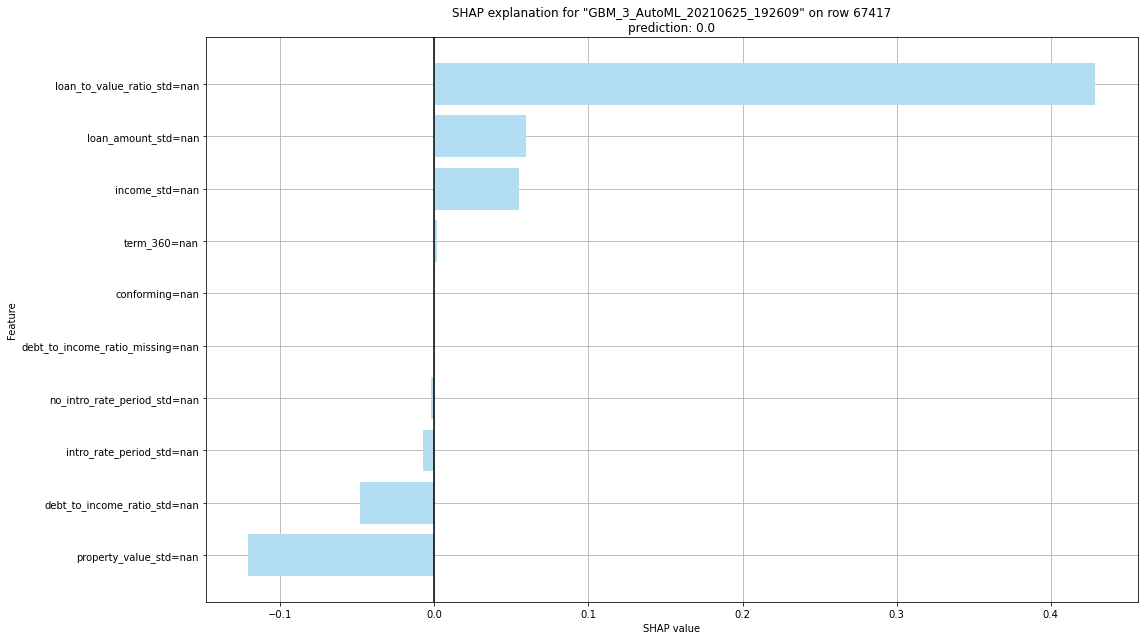

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

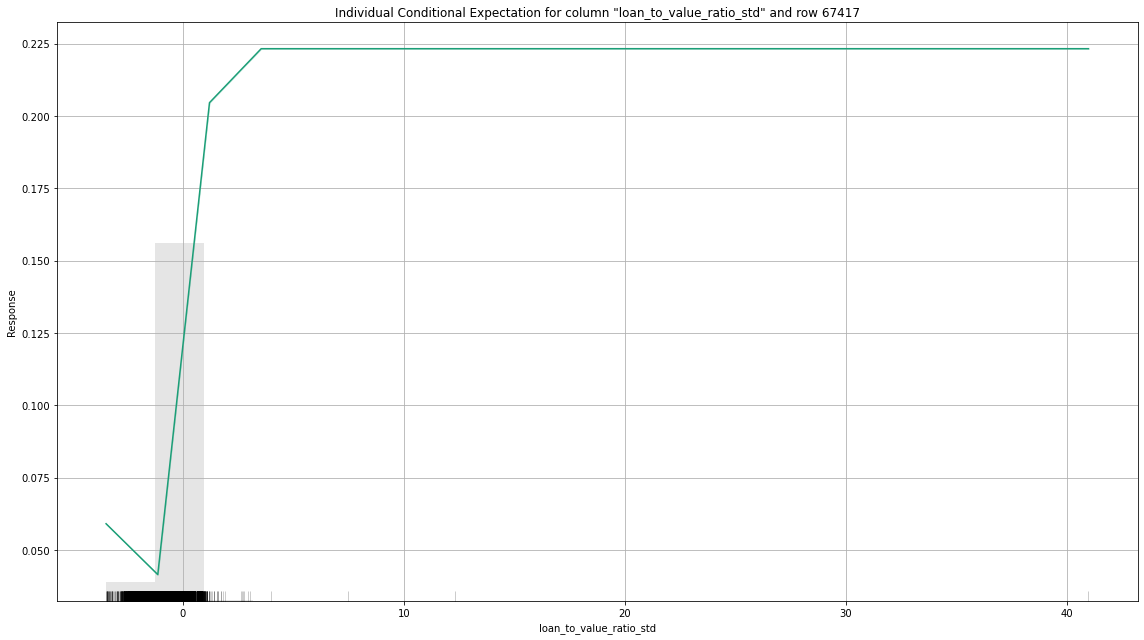

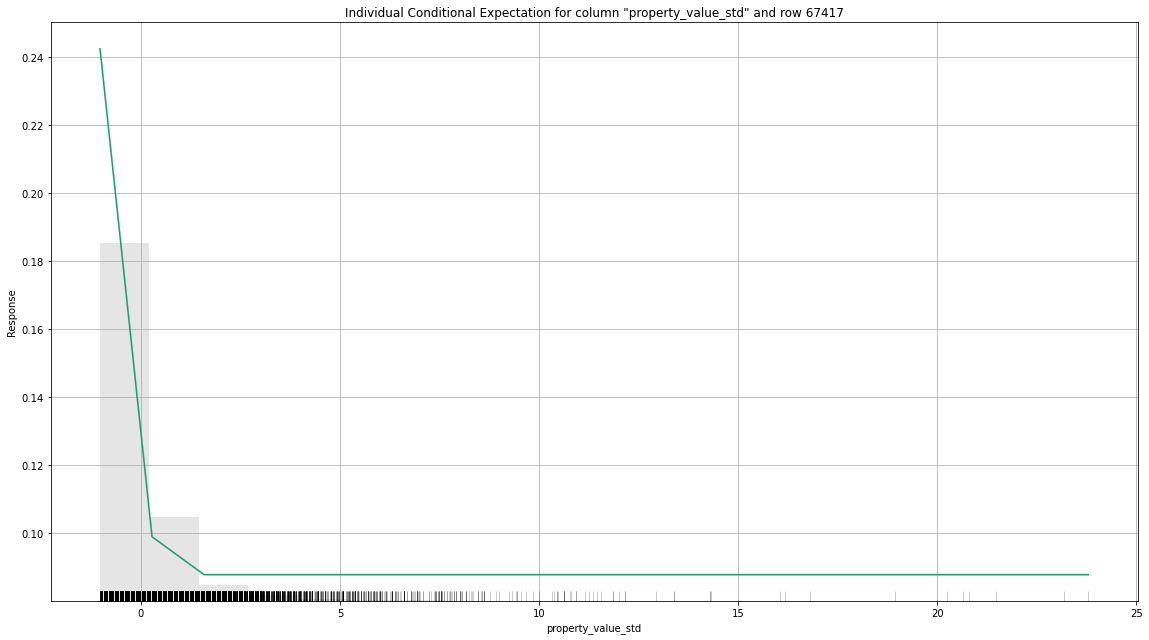

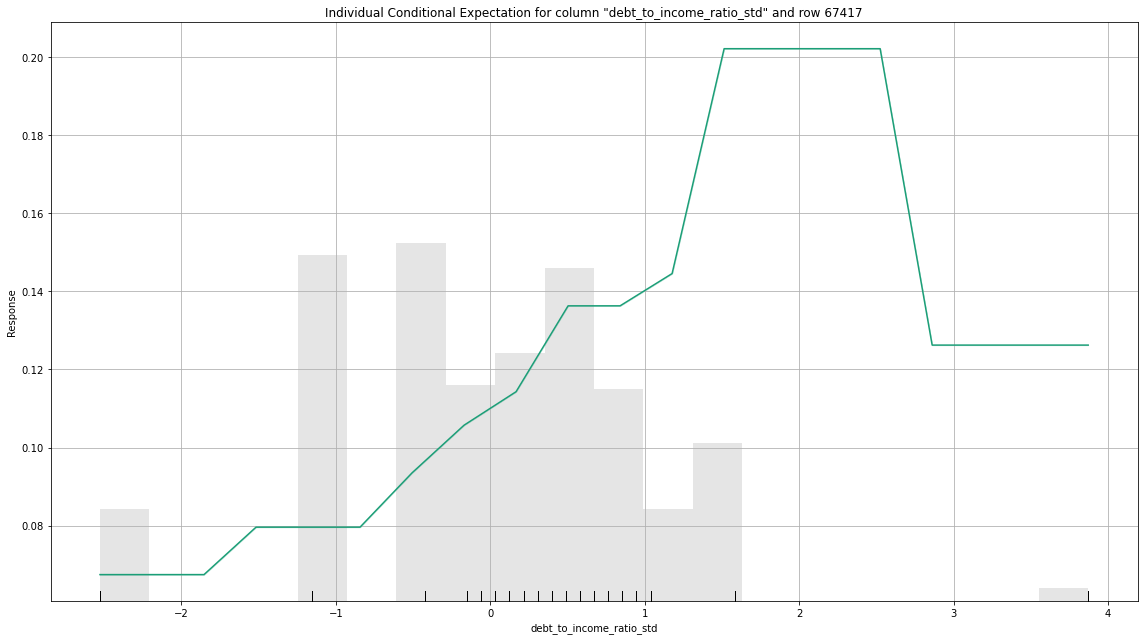

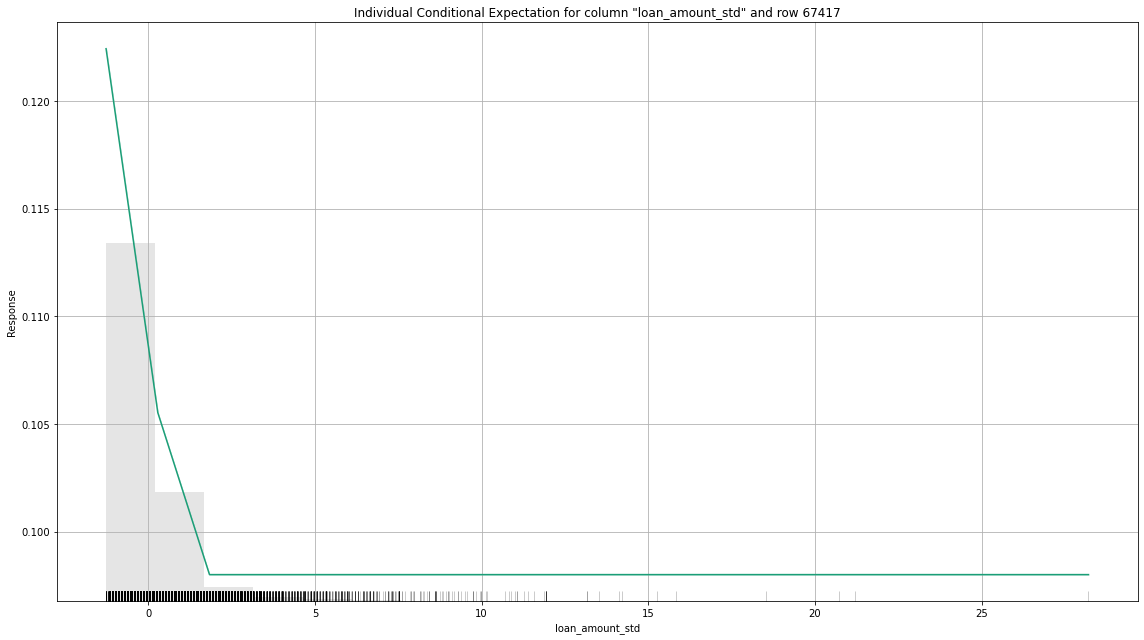

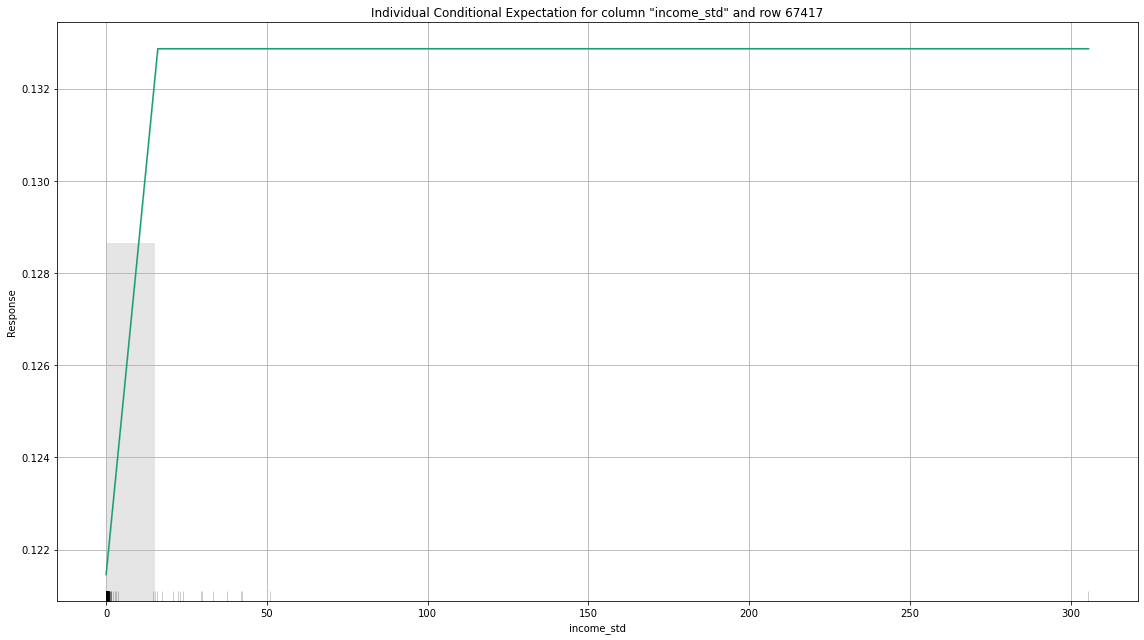

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

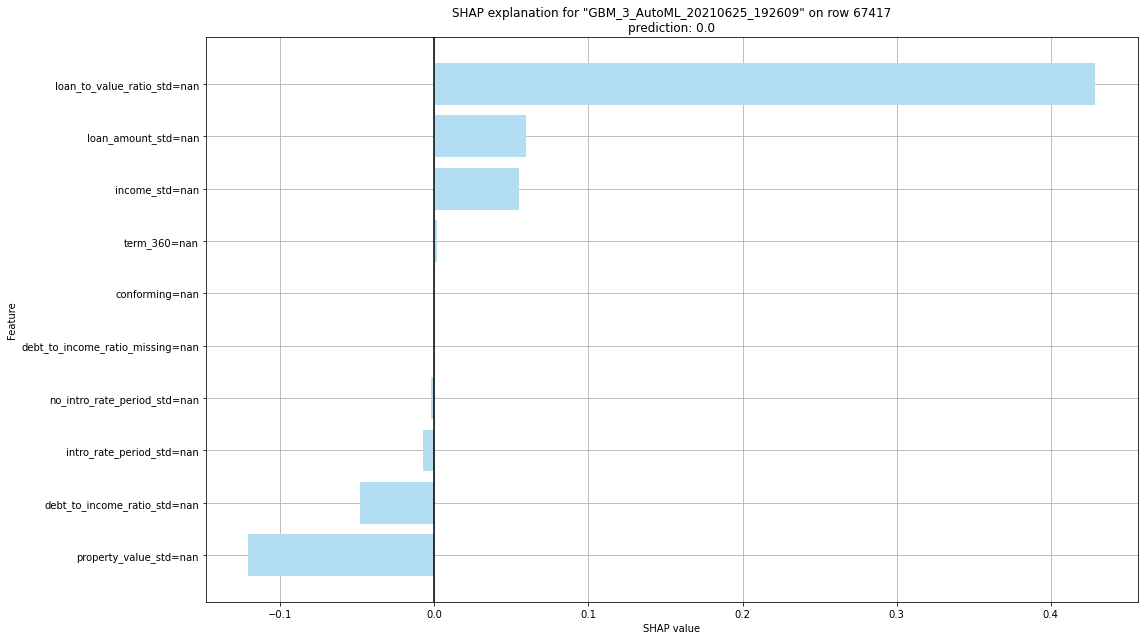

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

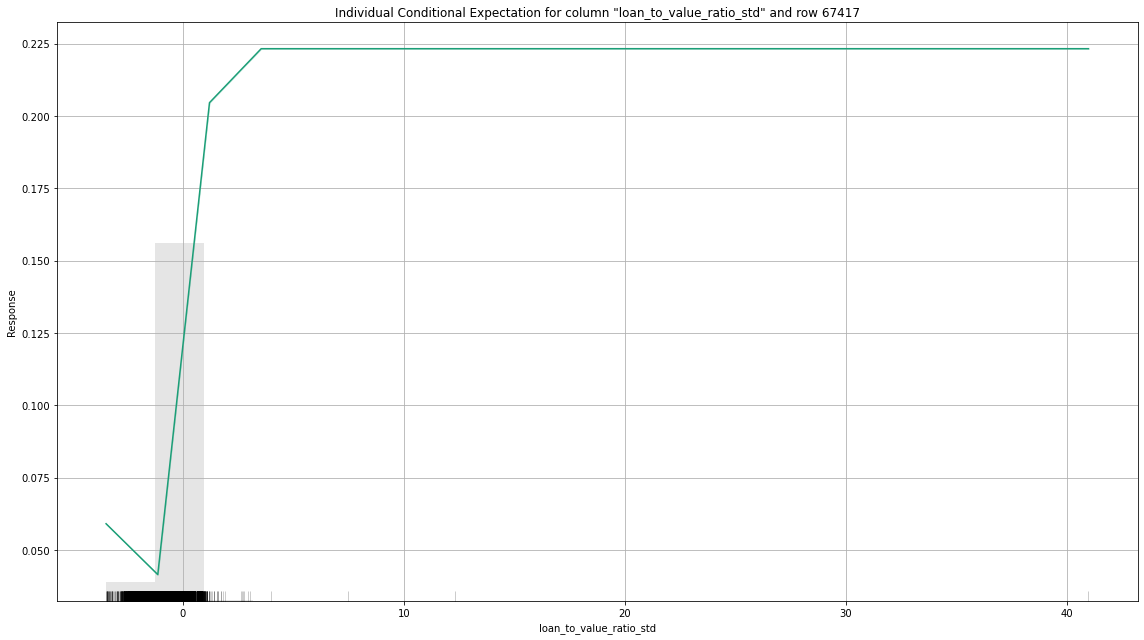

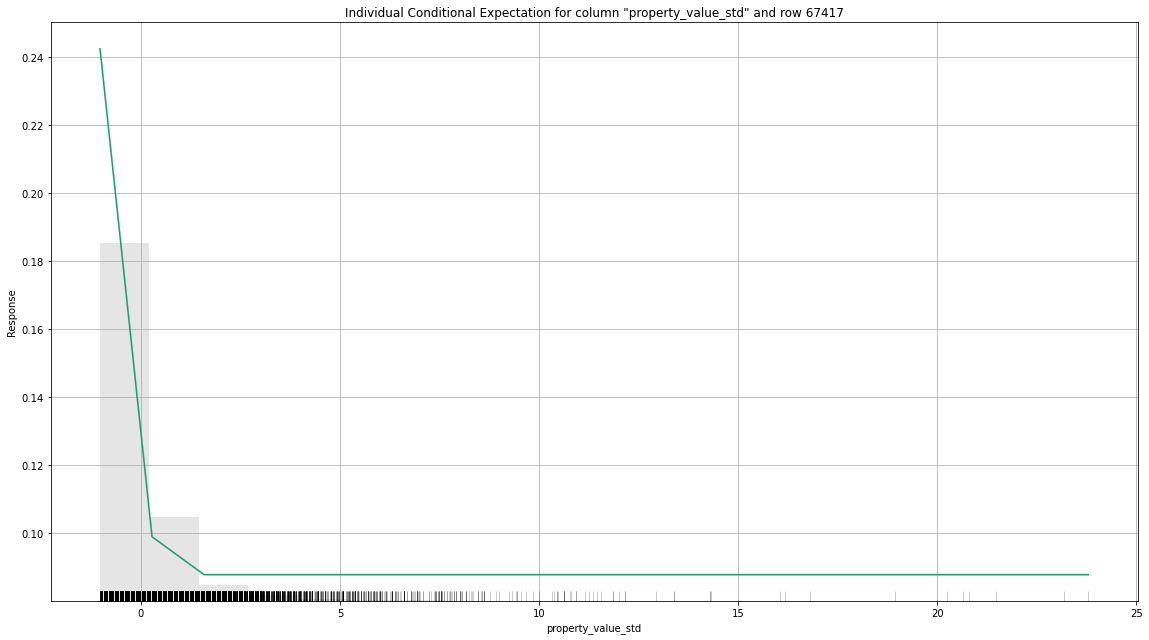

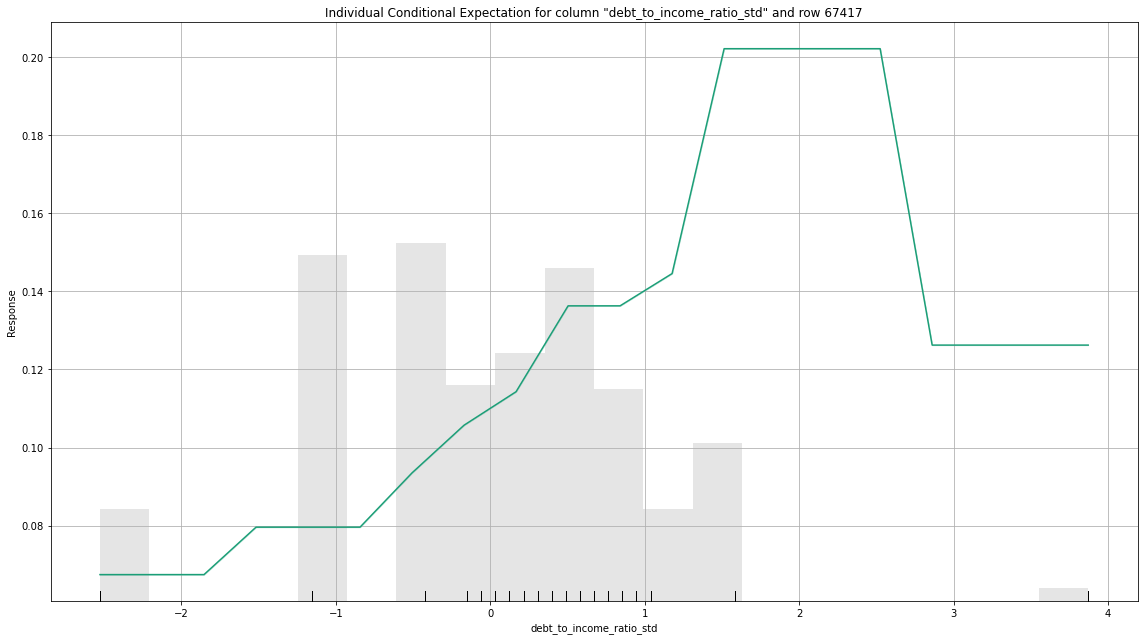

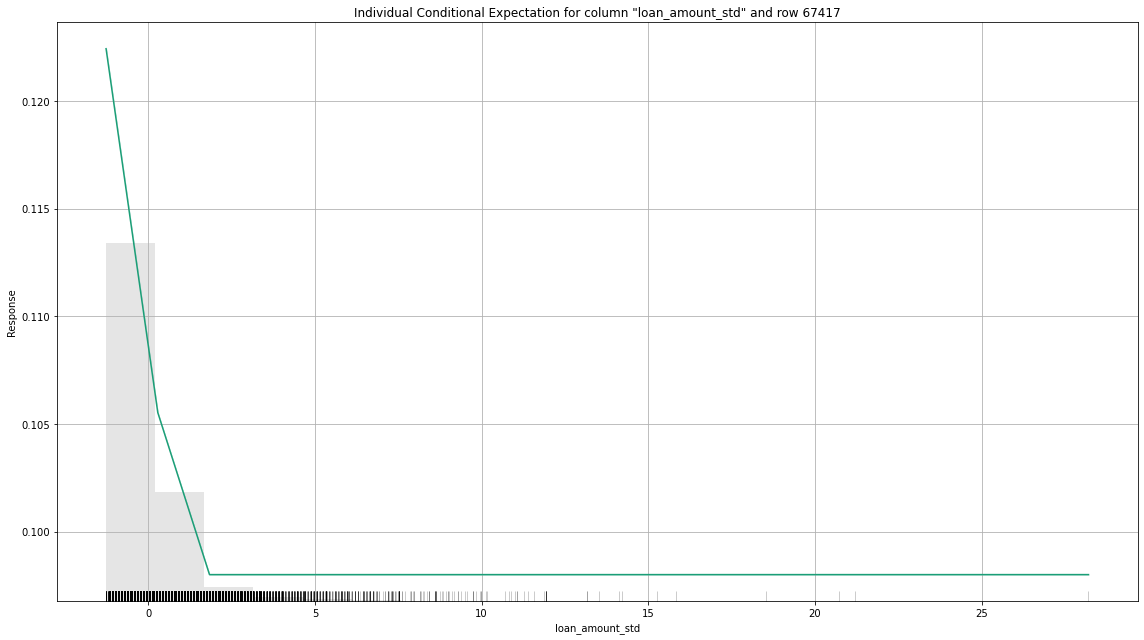

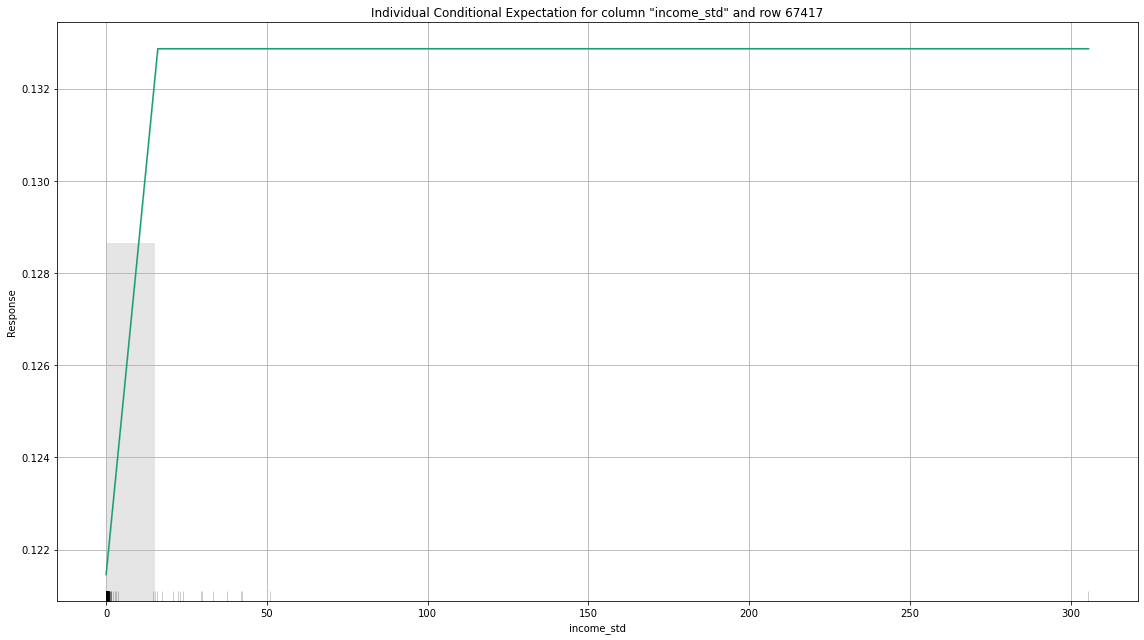

In [42]:
# Explain 10 percentile
gbm_h2o.explain_row(hvalid, row_index=int(gbm_percentile_dict[10]))

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

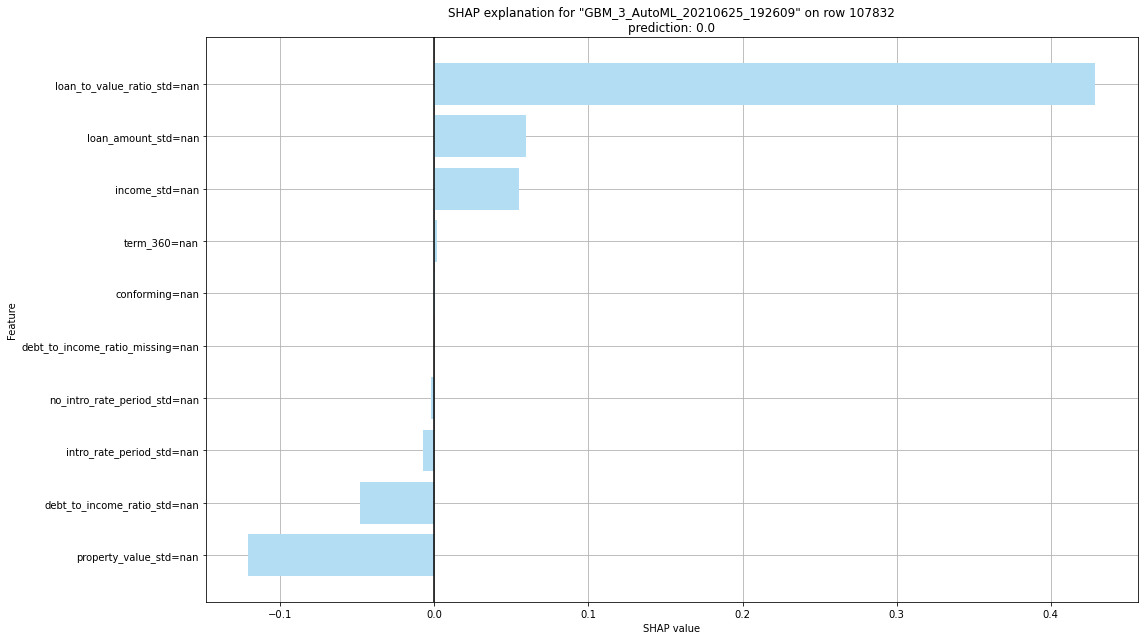

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

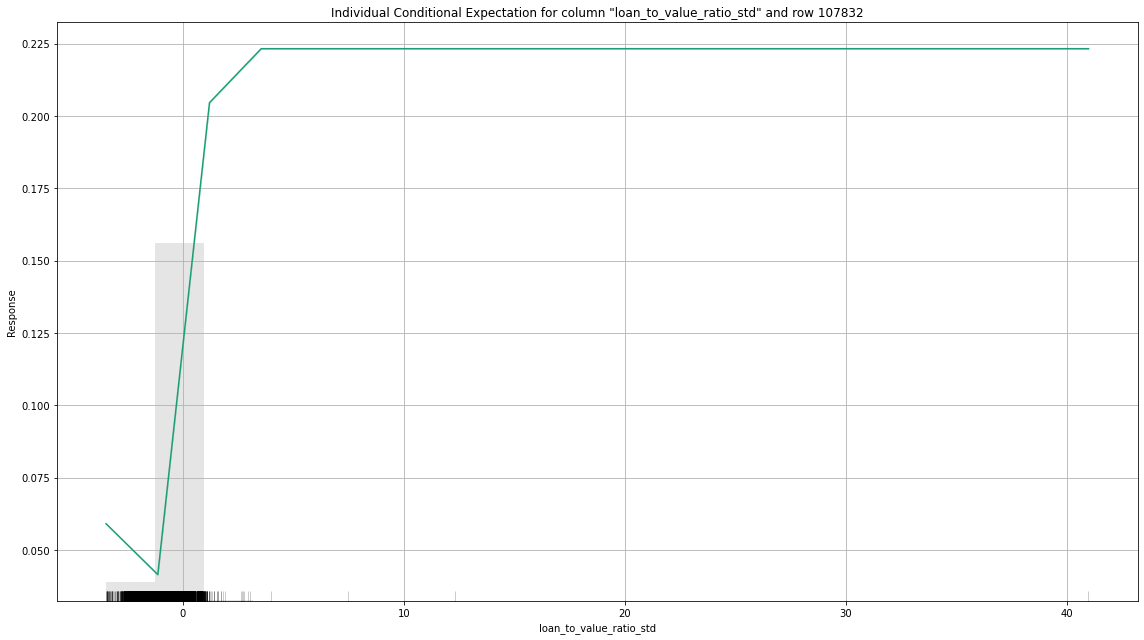

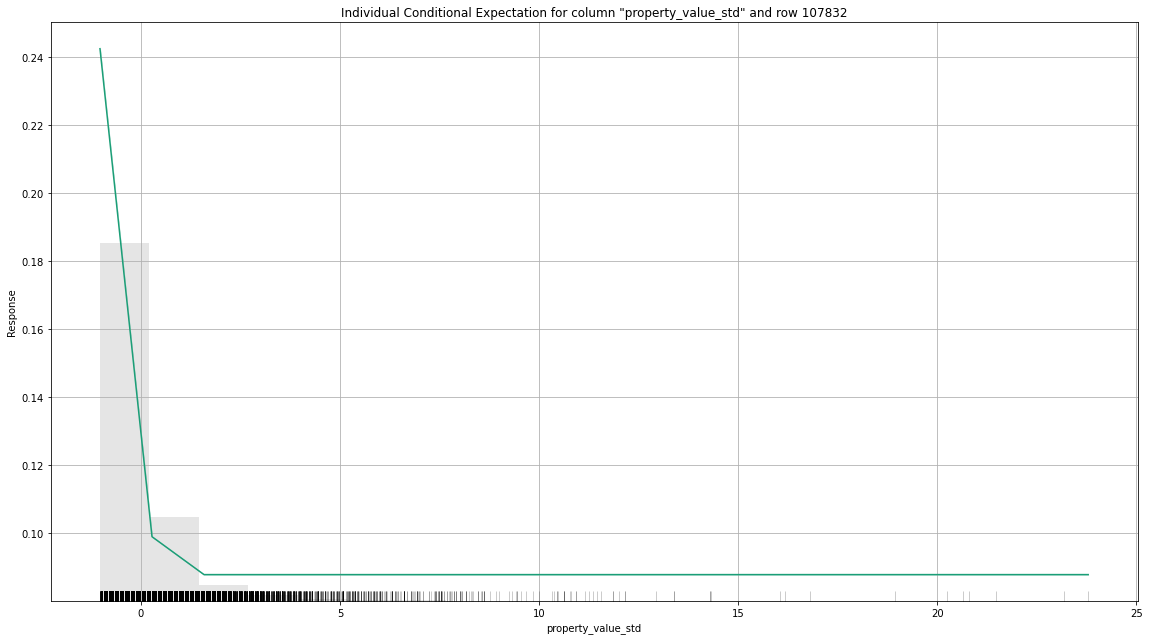

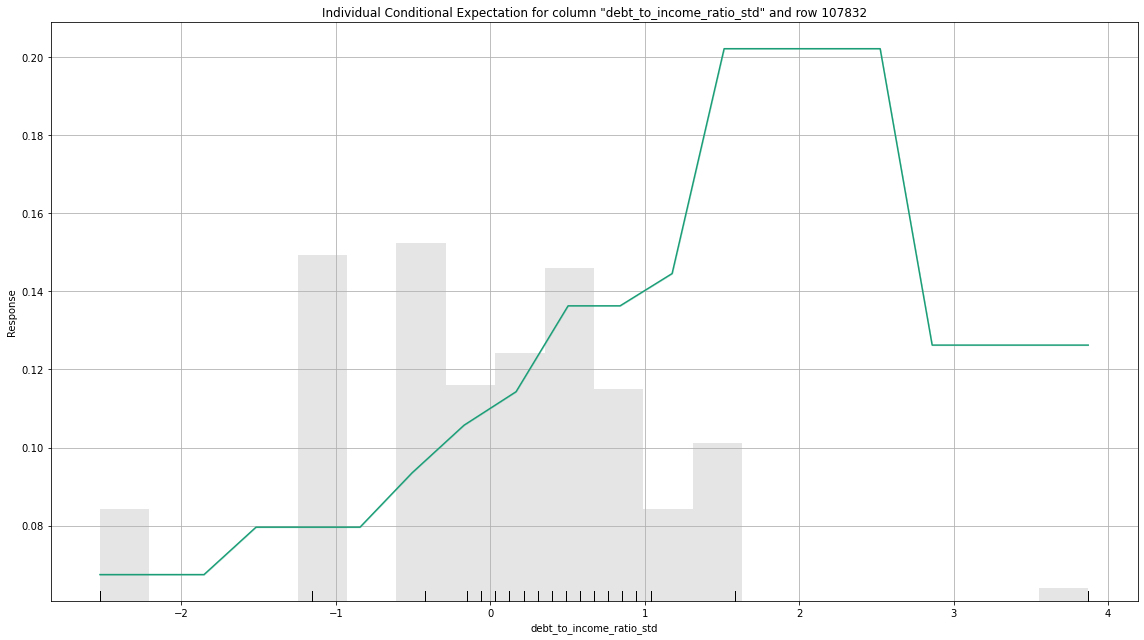

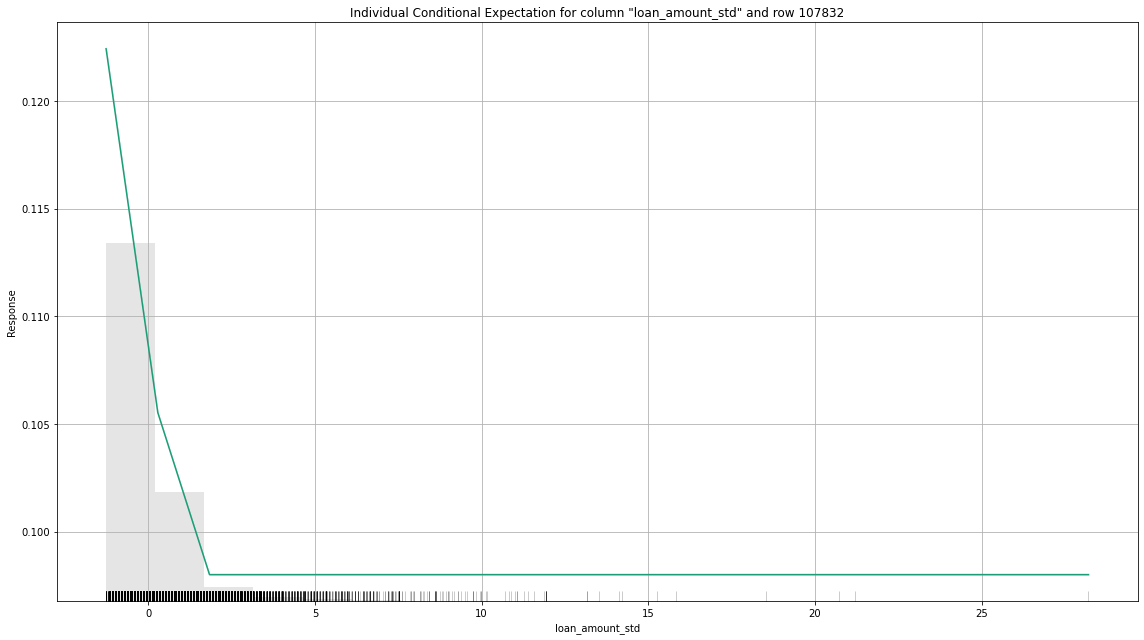

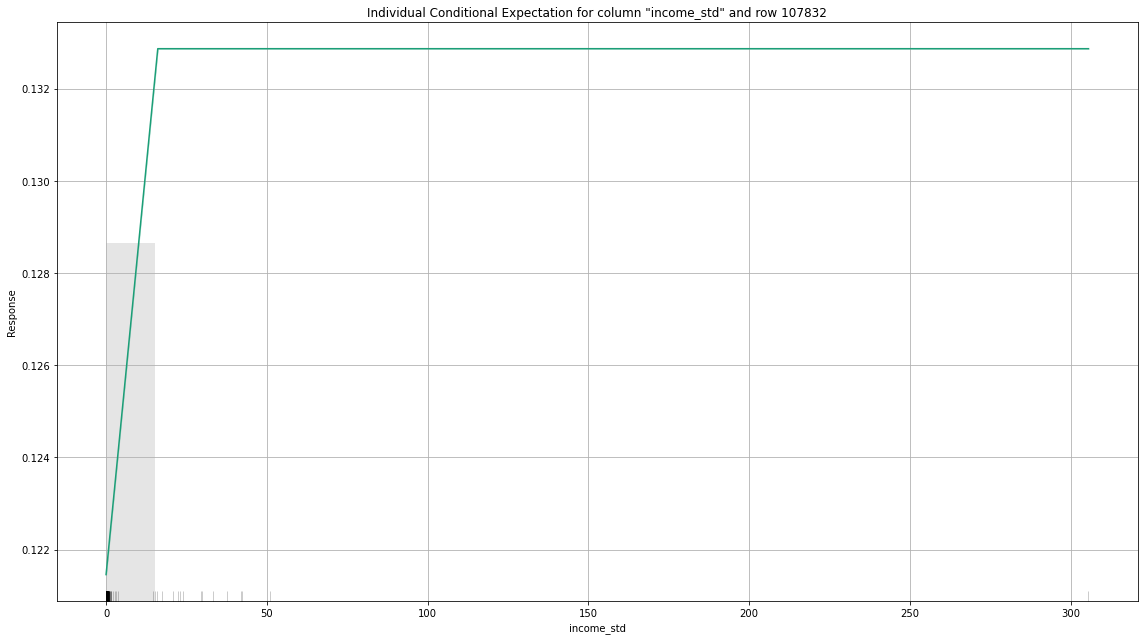

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

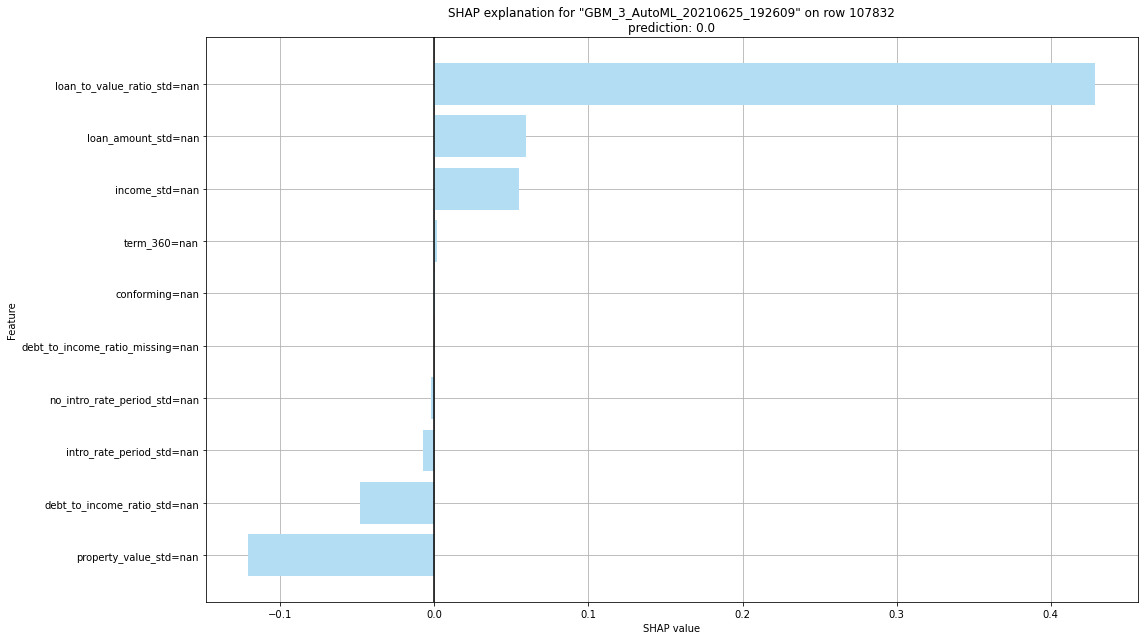

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

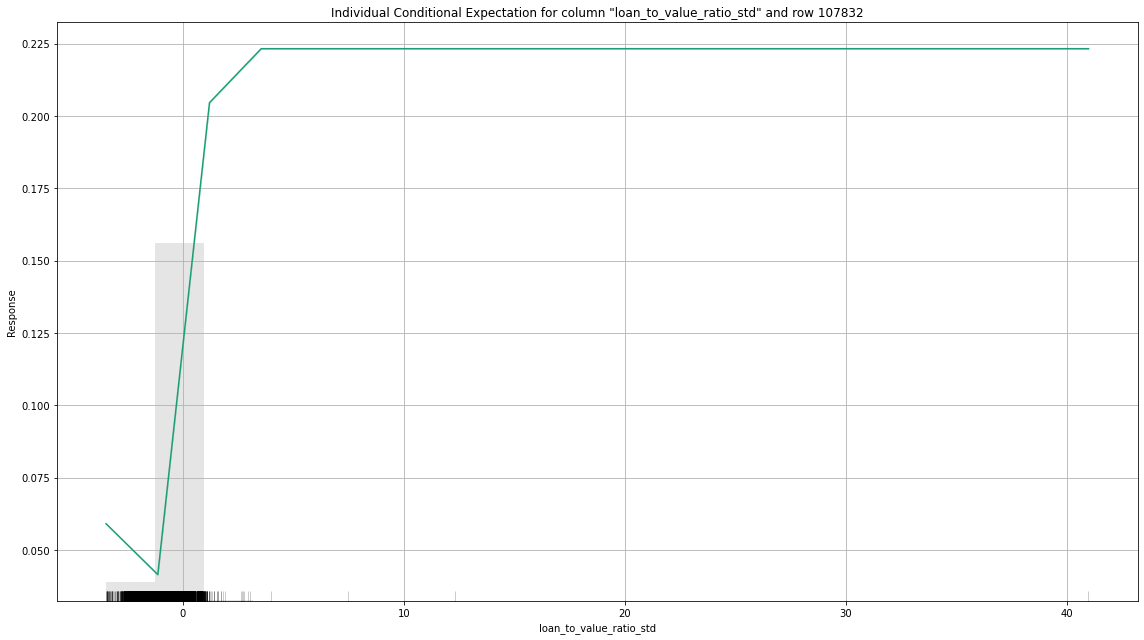

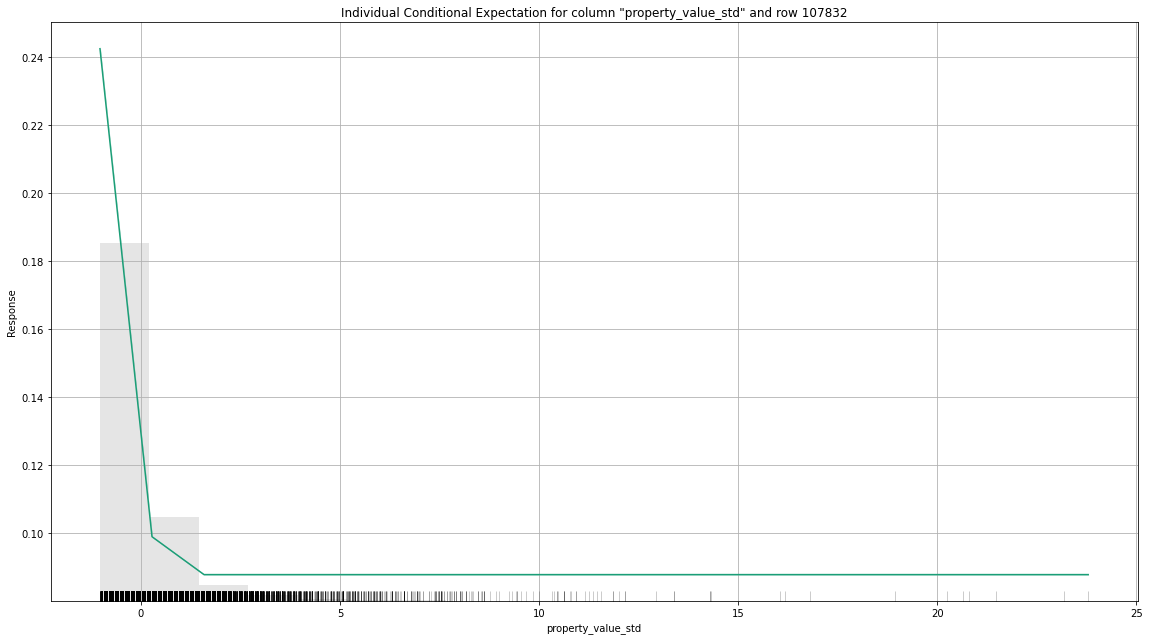

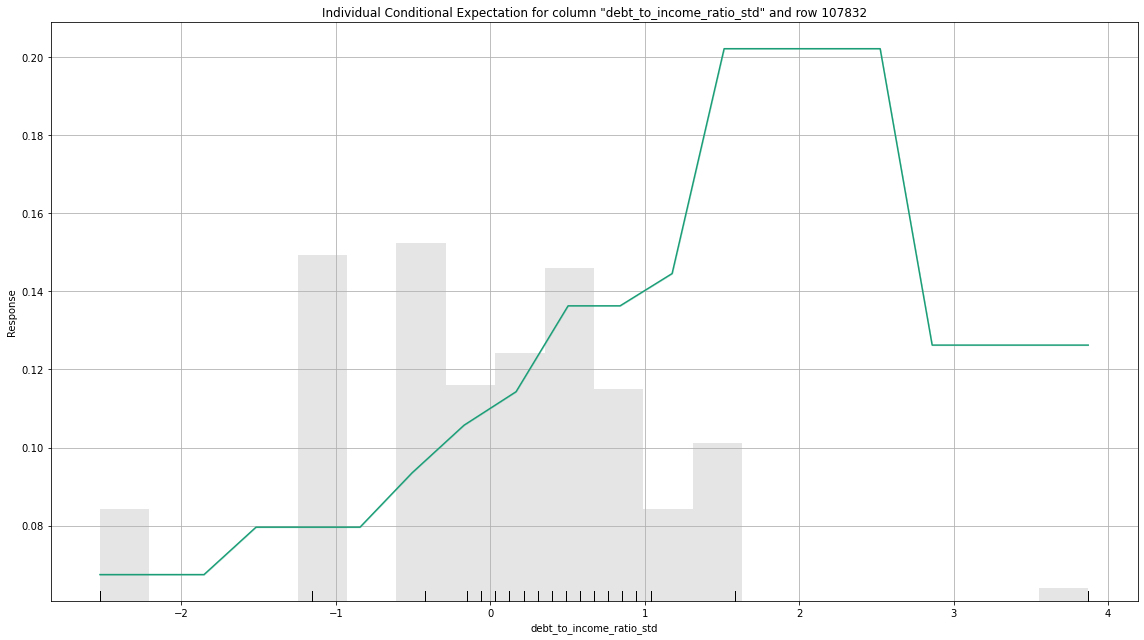

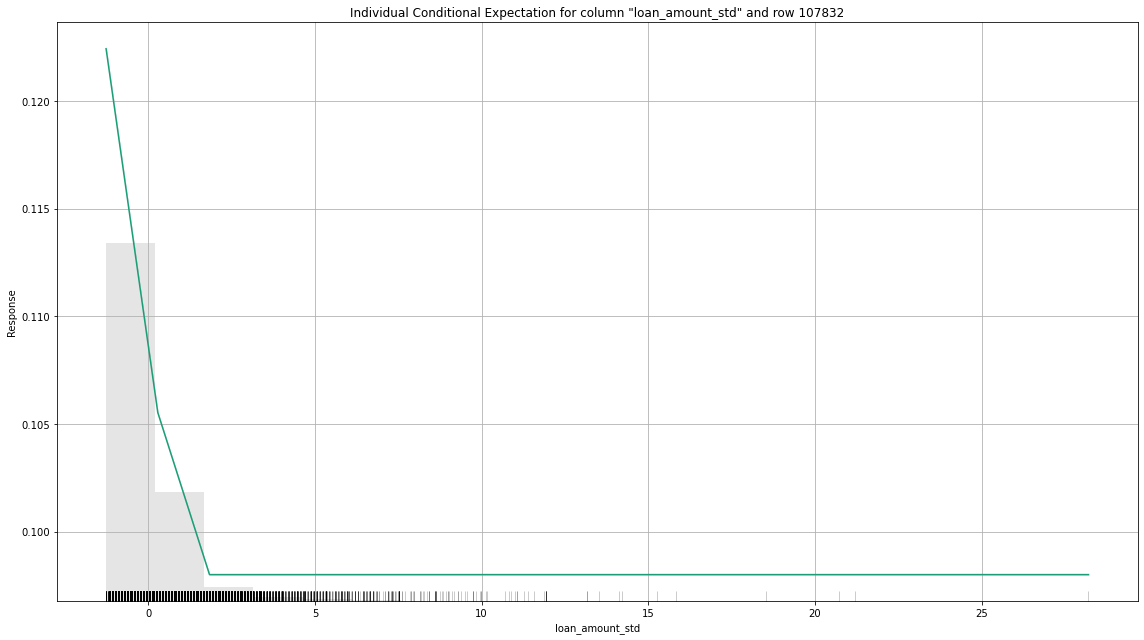

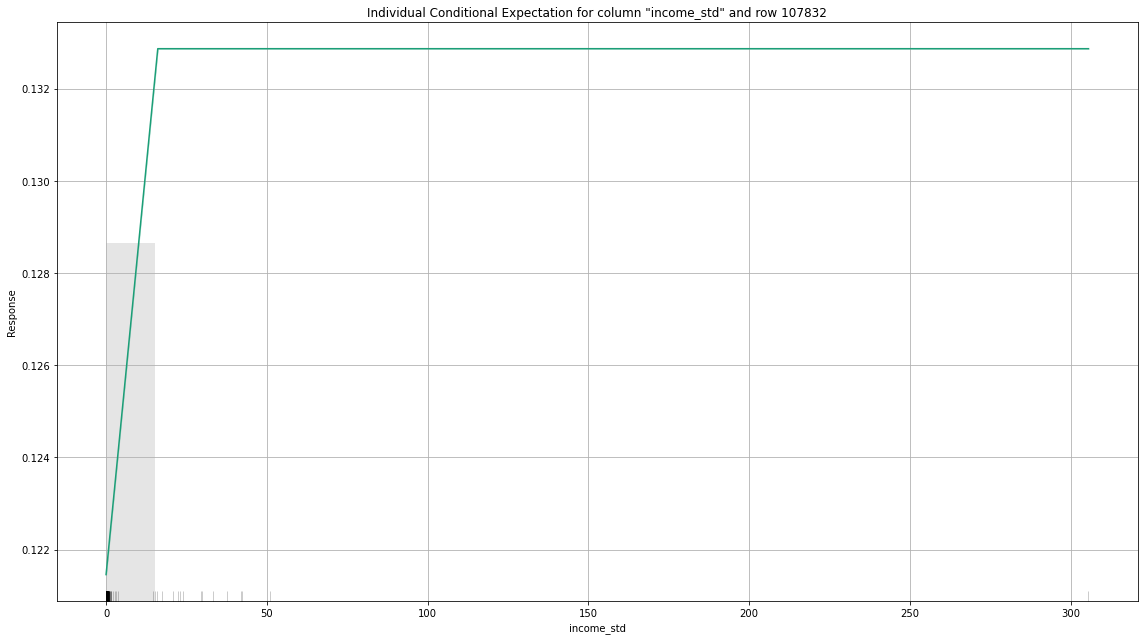

In [43]:
# Explain 50 percentile
gbm_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[50]))

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

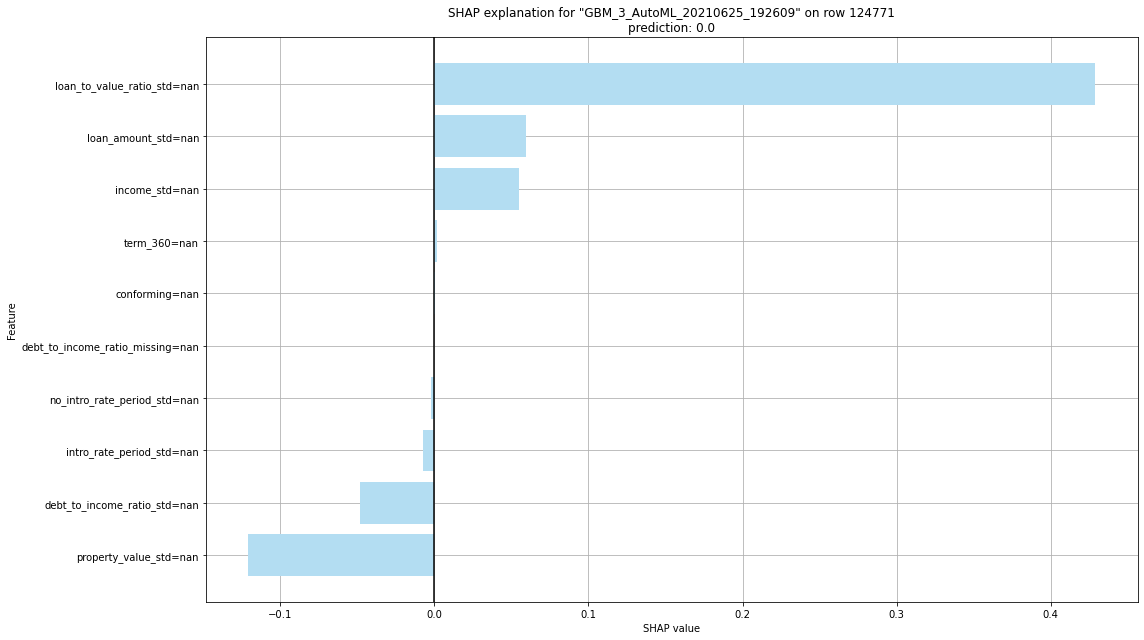

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

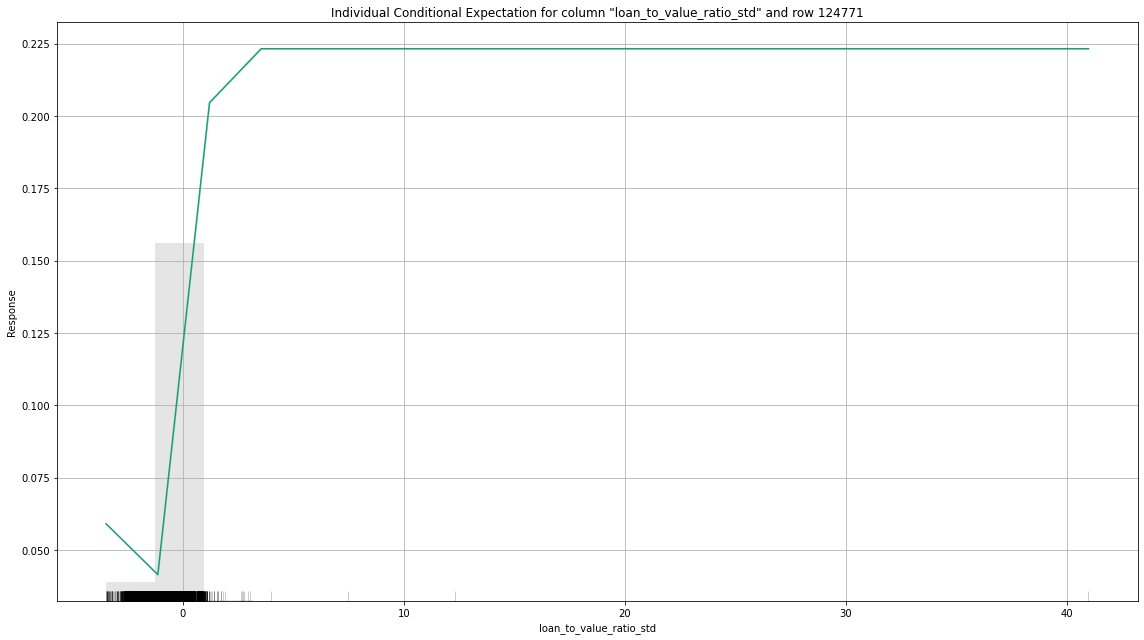

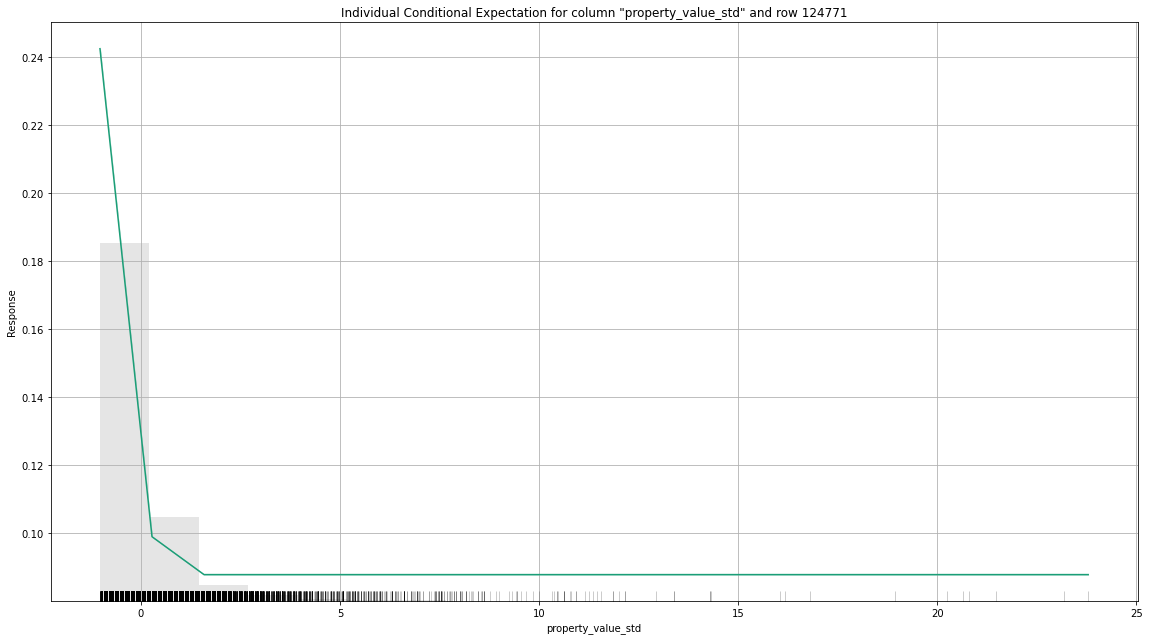

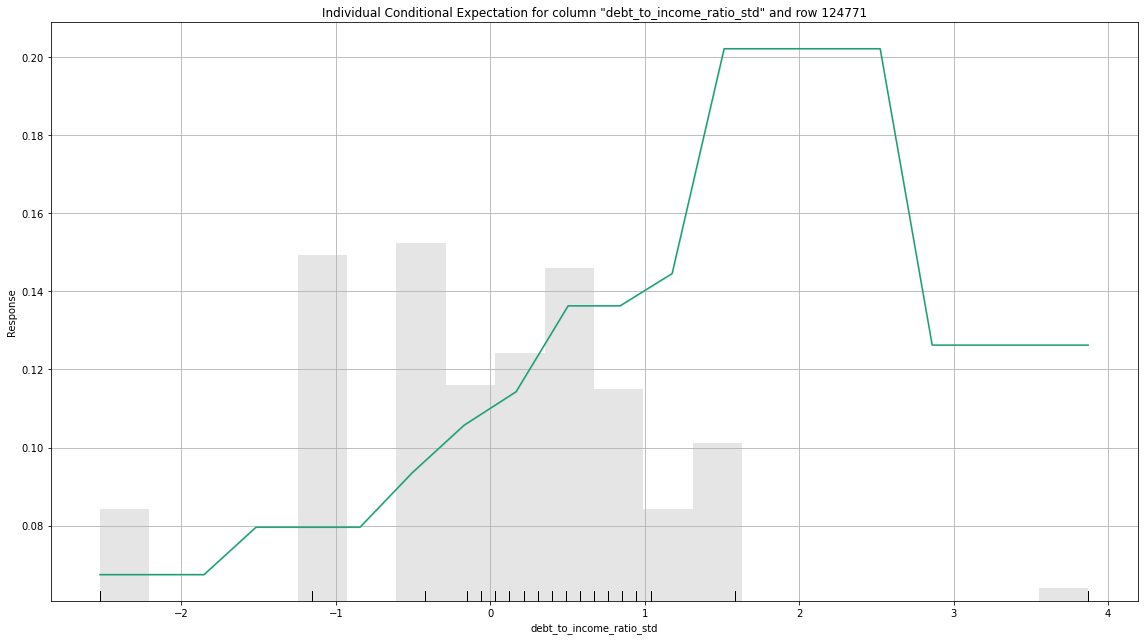

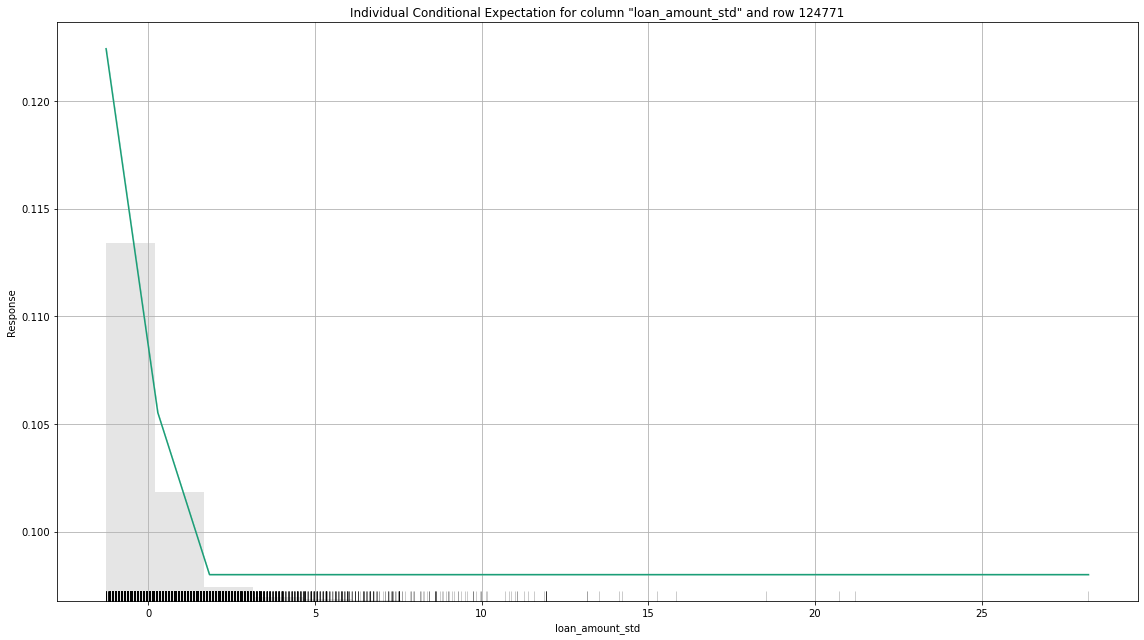

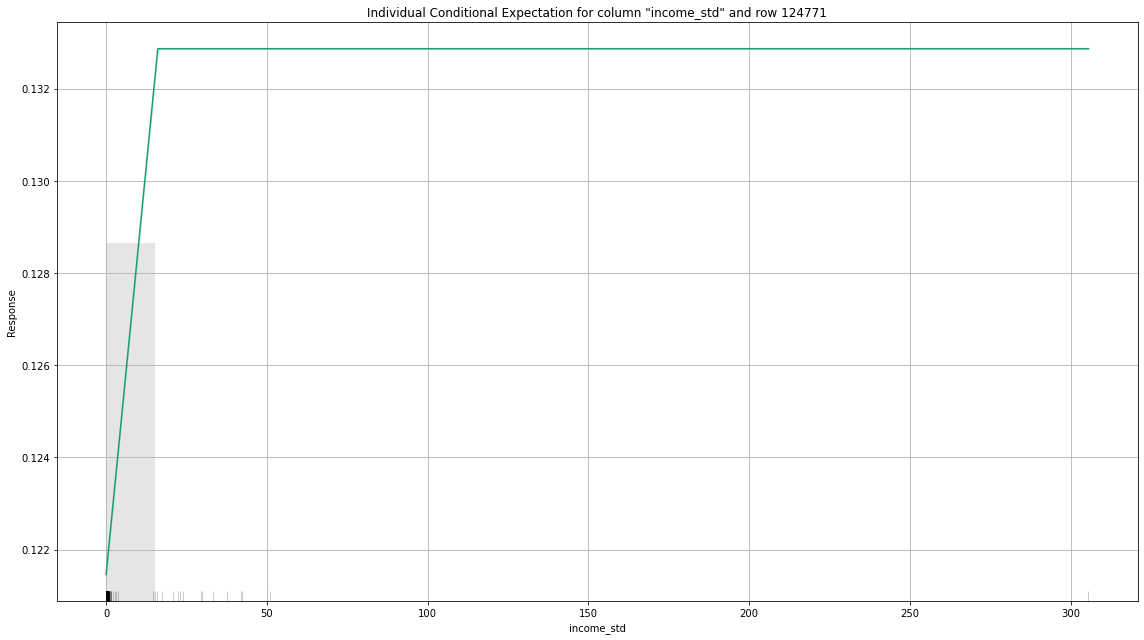

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

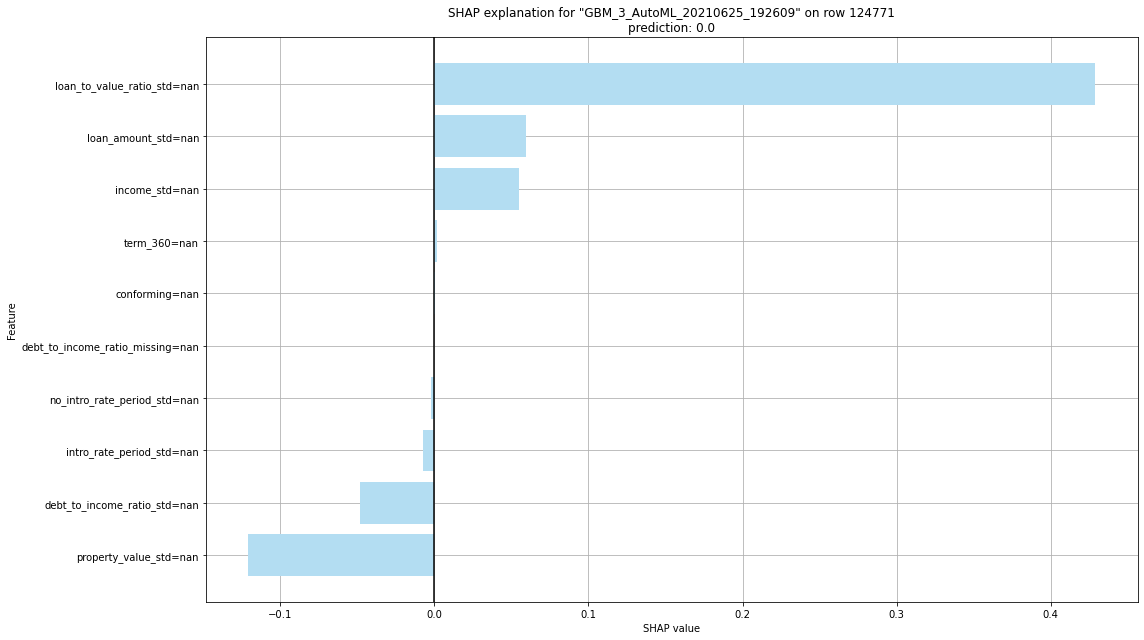

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

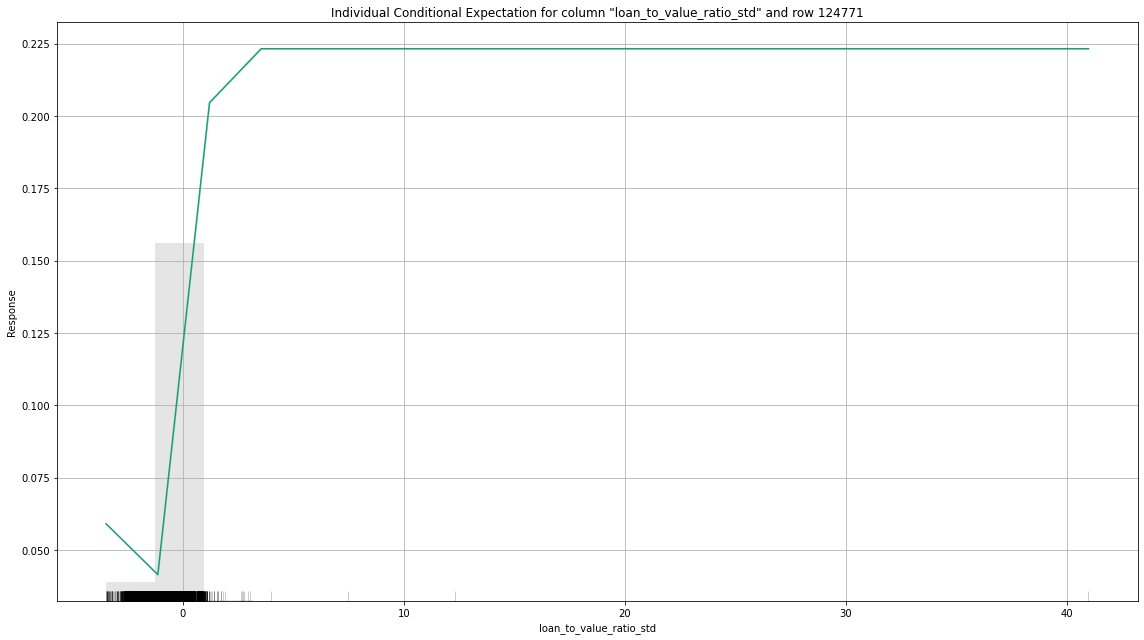

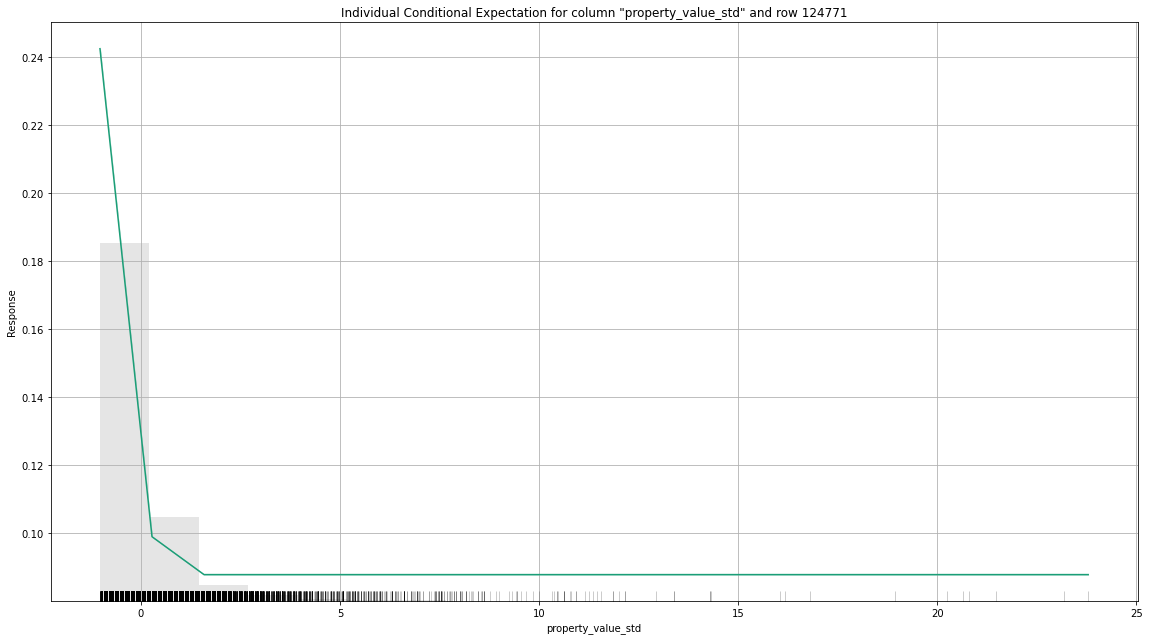

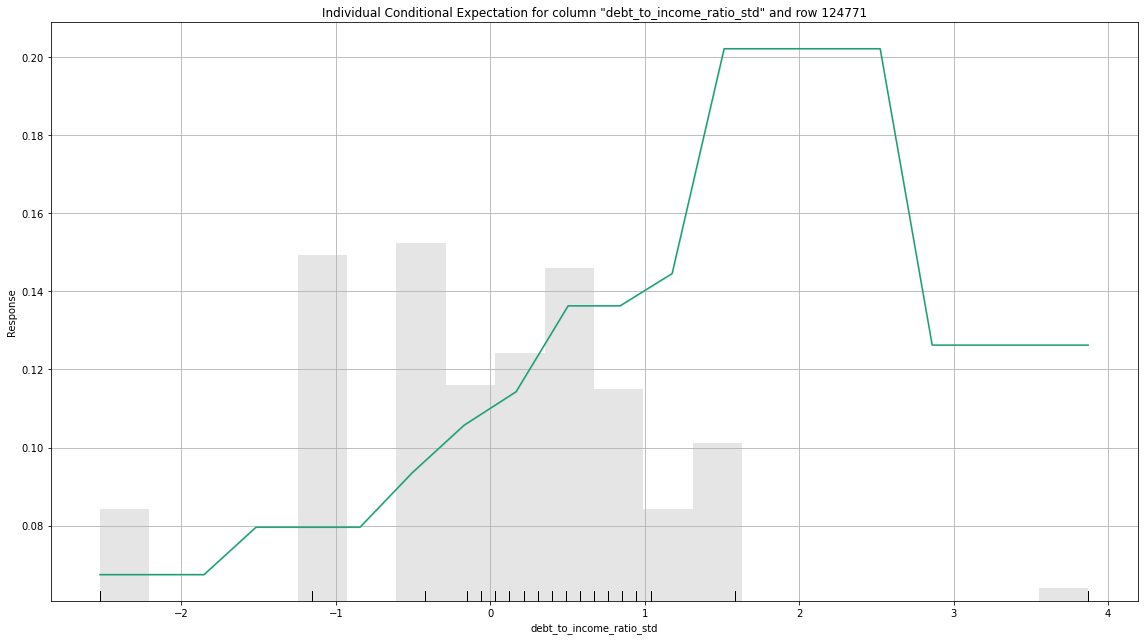

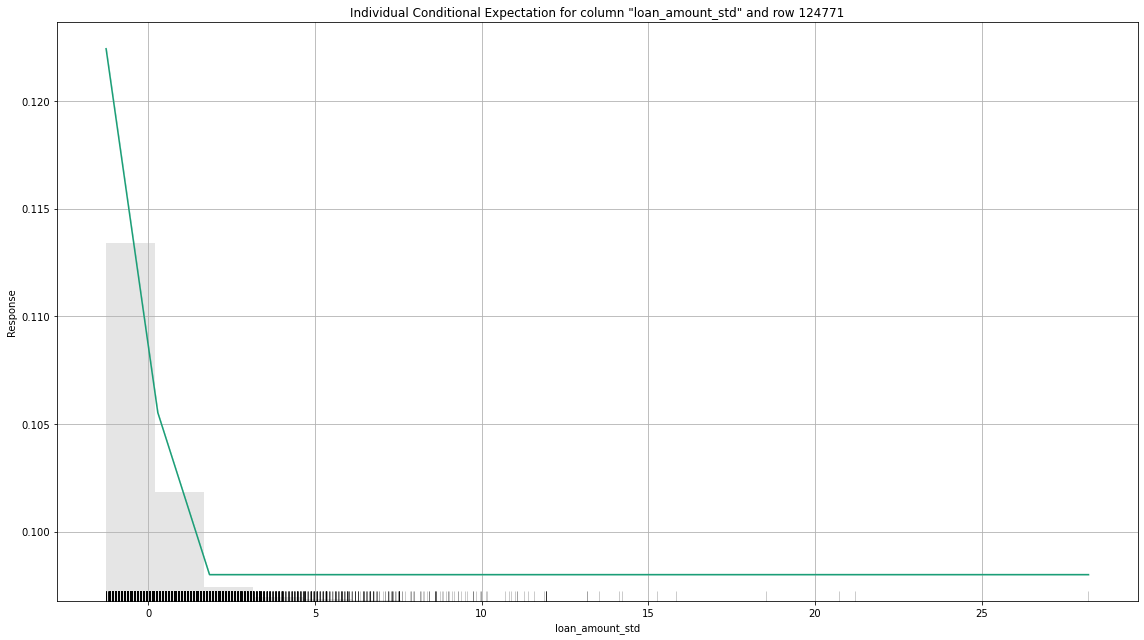

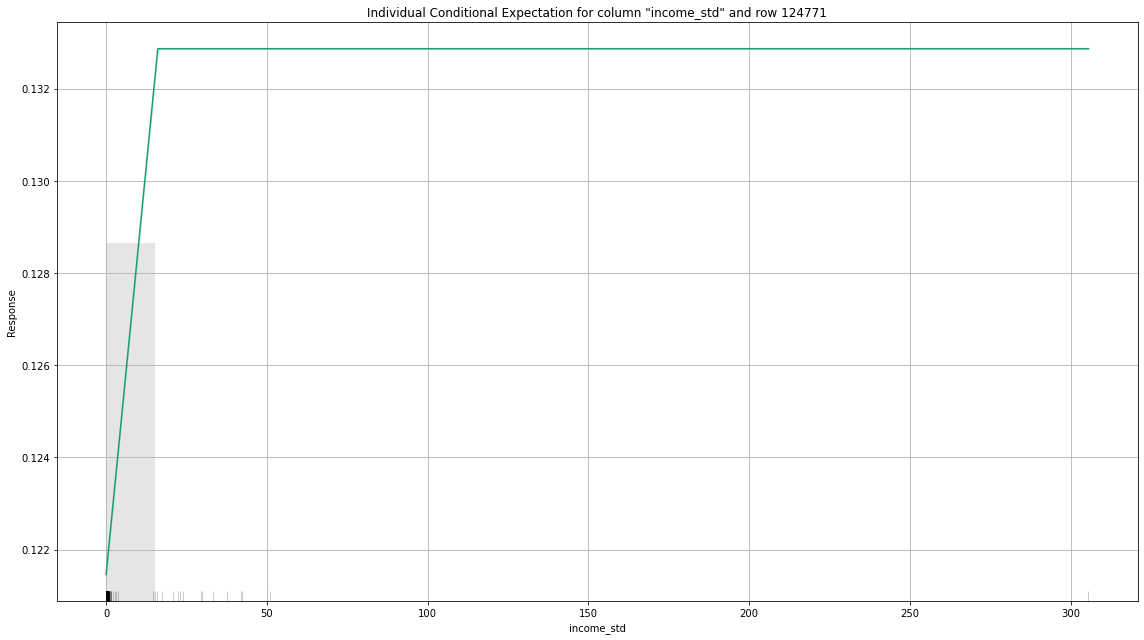

In [44]:
# Explain 90 percentile
gbm_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[90]))

## Calculate and Plot Feature Behavior.

### MGBM

In [45]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'mgbm':
        temp_df['partial_dependence'] = best_gbm.predict(h2o.H2OFrame(temp_df))['1.0'].as_data_frame()
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

In [46]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'mgbm'])
    first_pd = par_dep(name, valid[x_names], best_gbm, 'mgbm')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['mgbm'] = first_pd['partial_dependence']
    
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 790.02 s.


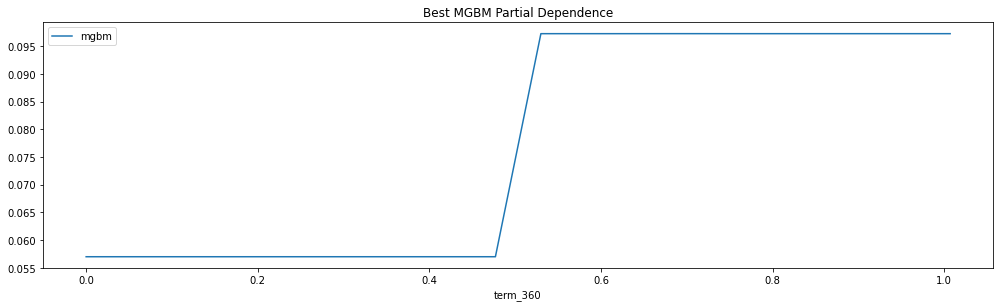

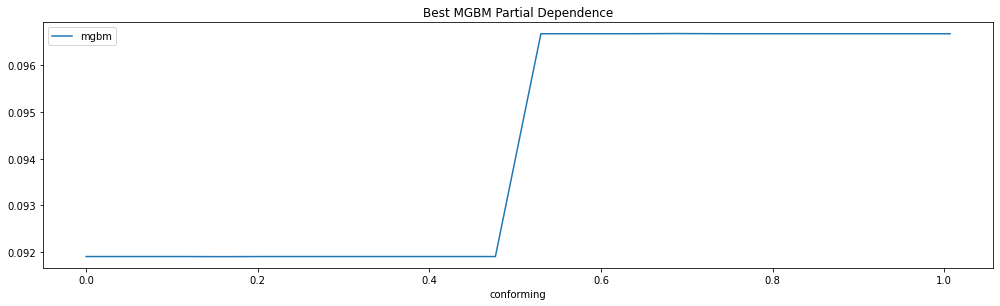

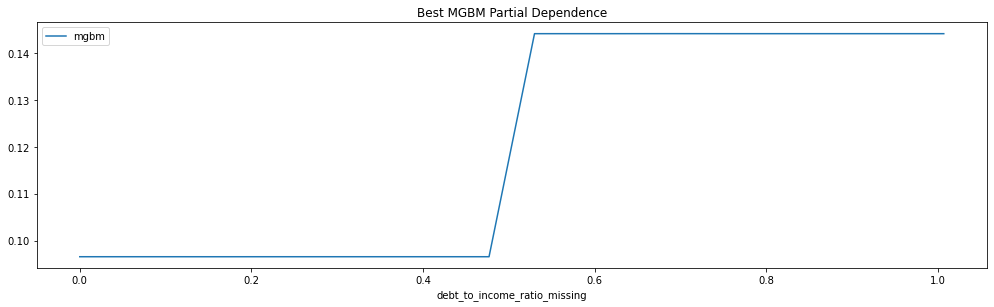

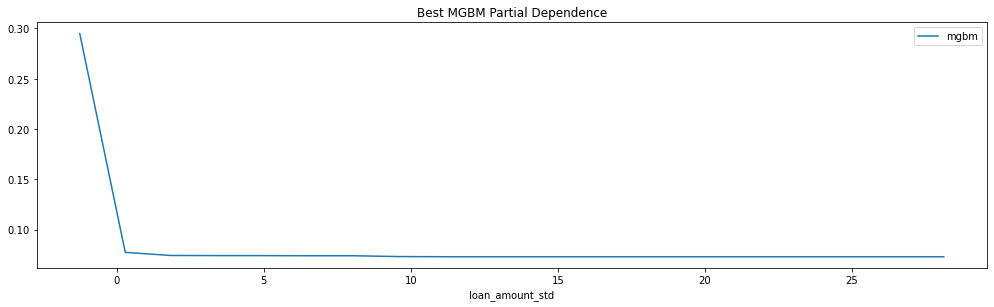

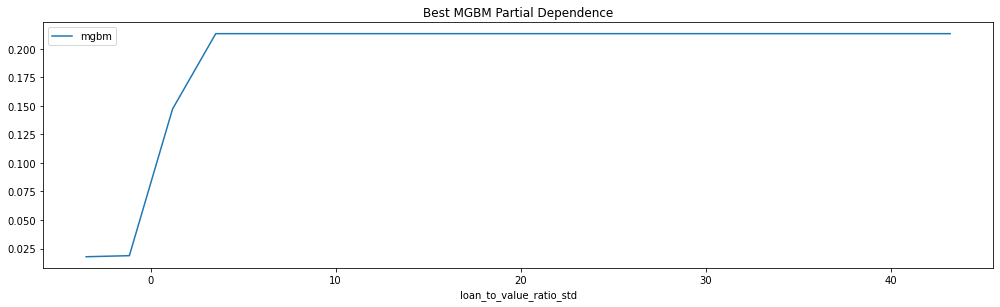

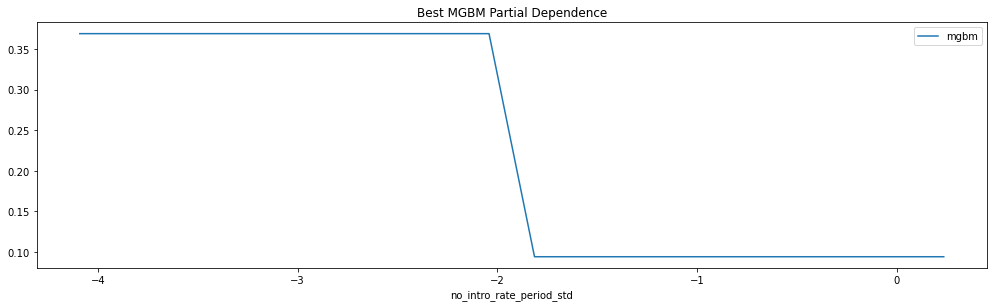

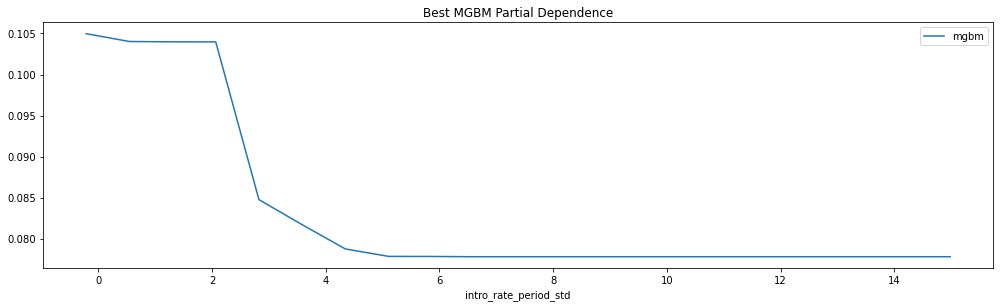

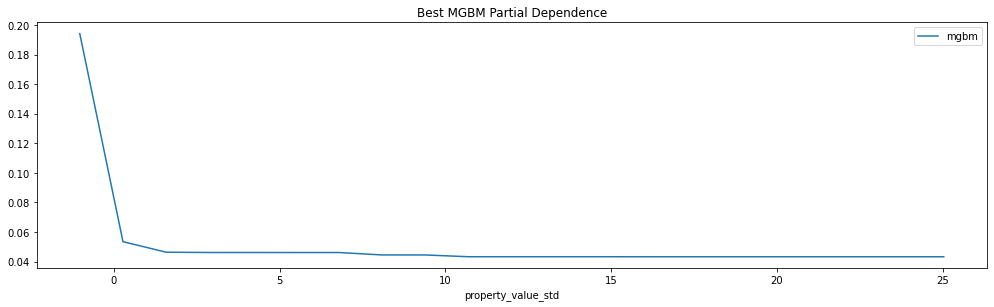

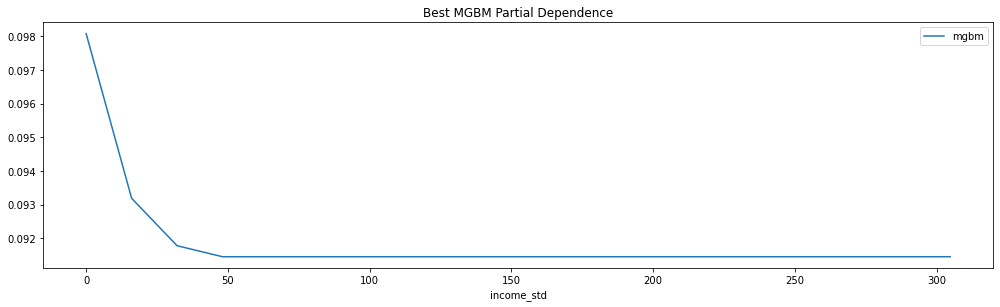

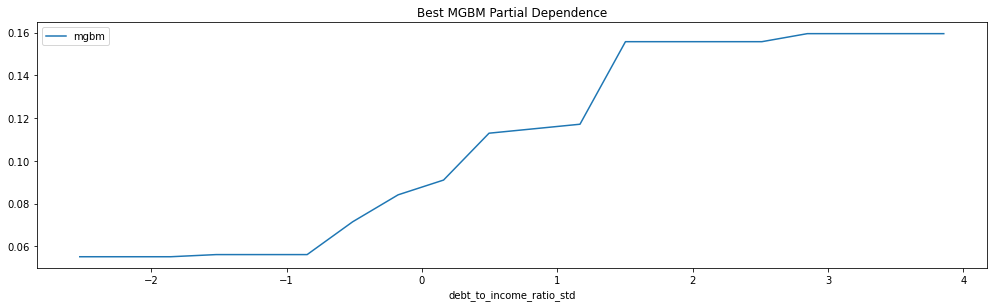

In [47]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0) = plt.subplots(ncols=1, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='mgbm', ax=ax0, title='Best MGBM Partial Dependence')
    ax0.set_xlabel(name)
   

### GBM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_3_AutoML_20210625_192609


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15442572328363321: 


0.0      1.0   Error                 Rate
0    0.0  82870.0  18798.0  0.1849   (18798.0/101668.0)
1    1.0   3836.0   7016.0  0.3535     (3836.0/10852.0)
2  Total  86706.0  25814.0  0.2012   (22634.0/112520.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

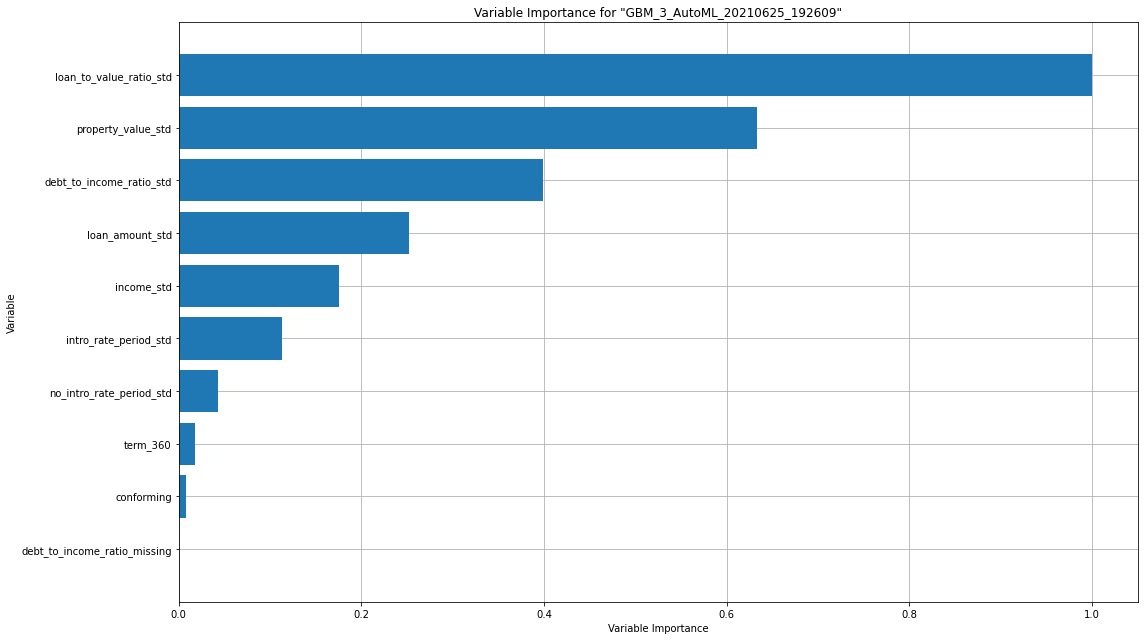

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

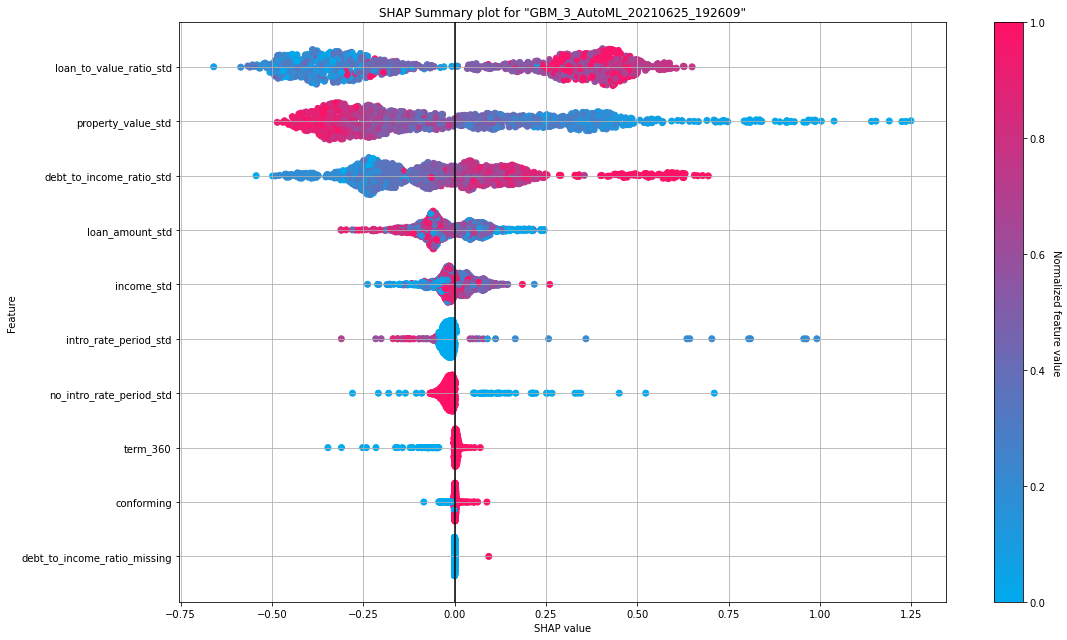

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

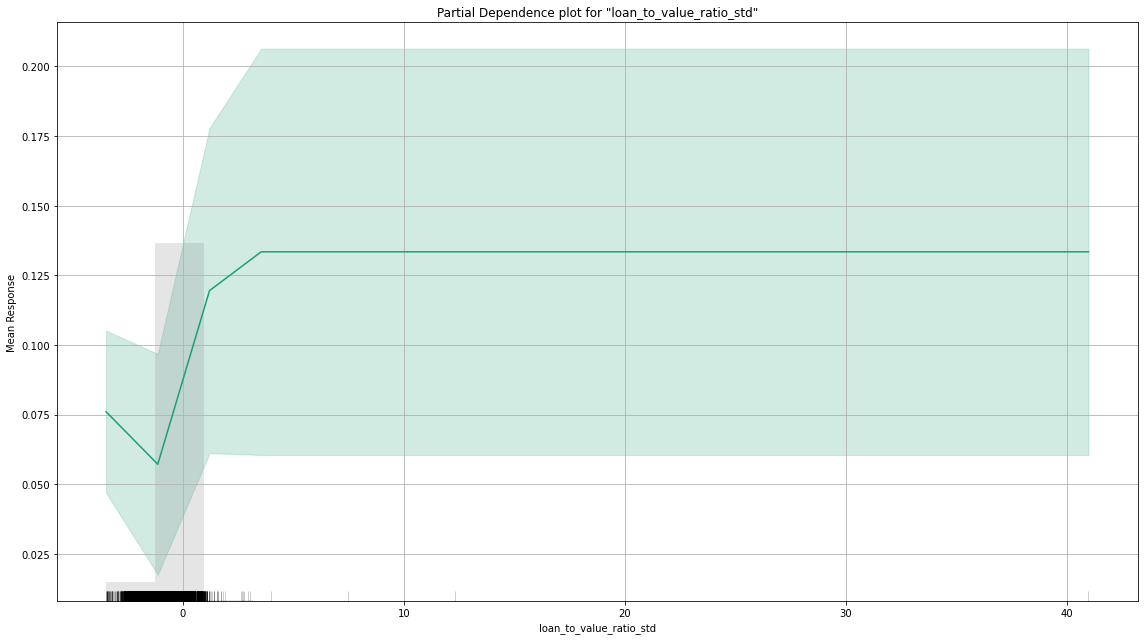

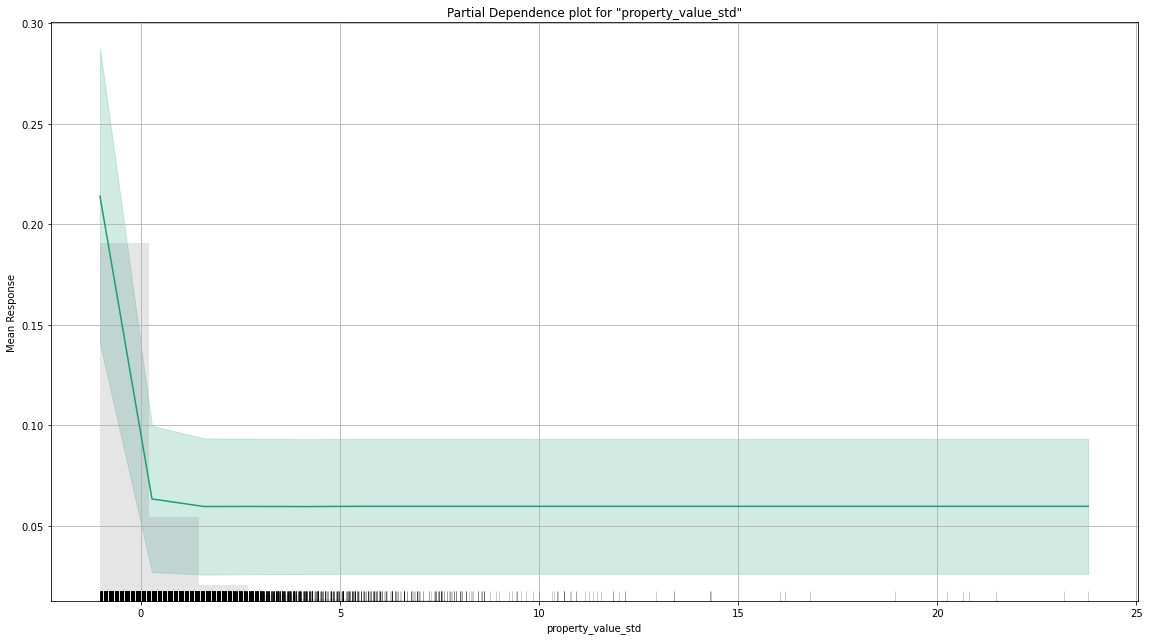

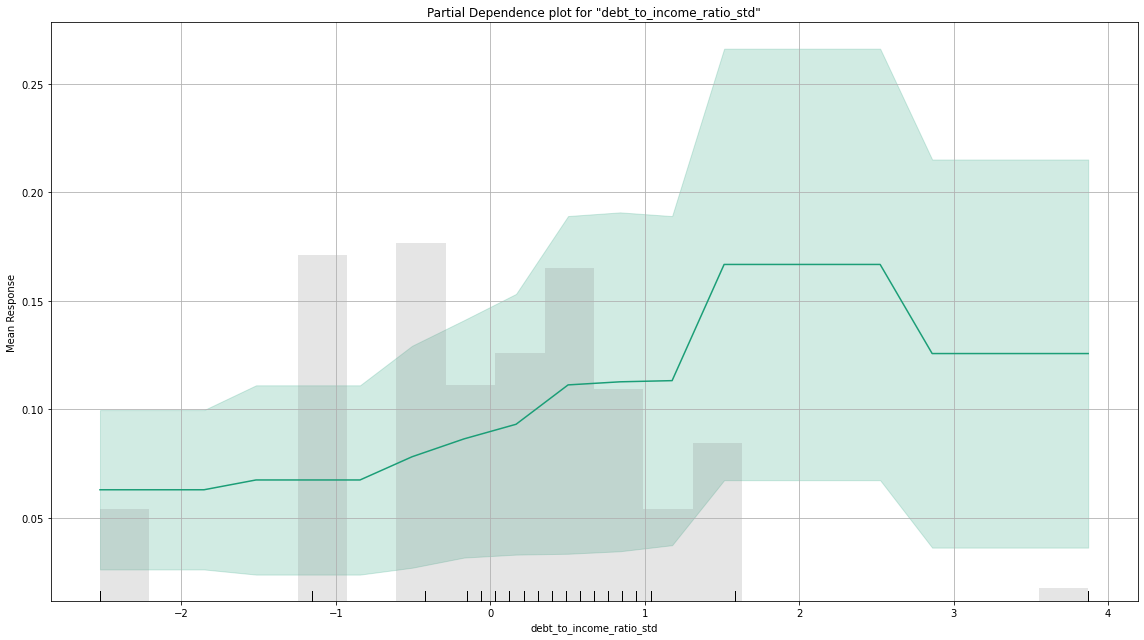

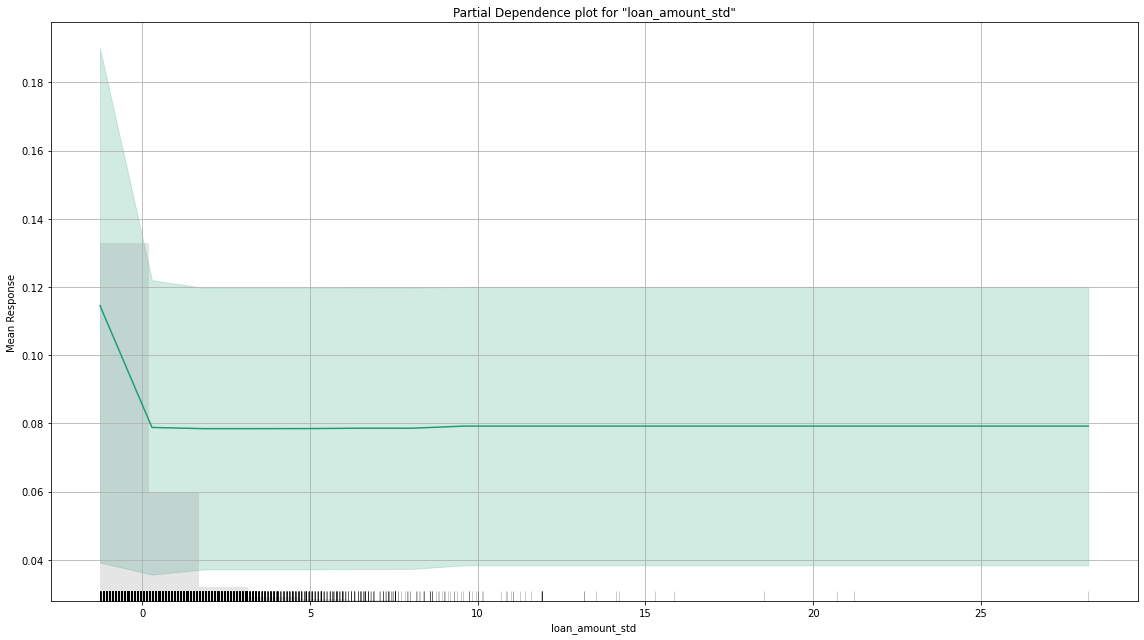

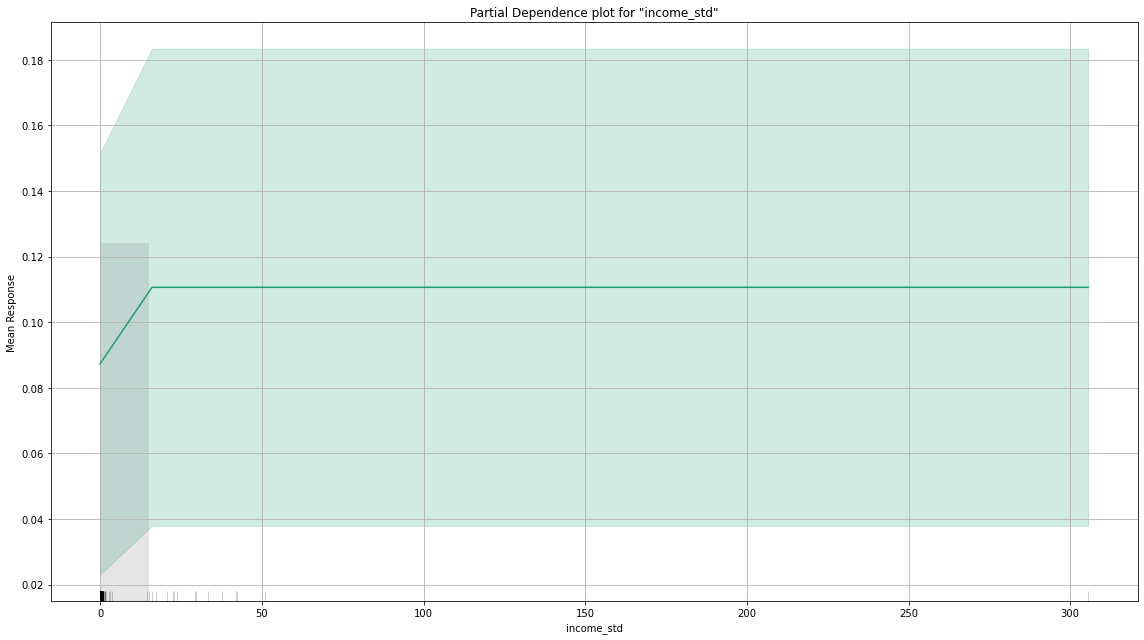

In [48]:
exa_gbm = gbm_h2o.explain(hvalid)

### Ensenble

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210625_192609


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1735788380386385: 


0.0     1.0   Error              Rate
0    0.0  7334.0  1623.0  0.1812   (1623.0/8957.0)
1    1.0   319.0   641.0  0.3323     (319.0/960.0)
2  Total  7653.0  2264.0  0.1958   (1942.0/9917.0)

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

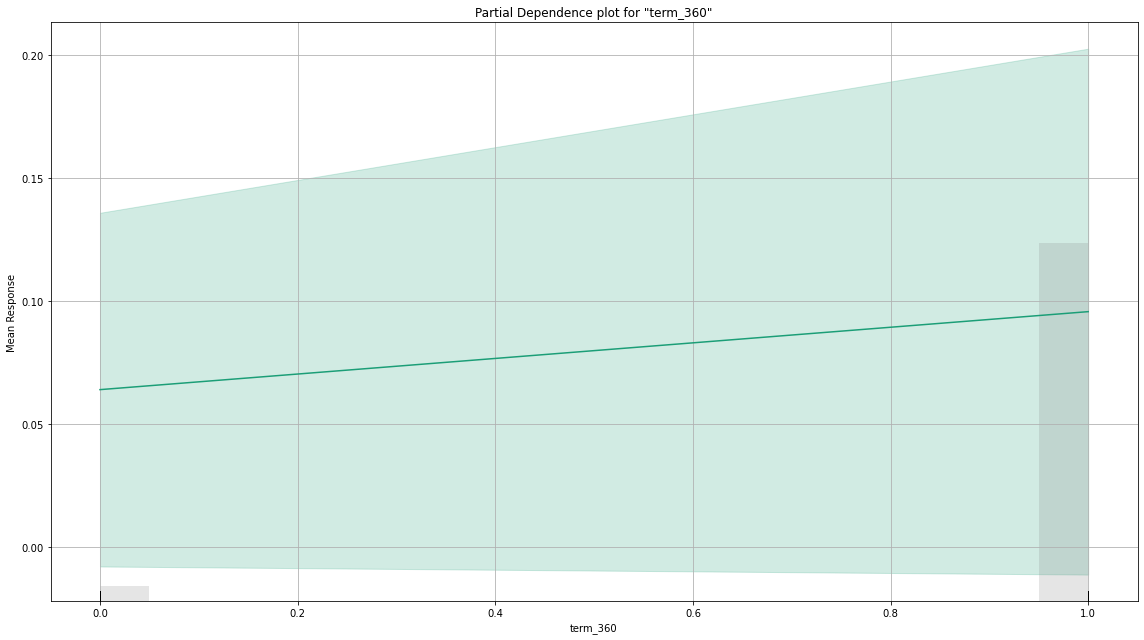

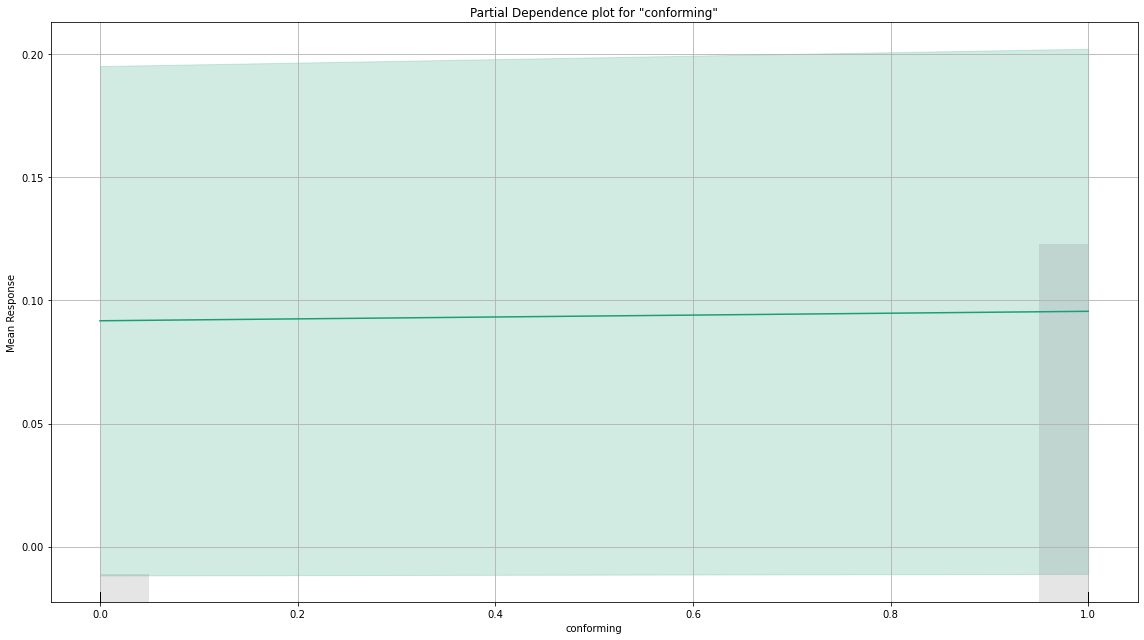

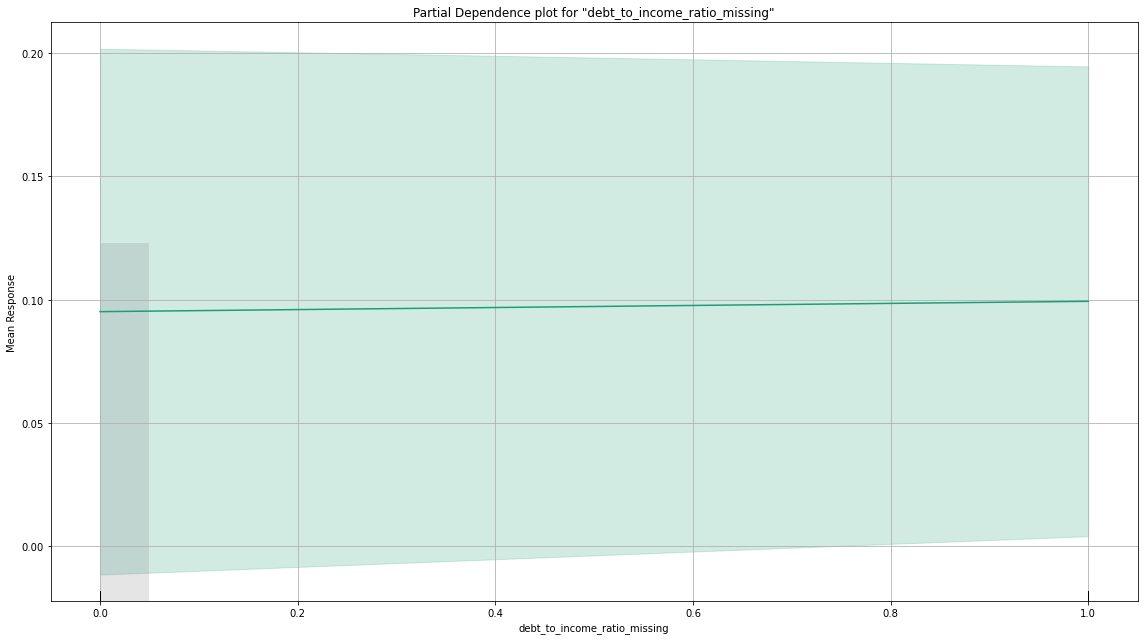

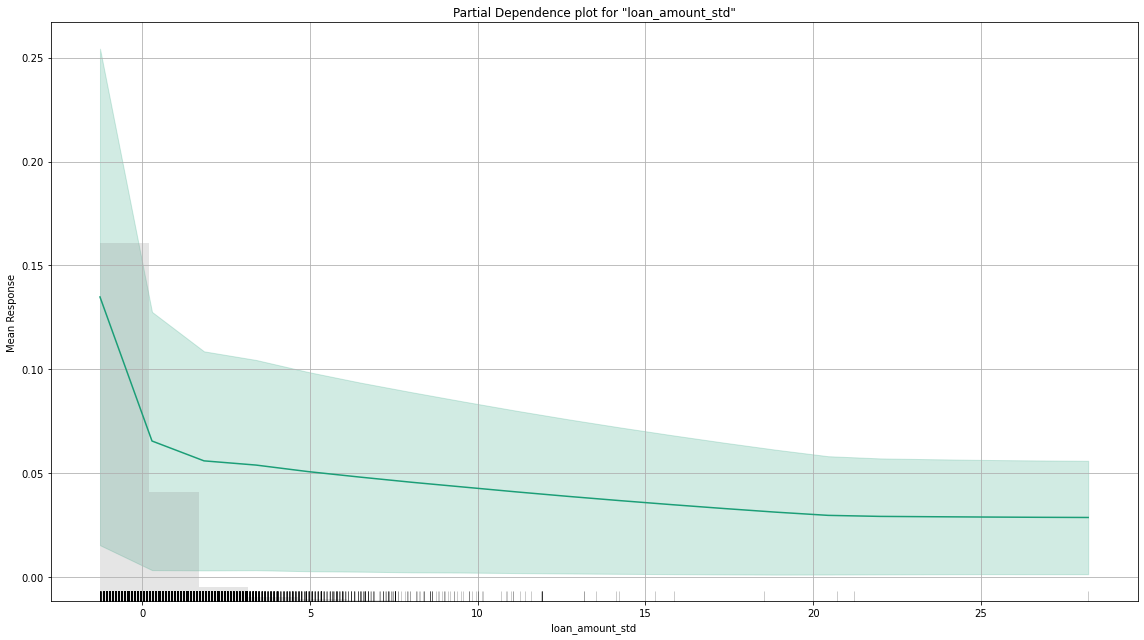

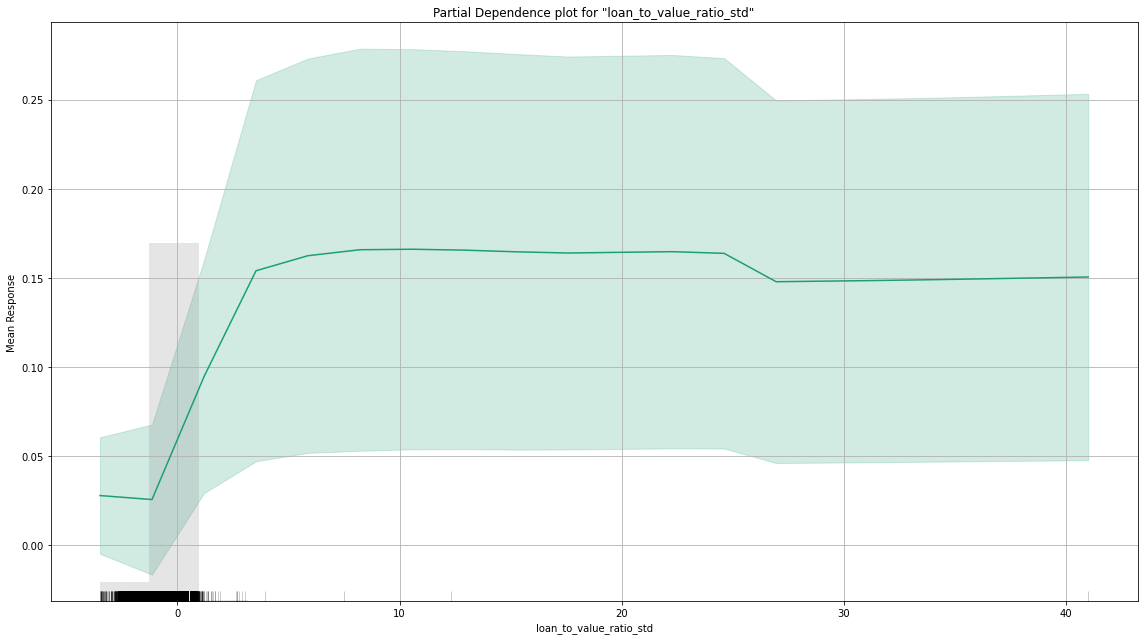

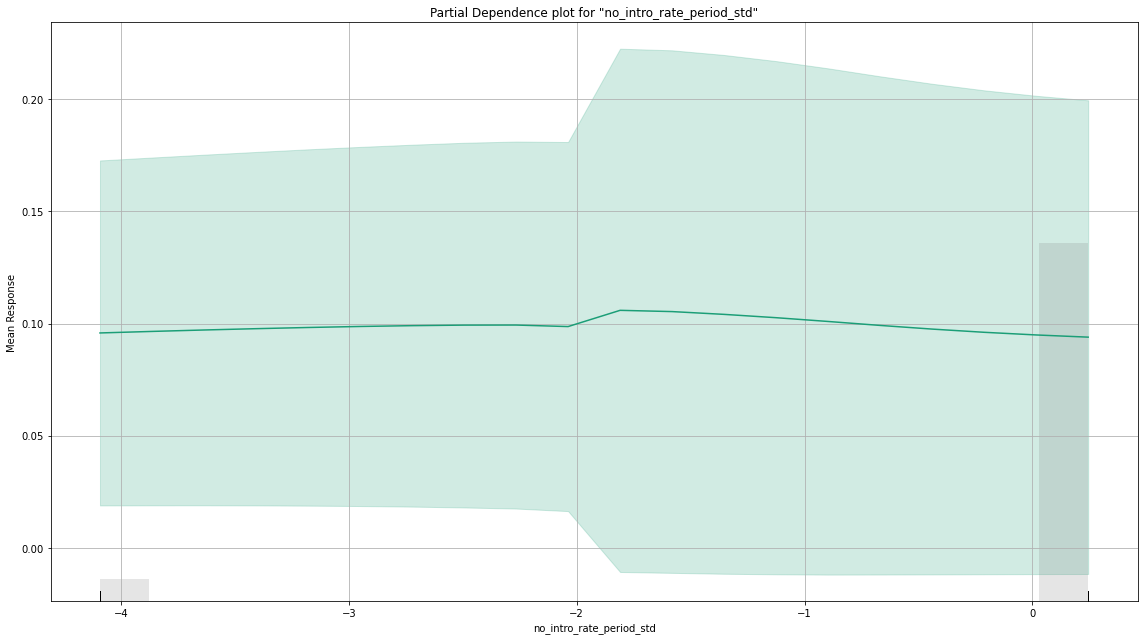

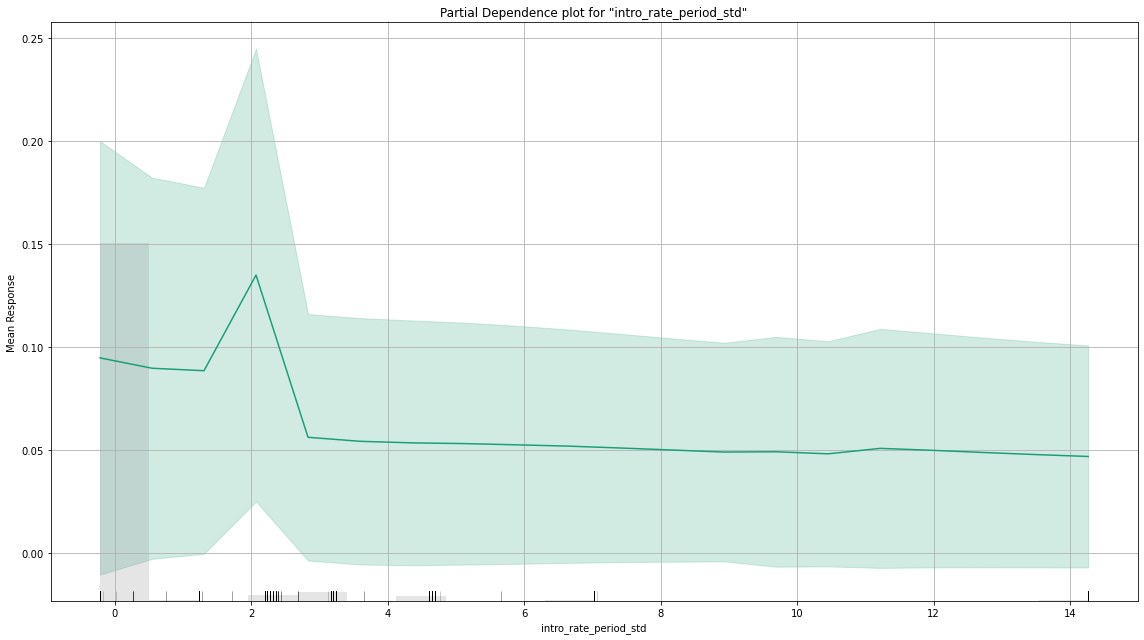

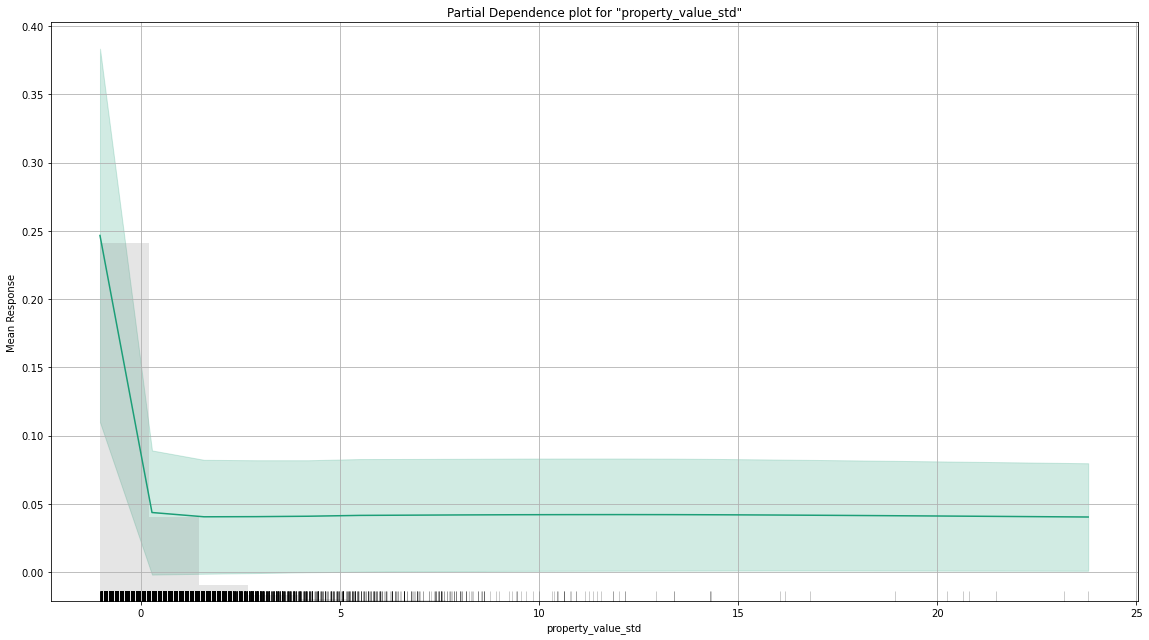

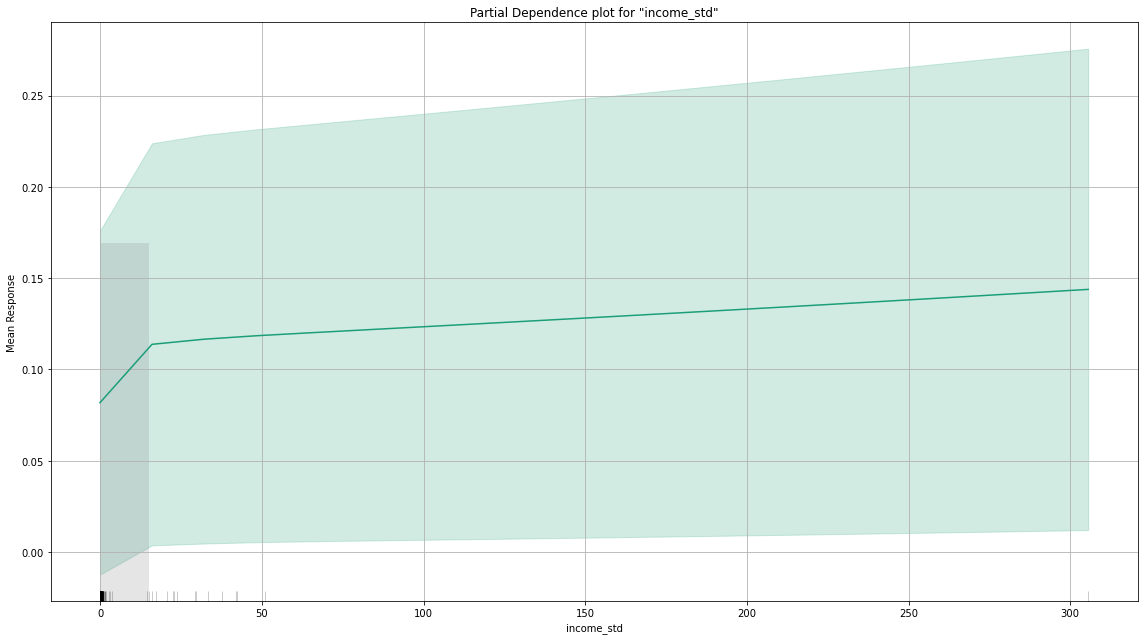

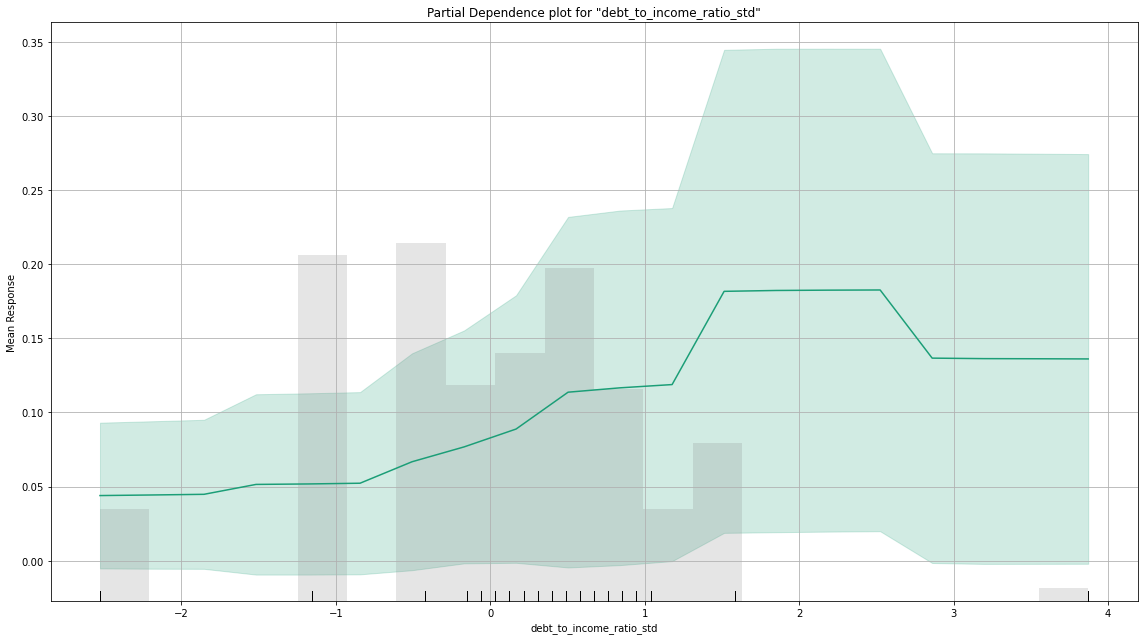

In [49]:
exa_ensenble = ensenble_h2o.explain(hvalid)

In [50]:
# end global timer 
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 2220.88 s.


In [51]:
# shutdown h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_a651 closed.
